In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.io import ascii
from astropy import units as u
from astropy import constants

deg = np.pi/180.
yr = 365.25 # days / year

# Astrometric Orbits with Exoplanet

In the previous tutorial (:ref:`astrometric`) we showed how to fit an orbit with `exoplanet` where only astrometric information is available. In this notebook we'll extend that same example to also include the available radial velocity information on the system. 

## Data 
As before we'll use the astrometric and radial velocity measurements of HR 466 (HD 10009) as compiled by [Pourbaix 1998](https://ui.adsabs.harvard.edu/#abs/1998A&AS..131..377P/abstract). The speckle observations are from [Hartkopf et al. 1996](https://ui.adsabs.harvard.edu/#abs/1996AJ....111..370H/abstract), and the radial velocities  are from [Tokovinin 1993](https://ui.adsabs.harvard.edu/#abs/1993AstL...19...73T/abstract). 

In [4]:
# grab the formatted data and do some munging

dirname = "https://gist.github.com/iancze/262aba2429cb9aee3fd5b5e1a4582d4d/raw/c5fa5bc39fec90d2cc2e736eed479099e3e598e3/"

astro_data_full = ascii.read(dirname + "astro.txt", format="csv", fill_values=[(".", '0')])

rv1_data = ascii.read(dirname + "rv1.txt", format="csv")
rv2_data = ascii.read(dirname + "rv2.txt", format="csv")

In [5]:
# convert UT date to JD
astro_dates = Time(astro_data_full["date"].data, format="decimalyear")

# Following the Pourbaix et al. 1998 analysis, we'll limit ourselves to the highest quality data
# since the raw collection of data outside of these ranges has some ambiguities in swapping 
# the primary and secondary star
ind = (astro_dates.value > 1975.) & (astro_dates.value < 1999.73) \
    & (~astro_data_full["rho"].mask) & (~astro_data_full["PA"].mask) # eliminate entries with no measurements

astro_data = astro_data_full[ind]

astro_yrs = astro_data["date"]
astro_dates.format = 'jd'
astro_jds = astro_dates[ind].value

# adjust the errors as before
astro_data["rho_err"][astro_data["rho_err"].mask == True] = 0.01
astro_data["PA_err"][astro_data["PA_err"].mask == True] = 1.0

# convert all masked frames to be raw np arrays, since theano has issues with astropy masked columns
rho_data = np.ascontiguousarray(astro_data["rho"], dtype=float) # arcsec
rho_err = np.ascontiguousarray(astro_data["rho_err"], dtype=float)

# the position angle measurements come in degrees in the range [0, 360].
# we need to convert this to radians in the range [-pi, pi]
theta_data = np.ascontiguousarray(astro_data["PA"] * deg, dtype=float) 
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(astro_data["PA_err"] * deg) # radians

In [6]:
# take out the data as only numpy arrays
rv1 = rv1_data["rv"].data
rv1_err = rv1_data["err"].data

rv2 = rv2_data["rv"].data
rv2_err = rv2_data["err"].data

# adapt the dates of the RV series 
rv1_dates = Time(rv1_data["date"] + 2400000, format="jd")
rv1_jds = rv1_dates.value
rv2_dates = Time(rv2_data["date"] + 2400000, format="jd")
rv2_jds = rv2_dates.value

rv1_yr = rv1_dates.decimalyear
rv2_yr = rv2_dates.decimalyear

As before, we'll plot $\rho$ vs. time and P.A. vs. time. We'll also add the RV time series for the primary and secondary stars.

/mnt/home/dforeman/miniconda3/envs/autoexoplanet/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


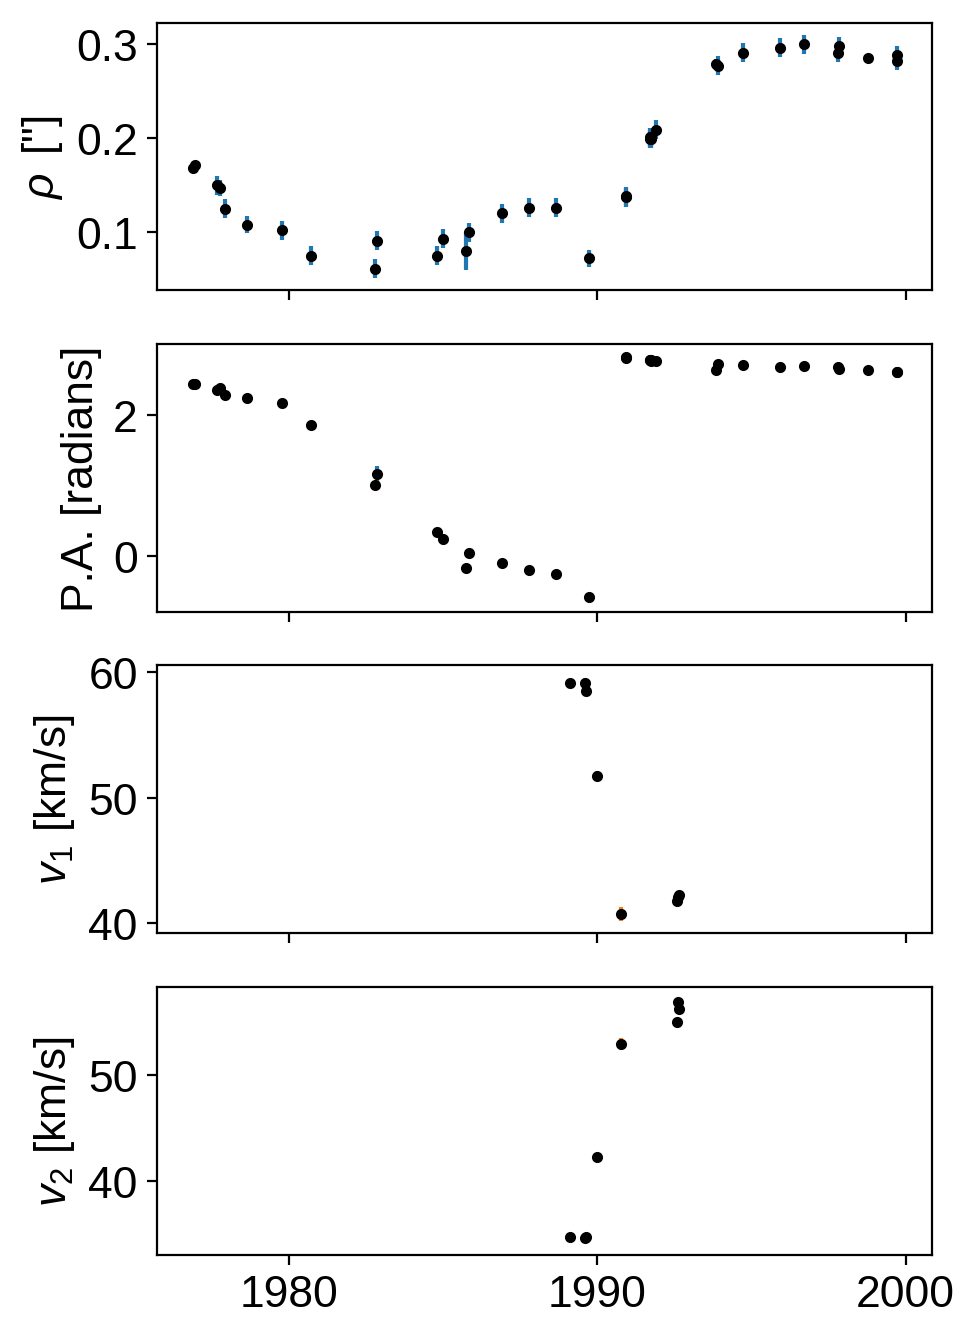

In [7]:
pkw = {"ls":"", "color":"k", "marker":"."}
ekw = {"ls":"", "color":"C1"}

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(5,8))
ax[0].plot(astro_yrs, rho_data, **pkw)
ax[0].errorbar(astro_yrs, rho_data, yerr=rho_err, ls="")
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].plot(astro_yrs, theta_data, **pkw)
ax[1].errorbar(astro_yrs, theta_data, yerr=theta_err, ls="")
ax[1].set_ylabel(r'P.A. [radians]');

ax[2].plot(rv1_yr, rv1, **pkw)
ax[2].errorbar(rv1_yr, rv1, yerr=rv1_err, **ekw)
ax[2].set_ylabel(r"$v_1$ [km/s]")

ax[3].plot(rv2_yr, rv2, **pkw)
ax[3].errorbar(rv2_yr, rv2, yerr=rv2_err, **ekw)
ax[3].set_ylabel(r"$v_2$ [km/s]");

In [8]:
# import the relevant packages 
import pymc3 as pm 
import theano.tensor as tt

import exoplanet as xo
import exoplanet.orbits
from exoplanet.distributions import Angle

First, let's plot up a basic orbit with *exoplanet* to see if the best-fit parameters from Pourbaix et al. make sense. With the addition of radial velocity data, we can now constrain the masses of the stars. 

In [9]:
def calc_Mtot(a, P):
    '''
    Calculate the total mass of the system using Kepler's third law. 
    
    Args: 
        a (au) semi-major axis
        P (days) period 
        
    Returns:
        Mtot (M_sun) total mass of system (M_primary + M_secondary)
    '''
    
    day_to_s = (1 * u.day).to(u.s).value
    au_to_m = (1 * u.au).to(u.m).value
    kg_to_M_sun = (1 * u.kg).to(u.M_sun).value
    
    return 4 * np.pi**2 * (a * au_to_m)**3 / (constants.G.value * (P * day_to_s)**2) * kg_to_M_sun

In [10]:
# Orbital elements from Pourbaix et al. 1998

# conversion constant
au_to_km = constants.au.to(u.km).value
au_to_R_sun = (constants.au / constants.R_sun).value

a_ang = 0.324 # arcsec
mparallax = 27.0 # milliarcsec 
parallax = 1e-3 * mparallax
a = a_ang / parallax # au

e = 0.798
i = 96.0 * deg # [rad]
omega = 251.6 * deg - np.pi # Pourbaix reports omega_2, but we want omega_1
Omega = 159.6 * deg 
P = 28.8 * yr # days

T0 = Time(1989.92, format="decimalyear")
T0.format = "jd"
T0 = T0.value # [Julian Date]

gamma = 47.8 # km/s; systemic velocity

# kappa = a1 / (a1 + a2)
kappa = 0.45 

# we parameterize exoplanet in terms of M2, so we'll need to 
# calculate Mtot from a, P, then M2 from Mtot and kappa
Mtot = calc_Mtot(a, P)
M2 = kappa * Mtot


# n.b. that we include an extra conversion for a, because exoplanet expects a in R_sun
# note that we now include M2 in the KeplerianOrbit initialization
orbit = xo.orbits.KeplerianOrbit(a=a * au_to_R_sun, t_periastron=T0, period=P, 
                               incl=i, ecc=e, omega=omega, Omega=Omega, m_planet=M2)

# make a theano function to get stuff from orbit 
times = tt.vector("times")
ang = orbit.get_relative_angles(times, parallax) # the rho, theta measurements

# convert from R_sun / day to km/s
output_units = u.km / u.s
conv = -(1 * u.R_sun / u.day).to(output_units).value
    
rv1_model = conv * orbit.get_star_velocity(times)[2] + gamma
rv2_model = conv * orbit.get_planet_velocity(times)[2] + gamma

f_ang = theano.function([times], ang)
f_rv1 = theano.function([times], rv1_model)
f_rv2 = theano.function([times], rv2_model)

t = np.linspace(T0 - 0.5 * P, T0 + 0.5 * P, num=2000) # days

rho_model, theta_model = f_ang(t)

rv1s = f_rv1(t)
rv2s = f_rv2(t)

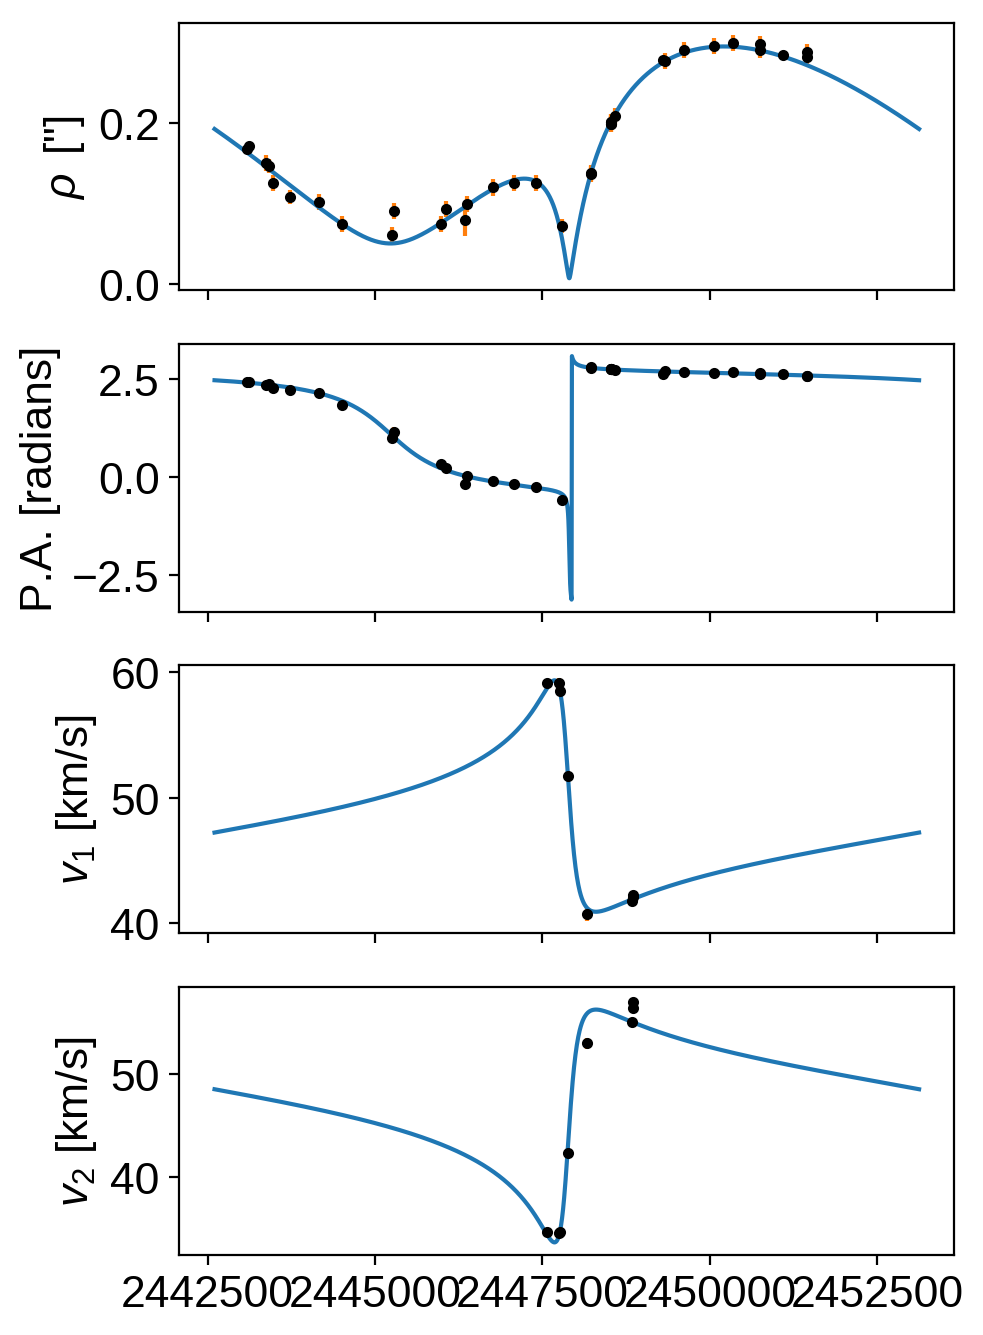

In [11]:
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(5,8))
ax[0].plot(t, rho_model)
ax[0].plot(astro_jds, rho_data, **pkw)
ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, **ekw)
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].plot(t, theta_model)
ax[1].plot(astro_jds, theta_data, **pkw)
ax[1].errorbar(astro_jds, theta_data, yerr=theta_err, **ekw)
ax[1].set_ylabel(r'P.A. [radians]');

ax[2].plot(t, rv1s)
ax[2].plot(rv1_jds, rv1, **pkw)
ax[2].errorbar(rv1_jds, rv1, yerr=rv1_err, **ekw)
ax[2].set_ylabel(r"$v_1$ [km/s]")

ax[3].plot(t, rv2s)
ax[3].plot(rv2_jds, rv2, **pkw)
ax[3].errorbar(rv2_jds, rv2, yerr=rv2_err, **ekw)
ax[3].set_ylabel(r"$v_2$ [km/s]");

It looks like a pretty good starting point. So, let's set up the model in PyMC3 for sampling.

In [12]:
# convert from R_sun / day to km/s
# and from v_r = - v_Z
output_units = u.km / u.s
conv = -(1 * u.R_sun / u.day).to(output_units).value

# for theta wrapping 
zeros = np.zeros_like(astro_jds)

# for predicted orbits
t_fine = np.linspace(astro_jds.min(), astro_jds.max(), num=1000)
rv_times = np.linspace(rv1_jds.min(), rv1_jds.max(), num=1000)

# for predicted sky orbits, spanning a full period
t_sky = np.linspace(0, 1, num=500)

with pm.Model() as model:

    # We'll include the parallax data as a prior on the parallax value     
    mparallax = pm.Normal("mparallax", mu=24.05, sd=0.45) # milliarcsec GAIA DR2
    parallax = pm.Deterministic("parallax", 1e-3 * mparallax) # arcsec
    a_ang = pm.Uniform("a_ang", 0.1, 1.0, testval=0.324) # arcsec 
        
    # the semi-major axis in au
    a = pm.Deterministic("a", a_ang / parallax)
        
    # we expect the period to be somewhere in the range of 25 years, 
    # so we'll set a broad prior on logP
    logP = pm.Uniform("logP", lower=np.log(1 * yr), upper=np.log(100* yr), testval=np.log(28.8 * yr))
    P = pm.Deterministic("P", tt.exp(logP)) # days
    
    # Since we're doing an RV + astrometric fit, M2 now becomes a parameter of the model
    M2 = pm.Normal("M2", mu=1.0, sd=0.5) # solar masses
    
    gamma = pm.Normal("gamma", mu=47.8, sd=5.0) # km/s
    
    omega = Angle("omega", testval=251.6 * deg - np.pi) # - pi to pi
    Omega = Angle("Omega", testval=159.6 * deg) # - pi to pi
    
    t_periastron = pm.Uniform("tperi", T0 - P, T0 + P)
    
    # uniform on cos incl
    cos_incl = pm.Uniform("cosIncl", lower=-1.0, upper=1.0, testval=np.cos(96.0 * deg)) # radians, 0 to 180 degrees
    incl = pm.Deterministic("incl", tt.arccos(cos_incl))
    
    e = pm.Uniform("e", lower=0.0, upper=1.0, testval=0.798)
           
    # n.b. that we include an extra conversion for a, because exoplanet expects a in R_sun
    orbit = xo.orbits.KeplerianOrbit(a=a * au_to_R_sun, t_periastron=t_periastron, period=P, 
                                   incl=incl, ecc=e, omega=omega, Omega=Omega, m_planet=M2)

    # now that we have a physical scale defined, the total mass of the system makes sense
    Mtot = pm.Deterministic("Mtot", orbit.m_total)
    M1 = pm.Deterministic("M1", Mtot - M2)
    
    # get the astrometric predictions
    rho_model, theta_model = orbit.get_relative_angles(astro_jds, parallax) # the rho, theta model values
        
    # add jitter terms to both separation and position angle
    log_rho_s = pm.Normal("logRhoS", mu=np.log(np.median(rho_err)), sd=5.0)
    log_theta_s = pm.Normal("logThetaS", mu=np.log(np.median(theta_err)), sd=5.0)
    
    rho_tot_err = tt.sqrt(rho_err**2 + tt.exp(2*log_rho_s))
    theta_tot_err = tt.sqrt(theta_err**2 + tt.exp(2*log_theta_s))
    
    # evaluate the astrometric likelihood functions
    pm.Normal("obs_rho", mu=rho_model, observed=rho_data, sd=rho_tot_err)
    theta_diff = tt.arctan2(tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data))
    pm.Normal("obs_theta", mu=theta_diff, observed=zeros, sd=theta_tot_err)

    # get the radial velocity predictions    
    # get_star_velocity and get_planet_velocity return (v_x, v_y, v_z) tuples, so we only need the v_z vector
    # but, note that since +Z points towards the observer, we actually want v_radial = -v_Z (see conv)
    # this is handled naturally by exoplanets get_radial_velocity (of the star), but since we also want
    # the "planet" velocity, or the velocity of the secondary, we queried both in this manner to be consistent
    rv1_model = conv * orbit.get_star_velocity(rv1_jds)[2] + gamma
    rv2_model = conv * orbit.get_planet_velocity(rv2_jds)[2] + gamma
    
    log_rv1_s = pm.Normal("logRV1S", mu=np.log(np.median(rv1_err)), sd=5.0)
    log_rv2_s = pm.Normal("logRV2S", mu=np.log(np.median(rv2_err)), sd=5.0)
    
    rv1_tot_err = tt.sqrt(rv1_err**2 + tt.exp(2 * log_rv1_s))
    rv2_tot_err = tt.sqrt(rv1_err**2 + tt.exp(2 * log_rv2_s))
    
    pm.Normal("obs_rv1", mu=rv1, observed=rv1_model, sd=rv1_tot_err)
    pm.Normal("obs_rv2", mu=rv2, observed=rv2_model, sd=rv2_tot_err)
    
    # save for future sep, pa, and RV plots 
    rho_dense, theta_dense = orbit.get_relative_angles(t_fine, parallax)
    rho_save = pm.Deterministic("rhoSave", rho_dense)
    theta_save = pm.Deterministic("thetaSave", theta_dense)    
    
    rv1_dense = pm.Deterministic("rv1Save", conv * orbit.get_star_velocity(rv_times)[2] + gamma)
    rv2_dense = pm.Deterministic("rv2Save", conv * orbit.get_planet_velocity(rv_times)[2] + gamma)
    
    # sky plots
    t_period = pm.Deterministic("tPeriod", t_sky * P + t_periastron)
    
    # save some samples on a fine orbit for sky plotting purposes
    rho, theta = orbit.get_relative_angles(t_period, parallax)
    rho_save_sky = pm.Deterministic("rhoSaveSky", rho)
    theta_save_sky = pm.Deterministic("thetaSaveSky", theta)

In [13]:
with model:
    map_sol = xo.optimize()

optimizing logp for variables: ['logRV2S', 'logRV1S', 'logThetaS', 'logRhoS', 'e_interval__', 'cosIncl_interval__', 'tperi_interval__', 'Omega_angle__', 'omega_angle__', 'gamma', 'M2', 'logP_interval__', 'a_ang_interval__', 'mparallax']


message: Desired error not necessarily achieved due to precision loss.
logp: -181.75633483899398 -> 171.06970010730316


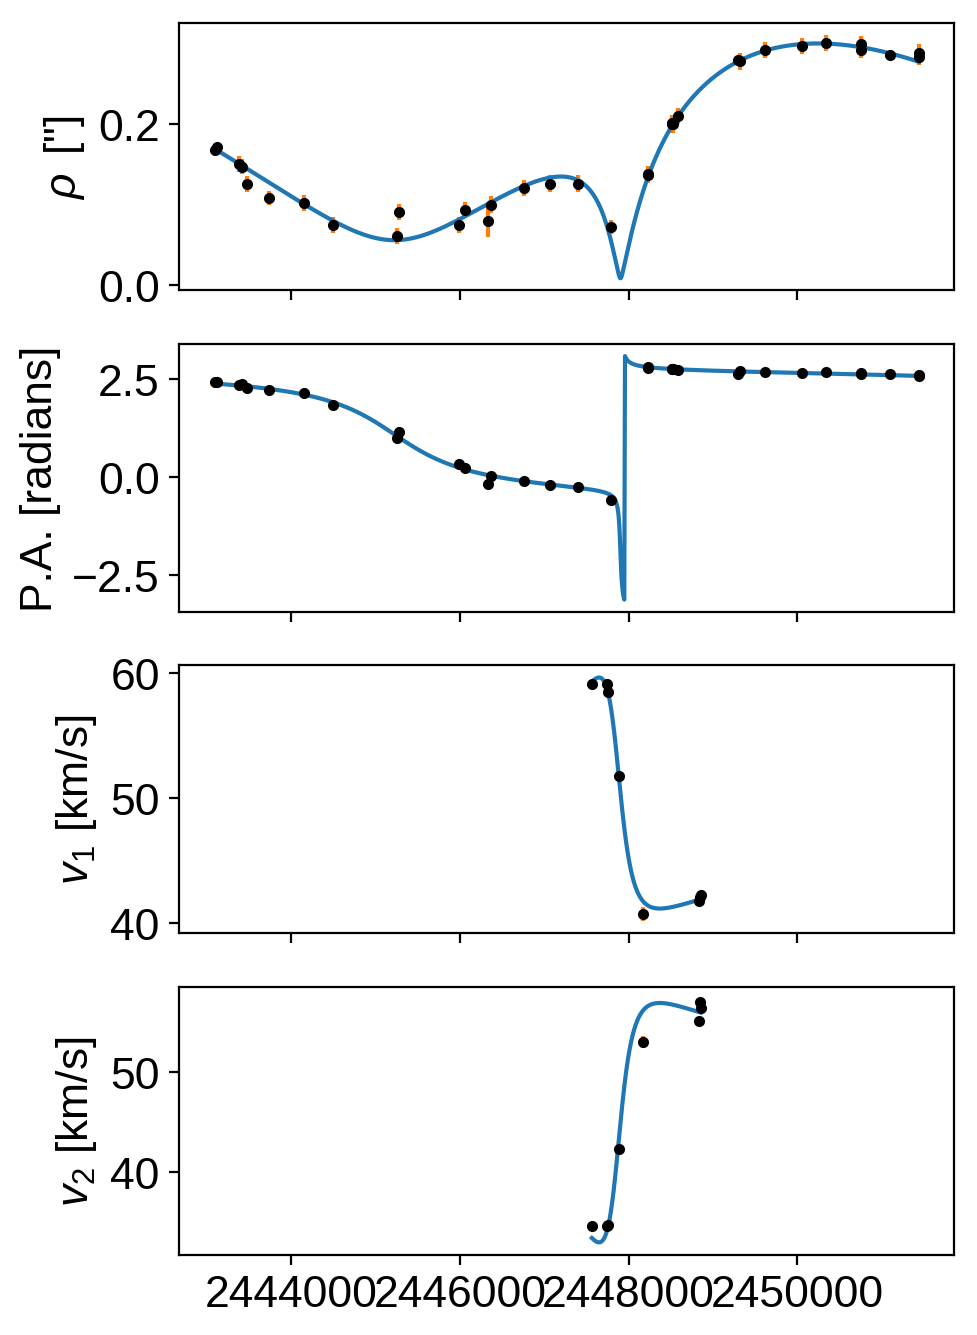

In [14]:
with model:

    fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(5,8))
    ax[0].plot(t_fine, xo.eval_in_model(rho_save, map_sol))
    ax[0].plot(astro_jds, rho_data, **pkw)
    ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, **ekw)
    ax[0].set_ylabel(r'$\rho\,$ ["]')

    ax[1].plot(t_fine, xo.eval_in_model(theta_save, map_sol))
    ax[1].plot(astro_jds, theta_data, **pkw)
    ax[1].errorbar(astro_jds, theta_data, yerr=theta_err, **ekw)
    ax[1].set_ylabel(r'P.A. [radians]');

    ax[2].plot(rv_times, xo.eval_in_model(rv1_dense, map_sol))
    ax[2].plot(rv1_jds, rv1, **pkw)
    ax[2].errorbar(rv1_jds, rv1, yerr=rv1_err, **ekw)
    ax[2].set_ylabel(r"$v_1$ [km/s]")

    ax[3].plot(rv_times, xo.eval_in_model(rv2_dense, map_sol))
    ax[3].plot(rv2_jds, rv2, **pkw)
    ax[3].errorbar(rv2_jds, rv2, yerr=rv2_err, **ekw)
    ax[3].set_ylabel(r"$v_2$ [km/s]");

In [15]:
# now let's actually explore the posterior for real
sampler = xo.PyMC3Sampler(start=200, window=100, finish=300)
with model:
    burnin = sampler.tune(tune=4000, start=map_sol,
                          step_kwargs=dict(target_accept=0.95))
    trace = sampler.sample(draws=4000)

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 13/808 [00:00<00:07, 100.01draws/s]

Sampling 4 chains:   2%|▏         | 17/808 [00:00<00:11, 67.06draws/s] 

Sampling 4 chains:   3%|▎         | 21/808 [00:00<00:14, 54.57draws/s]

Sampling 4 chains:   3%|▎         | 25/808 [00:00<00:16, 48.29draws/s]

Sampling 4 chains:   4%|▎         | 29/808 [00:00<00:17, 44.72draws/s]

Sampling 4 chains:   4%|▍         | 33/808 [00:00<00:18, 42.50draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:00<00:18, 41.09draws/s]

Sampling 4 chains:   5%|▌         | 41/808 [00:00<00:19, 40.15draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:00<00:19, 39.54draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:01<00:19, 38.07draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:01<00:19, 38.12draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:01<00:19, 38.15draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:01<00:19, 38.18draws/s]

Sampling 4 chains:   8%|▊         | 65/808 [00:01<00:19, 38.19draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:01<00:19, 37.87draws/s]

Sampling 4 chains:   9%|▉         | 73/808 [00:01<00:19, 37.85draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:01<00:19, 37.97draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:01<00:19, 38.05draws/s]

Sampling 4 chains:  11%|█         | 85/808 [00:02<00:18, 38.09draws/s]

Sampling 4 chains:  11%|█         | 89/808 [00:02<00:18, 38.15draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:02<00:19, 36.70draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:02<00:19, 37.16draws/s]

Sampling 4 chains:  12%|█▎        | 101/808 [00:02<00:18, 37.31draws/s]

Sampling 4 chains:  13%|█▎        | 105/808 [00:02<00:18, 37.46draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:02<00:18, 37.31draws/s]

Sampling 4 chains:  14%|█▍        | 113/808 [00:02<00:18, 37.19draws/s]

Sampling 4 chains:  14%|█▍        | 117/808 [00:02<00:18, 37.31draws/s]

Sampling 4 chains:  15%|█▍        | 121/808 [00:02<00:18, 37.71draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:03<00:17, 37.99draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:03<00:17, 38.18draws/s]

Sampling 4 chains:  16%|█▋        | 133/808 [00:03<00:17, 38.32draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:03<00:18, 37.20draws/s]

Sampling 4 chains:  17%|█▋        | 141/808 [00:03<00:17, 37.59draws/s]

Sampling 4 chains:  18%|█▊        | 145/808 [00:03<00:17, 37.63draws/s]

Sampling 4 chains:  18%|█▊        | 149/808 [00:03<00:17, 37.90draws/s]

Sampling 4 chains:  19%|█▉        | 153/808 [00:03<00:17, 38.08draws/s]

Sampling 4 chains:  19%|█▉        | 157/808 [00:03<00:17, 38.21draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:04<00:16, 38.32draws/s]

Sampling 4 chains:  20%|██        | 165/808 [00:04<00:16, 38.33draws/s]

Sampling 4 chains:  21%|██        | 169/808 [00:04<00:16, 38.38draws/s]

Sampling 4 chains:  21%|██▏       | 173/808 [00:04<00:16, 38.43draws/s]

Sampling 4 chains:  22%|██▏       | 177/808 [00:04<00:16, 38.42draws/s]

Sampling 4 chains:  22%|██▏       | 181/808 [00:04<00:16, 38.43draws/s]

Sampling 4 chains:  23%|██▎       | 187/808 [00:04<00:16, 37.46draws/s]

Sampling 4 chains:  24%|██▎       | 191/808 [00:04<00:16, 37.75draws/s]

Sampling 4 chains:  24%|██▍       | 195/808 [00:04<00:16, 37.97draws/s]

Sampling 4 chains:  25%|██▍       | 199/808 [00:05<00:16, 37.05draws/s]

Sampling 4 chains:  25%|██▌       | 203/808 [00:05<00:16, 37.42draws/s]

Sampling 4 chains:  26%|██▌       | 207/808 [00:05<00:15, 37.64draws/s]

Sampling 4 chains:  26%|██▌       | 211/808 [00:05<00:15, 37.86draws/s]

Sampling 4 chains:  27%|██▋       | 215/808 [00:05<00:15, 37.98draws/s]

Sampling 4 chains:  27%|██▋       | 219/808 [00:05<00:15, 37.67draws/s]

Sampling 4 chains:  28%|██▊       | 223/808 [00:05<00:15, 37.92draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [00:05<00:15, 38.10draws/s]

Sampling 4 chains:  29%|██▊       | 231/808 [00:05<00:15, 38.18draws/s]

Sampling 4 chains:  29%|██▉       | 235/808 [00:06<00:14, 38.28draws/s]

Sampling 4 chains:  30%|██▉       | 239/808 [00:06<00:14, 38.34draws/s]

Sampling 4 chains:  30%|███       | 243/808 [00:06<00:14, 38.40draws/s]

Sampling 4 chains:  31%|███       | 247/808 [00:06<00:14, 38.44draws/s]

Sampling 4 chains:  31%|███       | 251/808 [00:06<00:14, 38.47draws/s]

Sampling 4 chains:  32%|███▏      | 255/808 [00:06<00:14, 38.50draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [00:06<00:14, 38.52draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [00:06<00:14, 38.55draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [00:06<00:14, 38.54draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [00:06<00:13, 38.54draws/s]

Sampling 4 chains:  34%|███▍      | 275/808 [00:07<00:14, 38.07draws/s]

Sampling 4 chains:  35%|███▍      | 279/808 [00:07<00:13, 38.22draws/s]

Sampling 4 chains:  35%|███▌      | 283/808 [00:07<00:13, 38.34draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [00:07<00:13, 38.41draws/s]

Sampling 4 chains:  36%|███▌      | 291/808 [00:07<00:13, 38.15draws/s]

Sampling 4 chains:  37%|███▋      | 295/808 [00:07<00:13, 37.93draws/s]

Sampling 4 chains:  37%|███▋      | 299/808 [00:07<00:13, 38.08draws/s]

Sampling 4 chains:  38%|███▊      | 303/808 [00:07<00:13, 38.20draws/s]

Sampling 4 chains:  38%|███▊      | 307/808 [00:07<00:13, 38.29draws/s]

Sampling 4 chains:  38%|███▊      | 311/808 [00:07<00:12, 38.35draws/s]

Sampling 4 chains:  39%|███▉      | 315/808 [00:08<00:12, 38.39draws/s]

Sampling 4 chains:  39%|███▉      | 319/808 [00:08<00:12, 38.36draws/s]

Sampling 4 chains:  40%|███▉      | 323/808 [00:08<00:12, 38.38draws/s]

Sampling 4 chains:  40%|████      | 327/808 [00:08<00:12, 37.74draws/s]

Sampling 4 chains:  41%|████      | 331/808 [00:08<00:12, 36.95draws/s]

Sampling 4 chains:  41%|████▏     | 335/808 [00:08<00:12, 37.37draws/s]

Sampling 4 chains:  42%|████▏     | 339/808 [00:08<00:12, 37.71draws/s]

Sampling 4 chains:  42%|████▏     | 343/808 [00:08<00:12, 37.23draws/s]

Sampling 4 chains:  43%|████▎     | 347/808 [00:08<00:12, 36.17draws/s]

Sampling 4 chains:  43%|████▎     | 351/808 [00:09<00:12, 36.61draws/s]

Sampling 4 chains:  44%|████▍     | 355/808 [00:09<00:12, 36.95draws/s]

Sampling 4 chains:  44%|████▍     | 359/808 [00:09<00:12, 37.20draws/s]

Sampling 4 chains:  45%|████▍     | 363/808 [00:09<00:11, 37.38draws/s]

Sampling 4 chains:  45%|████▌     | 367/808 [00:09<00:11, 37.49draws/s]

Sampling 4 chains:  46%|████▌     | 371/808 [00:09<00:11, 37.61draws/s]

Sampling 4 chains:  46%|████▋     | 375/808 [00:09<00:11, 37.68draws/s]

Sampling 4 chains:  47%|████▋     | 379/808 [00:09<00:11, 37.64draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [00:09<00:11, 37.70draws/s]

Sampling 4 chains:  48%|████▊     | 387/808 [00:10<00:11, 37.74draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [00:10<00:11, 37.70draws/s]

Sampling 4 chains:  49%|████▉     | 395/808 [00:10<00:10, 37.73draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [00:10<00:10, 37.75draws/s]

Sampling 4 chains:  50%|████▉     | 403/808 [00:10<00:10, 37.79draws/s]

Sampling 4 chains:  50%|█████     | 407/808 [00:10<00:10, 37.79draws/s]

Sampling 4 chains:  51%|█████     | 411/808 [00:10<00:10, 37.81draws/s]

Sampling 4 chains:  51%|█████▏    | 415/808 [00:10<00:10, 37.80draws/s]

Sampling 4 chains:  52%|█████▏    | 419/808 [00:10<00:10, 37.83draws/s]

Sampling 4 chains:  52%|█████▏    | 424/808 [00:10<00:09, 38.53draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [00:11<00:09, 38.54draws/s]

Sampling 4 chains:  53%|█████▎    | 432/808 [00:11<00:09, 38.61draws/s]

Sampling 4 chains:  54%|█████▍    | 436/808 [00:11<00:09, 38.63draws/s]

Sampling 4 chains:  54%|█████▍    | 440/808 [00:11<00:09, 38.66draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [00:11<00:09, 38.64draws/s]

Sampling 4 chains:  55%|█████▌    | 448/808 [00:11<00:09, 38.60draws/s]

Sampling 4 chains:  56%|█████▌    | 452/808 [00:11<00:09, 38.60draws/s]

Sampling 4 chains:  57%|█████▋    | 457/808 [00:11<00:08, 39.20draws/s]

Sampling 4 chains:  57%|█████▋    | 461/808 [00:11<00:08, 38.80draws/s]

Sampling 4 chains:  58%|█████▊    | 465/808 [00:12<00:08, 38.50draws/s]

Sampling 4 chains:  58%|█████▊    | 469/808 [00:12<00:09, 36.84draws/s]

Sampling 4 chains:  59%|█████▊    | 473/808 [00:12<00:09, 37.12draws/s]

Sampling 4 chains:  59%|█████▉    | 477/808 [00:12<00:08, 36.93draws/s]

Sampling 4 chains:  60%|█████▉    | 481/808 [00:12<00:08, 37.21draws/s]

Sampling 4 chains:  60%|██████    | 485/808 [00:12<00:08, 37.44draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [00:12<00:08, 37.59draws/s]

Sampling 4 chains:  61%|██████    | 493/808 [00:12<00:08, 37.70draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [00:12<00:08, 37.79draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [00:13<00:08, 37.84draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [00:13<00:08, 37.86draws/s]

Sampling 4 chains:  63%|██████▎   | 509/808 [00:13<00:07, 37.89draws/s]

Sampling 4 chains:  63%|██████▎   | 513/808 [00:13<00:07, 37.88draws/s]

Sampling 4 chains:  64%|██████▍   | 517/808 [00:13<00:07, 37.90draws/s]

Sampling 4 chains:  64%|██████▍   | 521/808 [00:13<00:07, 37.90draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [00:13<00:07, 37.92draws/s]

Sampling 4 chains:  65%|██████▌   | 529/808 [00:13<00:07, 37.80draws/s]

Sampling 4 chains:  66%|██████▌   | 533/808 [00:13<00:07, 37.69draws/s]

Sampling 4 chains:  66%|██████▋   | 537/808 [00:13<00:07, 37.68draws/s]

Sampling 4 chains:  67%|██████▋   | 541/808 [00:14<00:07, 37.50draws/s]

Sampling 4 chains:  67%|██████▋   | 545/808 [00:14<00:06, 37.78draws/s]

Sampling 4 chains:  68%|██████▊   | 549/808 [00:14<00:06, 38.03draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [00:14<00:06, 38.02draws/s]

Sampling 4 chains:  69%|██████▉   | 557/808 [00:14<00:06, 38.08draws/s]

Sampling 4 chains:  69%|██████▉   | 561/808 [00:14<00:06, 38.14draws/s]

Sampling 4 chains:  70%|██████▉   | 565/808 [00:14<00:06, 38.09draws/s]

Sampling 4 chains:  70%|███████   | 569/808 [00:14<00:06, 38.02draws/s]

Sampling 4 chains:  71%|███████   | 573/808 [00:14<00:06, 38.03draws/s]

Sampling 4 chains:  71%|███████▏  | 577/808 [00:15<00:06, 38.01draws/s]

Sampling 4 chains:  72%|███████▏  | 581/808 [00:15<00:05, 37.99draws/s]

Sampling 4 chains:  72%|███████▏  | 585/808 [00:15<00:05, 37.99draws/s]

Sampling 4 chains:  73%|███████▎  | 589/808 [00:15<00:05, 37.99draws/s]

Sampling 4 chains:  73%|███████▎  | 593/808 [00:15<00:05, 37.99draws/s]

Sampling 4 chains:  74%|███████▍  | 597/808 [00:15<00:05, 38.00draws/s]

Sampling 4 chains:  74%|███████▍  | 601/808 [00:15<00:05, 37.97draws/s]

Sampling 4 chains:  75%|███████▍  | 605/808 [00:15<00:05, 37.93draws/s]

Sampling 4 chains:  75%|███████▌  | 609/808 [00:15<00:05, 37.87draws/s]

Sampling 4 chains:  76%|███████▌  | 613/808 [00:15<00:05, 37.79draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [00:16<00:05, 36.11draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [00:16<00:05, 36.34draws/s]

Sampling 4 chains:  77%|███████▋  | 626/808 [00:16<00:05, 36.03draws/s]

Sampling 4 chains:  78%|███████▊  | 630/808 [00:16<00:04, 36.33draws/s]

Sampling 4 chains:  79%|███████▊  | 635/808 [00:16<00:04, 38.25draws/s]

Sampling 4 chains:  79%|███████▉  | 639/808 [00:16<00:04, 38.34draws/s]

Sampling 4 chains:  80%|███████▉  | 643/808 [00:16<00:04, 38.42draws/s]

Sampling 4 chains:  80%|████████  | 647/808 [00:16<00:04, 38.49draws/s]

Sampling 4 chains:  81%|████████  | 651/808 [00:16<00:04, 38.53draws/s]

Sampling 4 chains:  81%|████████  | 655/808 [00:17<00:03, 38.52draws/s]

Sampling 4 chains:  82%|████████▏ | 659/808 [00:17<00:03, 38.52draws/s]

Sampling 4 chains:  82%|████████▏ | 663/808 [00:17<00:03, 38.54draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [00:17<00:03, 38.53draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [00:17<00:03, 38.53draws/s]

Sampling 4 chains:  84%|████████▎ | 675/808 [00:17<00:03, 38.53draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [00:17<00:03, 38.18draws/s]

Sampling 4 chains:  85%|████████▍ | 683/808 [00:17<00:03, 38.28draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [00:17<00:03, 36.39draws/s]

Sampling 4 chains:  86%|████████▌ | 691/808 [00:18<00:03, 36.98draws/s]

Sampling 4 chains:  86%|████████▌ | 695/808 [00:18<00:03, 37.45draws/s]

Sampling 4 chains:  87%|████████▋ | 699/808 [00:18<00:02, 37.77draws/s]

Sampling 4 chains:  87%|████████▋ | 703/808 [00:18<00:02, 37.99draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [00:18<00:02, 38.17draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [00:18<00:02, 38.28draws/s]

Sampling 4 chains:  88%|████████▊ | 715/808 [00:18<00:02, 38.37draws/s]

Sampling 4 chains:  89%|████████▉ | 719/808 [00:18<00:02, 38.43draws/s]

Sampling 4 chains:  89%|████████▉ | 723/808 [00:18<00:02, 38.46draws/s]

Sampling 4 chains:  90%|████████▉ | 727/808 [00:18<00:02, 38.41draws/s]

Sampling 4 chains:  90%|█████████ | 731/808 [00:19<00:02, 38.24draws/s]

Sampling 4 chains:  91%|█████████ | 735/808 [00:19<00:01, 37.96draws/s]

Sampling 4 chains:  91%|█████████▏| 739/808 [00:19<00:01, 37.61draws/s]

Sampling 4 chains:  92%|█████████▏| 743/808 [00:19<00:01, 37.46draws/s]

Sampling 4 chains:  92%|█████████▏| 747/808 [00:19<00:01, 37.34draws/s]

Sampling 4 chains:  93%|█████████▎| 751/808 [00:19<00:01, 37.25draws/s]

Sampling 4 chains:  93%|█████████▎| 755/808 [00:19<00:01, 37.22draws/s]

Sampling 4 chains:  94%|█████████▍| 759/808 [00:19<00:01, 37.19draws/s]

Sampling 4 chains:  94%|█████████▍| 763/808 [00:19<00:01, 37.17draws/s]

Sampling 4 chains:  95%|█████████▍| 767/808 [00:20<00:01, 37.14draws/s]

Sampling 4 chains:  95%|█████████▌| 771/808 [00:20<00:00, 37.15draws/s]

Sampling 4 chains:  96%|█████████▌| 775/808 [00:20<00:00, 37.13draws/s]

Sampling 4 chains:  96%|█████████▋| 779/808 [00:20<00:00, 37.07draws/s]

Sampling 4 chains:  97%|█████████▋| 783/808 [00:20<00:00, 37.12draws/s]

Sampling 4 chains:  97%|█████████▋| 787/808 [00:20<00:00, 37.11draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [00:20<00:00, 37.09draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [00:20<00:00, 34.30draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [00:21<00:00, 23.49draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [00:21<00:00, 23.62draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [00:21<00:00, 14.52draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:22<00:00,  9.57draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   4%|▍         | 17/408 [00:00<00:03, 114.98draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:05, 70.77draws/s] 

Sampling 4 chains:   6%|▌         | 25/408 [00:00<00:06, 55.86draws/s]

Sampling 4 chains:   7%|▋         | 29/408 [00:00<00:07, 48.66draws/s]

Sampling 4 chains:   8%|▊         | 33/408 [00:00<00:08, 44.69draws/s]

Sampling 4 chains:   9%|▉         | 37/408 [00:00<00:08, 42.24draws/s]

Sampling 4 chains:  11%|█         | 44/408 [00:00<00:07, 47.02draws/s]

Sampling 4 chains:  12%|█▏        | 49/408 [00:00<00:08, 40.82draws/s]

Sampling 4 chains:  13%|█▎        | 55/408 [00:01<00:08, 42.34draws/s]

Sampling 4 chains:  15%|█▍        | 60/408 [00:01<00:08, 43.47draws/s]

Sampling 4 chains:  16%|█▌        | 65/408 [00:01<00:07, 44.31draws/s]

Sampling 4 chains:  17%|█▋        | 70/408 [00:01<00:07, 44.56draws/s]

Sampling 4 chains:  18%|█▊        | 75/408 [00:01<00:08, 39.68draws/s]

Sampling 4 chains:  20%|█▉        | 80/408 [00:01<00:07, 41.20draws/s]

Sampling 4 chains:  21%|██        | 86/408 [00:01<00:07, 44.75draws/s]

Sampling 4 chains:  22%|██▏       | 91/408 [00:01<00:07, 45.25draws/s]

Sampling 4 chains:  24%|██▎       | 96/408 [00:02<00:06, 45.03draws/s]

Sampling 4 chains:  25%|██▍       | 101/408 [00:02<00:07, 41.77draws/s]

Sampling 4 chains:  26%|██▌       | 107/408 [00:02<00:06, 44.28draws/s]

Sampling 4 chains:  27%|██▋       | 112/408 [00:02<00:06, 44.42draws/s]

Sampling 4 chains:  29%|██▊       | 117/408 [00:02<00:06, 42.09draws/s]

Sampling 4 chains:  30%|██▉       | 122/408 [00:02<00:06, 42.51draws/s]

Sampling 4 chains:  31%|███       | 127/408 [00:02<00:06, 43.17draws/s]

Sampling 4 chains:  32%|███▏      | 132/408 [00:02<00:06, 43.67draws/s]

Sampling 4 chains:  34%|███▎      | 137/408 [00:02<00:06, 42.66draws/s]

Sampling 4 chains:  35%|███▍      | 142/408 [00:03<00:06, 42.65draws/s]

Sampling 4 chains:  36%|███▌      | 147/408 [00:03<00:06, 42.96draws/s]

Sampling 4 chains:  37%|███▋      | 152/408 [00:03<00:06, 40.70draws/s]

Sampling 4 chains:  38%|███▊      | 157/408 [00:03<00:05, 42.25draws/s]

Sampling 4 chains:  40%|███▉      | 162/408 [00:03<00:05, 41.83draws/s]

Sampling 4 chains:  41%|████      | 167/408 [00:03<00:05, 41.39draws/s]

Sampling 4 chains:  42%|████▏     | 172/408 [00:03<00:05, 40.94draws/s]

Sampling 4 chains:  44%|████▍     | 179/408 [00:03<00:04, 45.97draws/s]

Sampling 4 chains:  45%|████▌     | 184/408 [00:04<00:04, 45.94draws/s]

Sampling 4 chains:  46%|████▋     | 189/408 [00:04<00:04, 44.92draws/s]

Sampling 4 chains:  48%|████▊     | 194/408 [00:04<00:04, 44.08draws/s]

Sampling 4 chains:  49%|████▉     | 199/408 [00:04<00:04, 42.07draws/s]

Sampling 4 chains:  50%|█████     | 204/408 [00:04<00:04, 41.19draws/s]

Sampling 4 chains:  51%|█████     | 209/408 [00:04<00:05, 39.04draws/s]

Sampling 4 chains:  52%|█████▏    | 214/408 [00:04<00:04, 40.94draws/s]

Sampling 4 chains:  54%|█████▍    | 220/408 [00:04<00:04, 44.68draws/s]

Sampling 4 chains:  55%|█████▌    | 225/408 [00:04<00:04, 45.28draws/s]

Sampling 4 chains:  56%|█████▋    | 230/408 [00:05<00:03, 45.57draws/s]

Sampling 4 chains:  58%|█████▊    | 235/408 [00:05<00:03, 44.56draws/s]

Sampling 4 chains:  59%|█████▉    | 240/408 [00:05<00:03, 44.28draws/s]

Sampling 4 chains:  60%|██████    | 245/408 [00:05<00:03, 45.12draws/s]

Sampling 4 chains:  61%|██████▏   | 250/408 [00:05<00:03, 45.72draws/s]

Sampling 4 chains:  62%|██████▎   | 255/408 [00:05<00:03, 40.53draws/s]

Sampling 4 chains:  64%|██████▎   | 260/408 [00:05<00:03, 39.04draws/s]

Sampling 4 chains:  65%|██████▌   | 267/408 [00:05<00:03, 44.33draws/s]

Sampling 4 chains:  67%|██████▋   | 272/408 [00:06<00:03, 39.31draws/s]

Sampling 4 chains:  68%|██████▊   | 278/408 [00:06<00:03, 43.13draws/s]

Sampling 4 chains:  69%|██████▉   | 283/408 [00:06<00:02, 42.19draws/s]

Sampling 4 chains:  71%|███████   | 288/408 [00:06<00:02, 43.58draws/s]

Sampling 4 chains:  72%|███████▏  | 293/408 [00:06<00:02, 41.22draws/s]

Sampling 4 chains:  73%|███████▎  | 298/408 [00:06<00:02, 42.93draws/s]

Sampling 4 chains:  74%|███████▍  | 303/408 [00:06<00:02, 42.48draws/s]

Sampling 4 chains:  75%|███████▌  | 308/408 [00:06<00:02, 41.75draws/s]

Sampling 4 chains:  77%|███████▋  | 313/408 [00:07<00:02, 40.40draws/s]

Sampling 4 chains:  78%|███████▊  | 319/408 [00:07<00:02, 43.76draws/s]

Sampling 4 chains:  79%|███████▉  | 324/408 [00:07<00:01, 42.55draws/s]

Sampling 4 chains:  81%|████████  | 329/408 [00:07<00:01, 41.67draws/s]

Sampling 4 chains:  82%|████████▏ | 334/408 [00:07<00:01, 42.56draws/s]

Sampling 4 chains:  83%|████████▎ | 340/408 [00:07<00:01, 44.80draws/s]

Sampling 4 chains:  85%|████████▍ | 345/408 [00:07<00:01, 45.21draws/s]

Sampling 4 chains:  86%|████████▌ | 350/408 [00:07<00:01, 45.54draws/s]

Sampling 4 chains:  87%|████████▋ | 355/408 [00:07<00:01, 44.20draws/s]

Sampling 4 chains:  88%|████████▊ | 360/408 [00:08<00:01, 44.41draws/s]

Sampling 4 chains:  89%|████████▉ | 365/408 [00:08<00:00, 44.02draws/s]

Sampling 4 chains:  91%|█████████ | 370/408 [00:08<00:00, 44.27draws/s]

Sampling 4 chains:  92%|█████████▏| 375/408 [00:08<00:00, 42.85draws/s]

Sampling 4 chains:  93%|█████████▎| 380/408 [00:08<00:00, 41.20draws/s]

Sampling 4 chains:  94%|█████████▍| 385/408 [00:08<00:00, 42.78draws/s]

Sampling 4 chains:  96%|█████████▌| 390/408 [00:08<00:00, 43.38draws/s]

Sampling 4 chains:  97%|█████████▋| 395/408 [00:08<00:00, 44.54draws/s]

Sampling 4 chains:  98%|█████████▊| 400/408 [00:09<00:00, 43.70draws/s]

Sampling 4 chains:  99%|█████████▉| 405/408 [00:09<00:00, 26.00draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:09<00:00, 41.31draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 19/808 [00:00<00:04, 177.13draws/s]

Sampling 4 chains:   5%|▌         | 42/808 [00:00<00:04, 189.51draws/s]

Sampling 4 chains:   9%|▉         | 72/808 [00:00<00:03, 212.38draws/s]

Sampling 4 chains:  13%|█▎        | 102/808 [00:00<00:03, 230.62draws/s]

Sampling 4 chains:  16%|█▋        | 132/808 [00:00<00:02, 247.31draws/s]

Sampling 4 chains:  21%|██▏       | 172/808 [00:00<00:02, 278.39draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [00:00<00:01, 307.48draws/s]

Sampling 4 chains:  30%|███       | 246/808 [00:00<00:01, 304.35draws/s]

Sampling 4 chains:  35%|███▌      | 283/808 [00:00<00:01, 321.09draws/s]

Sampling 4 chains:  39%|███▉      | 319/808 [00:01<00:01, 329.57draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [00:01<00:01, 339.22draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [00:01<00:01, 324.54draws/s]

Sampling 4 chains:  53%|█████▎    | 426/808 [00:01<00:01, 329.89draws/s]

Sampling 4 chains:  57%|█████▋    | 464/808 [00:01<00:01, 342.83draws/s]

Sampling 4 chains:  62%|██████▏   | 502/808 [00:01<00:00, 350.96draws/s]

Sampling 4 chains:  67%|██████▋   | 538/808 [00:01<00:00, 345.03draws/s]

Sampling 4 chains:  71%|███████   | 574/808 [00:01<00:00, 347.23draws/s]

Sampling 4 chains:  75%|███████▌  | 609/808 [00:01<00:00, 343.63draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [00:01<00:00, 346.34draws/s]

Sampling 4 chains:  84%|████████▍ | 680/808 [00:02<00:00, 332.54draws/s]

Sampling 4 chains:  88%|████████▊ | 714/808 [00:02<00:00, 328.73draws/s]

Sampling 4 chains:  93%|█████████▎| 755/808 [00:02<00:00, 347.59draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [00:02<00:00, 239.81draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:02<00:00, 282.27draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|▏         | 21/1608 [00:00<00:08, 198.09draws/s]

Sampling 4 chains:   2%|▏         | 40/1608 [00:00<00:08, 195.05draws/s]

Sampling 4 chains:   4%|▍         | 68/1608 [00:00<00:07, 211.64draws/s]

Sampling 4 chains:   6%|▋         | 101/1608 [00:00<00:06, 236.15draws/s]

Sampling 4 chains:   8%|▊         | 128/1608 [00:00<00:06, 243.88draws/s]

Sampling 4 chains:   9%|▉         | 150/1608 [00:00<00:06, 212.91draws/s]

Sampling 4 chains:  11%|█         | 171/1608 [00:00<00:07, 202.19draws/s]

Sampling 4 chains:  12%|█▏        | 195/1608 [00:00<00:06, 208.64draws/s]

Sampling 4 chains:  13%|█▎        | 216/1608 [00:01<00:07, 186.13draws/s]

Sampling 4 chains:  15%|█▍        | 238/1608 [00:01<00:07, 194.02draws/s]

Sampling 4 chains:  16%|█▋        | 265/1608 [00:01<00:06, 211.02draws/s]

Sampling 4 chains:  18%|█▊        | 293/1608 [00:01<00:05, 227.00draws/s]

Sampling 4 chains:  20%|█▉        | 318/1608 [00:01<00:05, 232.65draws/s]

Sampling 4 chains:  21%|██▏       | 342/1608 [00:01<00:05, 230.77draws/s]

Sampling 4 chains:  23%|██▎       | 368/1608 [00:01<00:05, 237.75draws/s]

Sampling 4 chains:  24%|██▍       | 393/1608 [00:01<00:05, 224.61draws/s]

Sampling 4 chains:  26%|██▌       | 416/1608 [00:01<00:05, 213.97draws/s]

Sampling 4 chains:  27%|██▋       | 438/1608 [00:01<00:05, 209.96draws/s]

Sampling 4 chains:  29%|██▊       | 460/1608 [00:02<00:05, 212.70draws/s]

Sampling 4 chains:  30%|███       | 488/1608 [00:02<00:04, 227.54draws/s]

Sampling 4 chains:  32%|███▏      | 517/1608 [00:02<00:04, 241.26draws/s]

Sampling 4 chains:  34%|███▎      | 542/1608 [00:02<00:04, 235.29draws/s]

Sampling 4 chains:  35%|███▌      | 566/1608 [00:02<00:04, 234.41draws/s]

Sampling 4 chains:  37%|███▋      | 592/1608 [00:02<00:04, 240.29draws/s]

Sampling 4 chains:  38%|███▊      | 619/1608 [00:02<00:04, 245.91draws/s]

Sampling 4 chains:  40%|████      | 644/1608 [00:02<00:03, 243.63draws/s]

Sampling 4 chains:  42%|████▏     | 674/1608 [00:02<00:03, 257.95draws/s]

Sampling 4 chains:  44%|████▍     | 704/1608 [00:03<00:03, 268.70draws/s]

Sampling 4 chains:  46%|████▌     | 732/1608 [00:03<00:03, 258.23draws/s]

Sampling 4 chains:  47%|████▋     | 759/1608 [00:03<00:03, 258.86draws/s]

Sampling 4 chains:  49%|████▉     | 786/1608 [00:03<00:03, 261.47draws/s]

Sampling 4 chains:  51%|█████     | 813/1608 [00:03<00:03, 261.08draws/s]

Sampling 4 chains:  52%|█████▏    | 842/1608 [00:03<00:02, 268.78draws/s]

Sampling 4 chains:  54%|█████▍    | 870/1608 [00:03<00:02, 271.08draws/s]

Sampling 4 chains:  56%|█████▌    | 898/1608 [00:03<00:02, 245.94draws/s]

Sampling 4 chains:  57%|█████▋    | 924/1608 [00:03<00:02, 248.63draws/s]

Sampling 4 chains:  59%|█████▉    | 950/1608 [00:03<00:02, 247.89draws/s]

Sampling 4 chains:  61%|██████    | 976/1608 [00:04<00:02, 240.19draws/s]

Sampling 4 chains:  62%|██████▏   | 1001/1608 [00:04<00:02, 226.87draws/s]

Sampling 4 chains:  64%|██████▍   | 1027/1608 [00:04<00:02, 234.82draws/s]

Sampling 4 chains:  66%|██████▌   | 1055/1608 [00:04<00:02, 246.18draws/s]

Sampling 4 chains:  68%|██████▊   | 1088/1608 [00:04<00:01, 264.61draws/s]

Sampling 4 chains:  69%|██████▉   | 1116/1608 [00:04<00:01, 256.96draws/s]

Sampling 4 chains:  71%|███████   | 1143/1608 [00:04<00:01, 254.97draws/s]

Sampling 4 chains:  73%|███████▎  | 1170/1608 [00:04<00:01, 258.77draws/s]

Sampling 4 chains:  75%|███████▍  | 1202/1608 [00:04<00:01, 274.48draws/s]

Sampling 4 chains:  77%|███████▋  | 1232/1608 [00:05<00:01, 281.50draws/s]

Sampling 4 chains:  78%|███████▊  | 1261/1608 [00:05<00:01, 279.11draws/s]

Sampling 4 chains:  80%|████████  | 1290/1608 [00:05<00:01, 259.32draws/s]

Sampling 4 chains:  82%|████████▏ | 1317/1608 [00:05<00:01, 252.97draws/s]

Sampling 4 chains:  84%|████████▎ | 1344/1608 [00:05<00:01, 254.76draws/s]

Sampling 4 chains:  85%|████████▌ | 1374/1608 [00:05<00:00, 266.39draws/s]

Sampling 4 chains:  87%|████████▋ | 1402/1608 [00:05<00:00, 262.69draws/s]

Sampling 4 chains:  89%|████████▉ | 1429/1608 [00:05<00:00, 261.79draws/s]

Sampling 4 chains:  91%|█████████ | 1457/1608 [00:05<00:00, 265.89draws/s]

Sampling 4 chains:  93%|█████████▎| 1490/1608 [00:06<00:00, 281.48draws/s]

Sampling 4 chains:  94%|█████████▍| 1519/1608 [00:06<00:00, 260.48draws/s]

Sampling 4 chains:  96%|█████████▌| 1546/1608 [00:06<00:00, 227.35draws/s]

Sampling 4 chains:  98%|█████████▊| 1570/1608 [00:06<00:00, 214.24draws/s]

Sampling 4 chains:  99%|█████████▉| 1593/1608 [00:06<00:00, 199.15draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:06<00:00, 237.47draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 21/3208 [00:00<00:15, 204.03draws/s]

Sampling 4 chains:   1%|▏         | 43/3208 [00:00<00:15, 207.79draws/s]

Sampling 4 chains:   2%|▏         | 74/3208 [00:00<00:13, 229.27draws/s]

Sampling 4 chains:   3%|▎         | 98/3208 [00:00<00:13, 231.58draws/s]

Sampling 4 chains:   4%|▎         | 120/3208 [00:00<00:13, 226.26draws/s]

Sampling 4 chains:   4%|▍         | 143/3208 [00:00<00:13, 227.27draws/s]

Sampling 4 chains:   5%|▌         | 174/3208 [00:00<00:12, 245.92draws/s]

Sampling 4 chains:   6%|▌         | 199/3208 [00:00<00:12, 245.69draws/s]

Sampling 4 chains:   7%|▋         | 224/3208 [00:00<00:12, 245.44draws/s]

Sampling 4 chains:   8%|▊         | 249/3208 [00:01<00:12, 230.53draws/s]

Sampling 4 chains:   9%|▊         | 278/3208 [00:01<00:11, 244.84draws/s]

Sampling 4 chains:  10%|▉         | 307/3208 [00:01<00:11, 253.79draws/s]

Sampling 4 chains:  10%|█         | 333/3208 [00:01<00:11, 251.35draws/s]

Sampling 4 chains:  11%|█         | 360/3208 [00:01<00:11, 253.86draws/s]

Sampling 4 chains:  12%|█▏        | 386/3208 [00:01<00:11, 249.59draws/s]

Sampling 4 chains:  13%|█▎        | 418/3208 [00:01<00:10, 263.72draws/s]

Sampling 4 chains:  14%|█▍        | 445/3208 [00:01<00:10, 257.93draws/s]

Sampling 4 chains:  15%|█▍        | 472/3208 [00:01<00:10, 260.99draws/s]

Sampling 4 chains:  16%|█▌        | 500/3208 [00:01<00:10, 265.38draws/s]

Sampling 4 chains:  16%|█▋        | 527/3208 [00:02<00:11, 238.99draws/s]

Sampling 4 chains:  17%|█▋        | 552/3208 [00:02<00:11, 237.47draws/s]

Sampling 4 chains:  18%|█▊        | 577/3208 [00:02<00:11, 235.70draws/s]

Sampling 4 chains:  19%|█▉        | 602/3208 [00:02<00:11, 236.64draws/s]

Sampling 4 chains:  20%|█▉        | 626/3208 [00:02<00:11, 232.60draws/s]

Sampling 4 chains:  20%|██        | 656/3208 [00:02<00:10, 245.94draws/s]

Sampling 4 chains:  21%|██▏       | 683/3208 [00:02<00:10, 250.74draws/s]

Sampling 4 chains:  22%|██▏       | 710/3208 [00:02<00:09, 256.12draws/s]

Sampling 4 chains:  23%|██▎       | 736/3208 [00:02<00:09, 249.36draws/s]

Sampling 4 chains:  24%|██▍       | 762/3208 [00:03<00:09, 250.48draws/s]

Sampling 4 chains:  25%|██▍       | 789/3208 [00:03<00:09, 256.02draws/s]

Sampling 4 chains:  25%|██▌       | 815/3208 [00:03<00:09, 243.73draws/s]

Sampling 4 chains:  26%|██▌       | 840/3208 [00:03<00:09, 240.83draws/s]

Sampling 4 chains:  27%|██▋       | 870/3208 [00:03<00:09, 255.94draws/s]

Sampling 4 chains:  28%|██▊       | 904/3208 [00:03<00:08, 276.06draws/s]

Sampling 4 chains:  29%|██▉       | 933/3208 [00:03<00:08, 272.95draws/s]

Sampling 4 chains:  30%|███       | 964/3208 [00:03<00:08, 278.47draws/s]

Sampling 4 chains:  31%|███       | 993/3208 [00:03<00:08, 275.11draws/s]

Sampling 4 chains:  32%|███▏      | 1023/3208 [00:04<00:07, 281.07draws/s]

Sampling 4 chains:  33%|███▎      | 1052/3208 [00:04<00:07, 276.26draws/s]

Sampling 4 chains:  34%|███▎      | 1080/3208 [00:04<00:08, 263.60draws/s]

Sampling 4 chains:  35%|███▍      | 1107/3208 [00:04<00:08, 254.31draws/s]

Sampling 4 chains:  35%|███▌      | 1134/3208 [00:04<00:08, 257.80draws/s]

Sampling 4 chains:  36%|███▋      | 1163/3208 [00:04<00:07, 264.19draws/s]

Sampling 4 chains:  37%|███▋      | 1190/3208 [00:04<00:07, 257.44draws/s]

Sampling 4 chains:  38%|███▊      | 1217/3208 [00:04<00:07, 259.93draws/s]

Sampling 4 chains:  39%|███▉      | 1245/3208 [00:04<00:07, 261.90draws/s]

Sampling 4 chains:  40%|███▉      | 1272/3208 [00:04<00:07, 263.66draws/s]

Sampling 4 chains:  40%|████      | 1299/3208 [00:05<00:07, 257.38draws/s]

Sampling 4 chains:  41%|████▏     | 1325/3208 [00:05<00:07, 256.99draws/s]

Sampling 4 chains:  42%|████▏     | 1353/3208 [00:05<00:07, 263.20draws/s]

Sampling 4 chains:  43%|████▎     | 1380/3208 [00:05<00:07, 260.37draws/s]

Sampling 4 chains:  44%|████▍     | 1412/3208 [00:05<00:06, 274.19draws/s]

Sampling 4 chains:  45%|████▍     | 1440/3208 [00:05<00:06, 270.47draws/s]

Sampling 4 chains:  46%|████▌     | 1468/3208 [00:05<00:06, 260.12draws/s]

Sampling 4 chains:  47%|████▋     | 1495/3208 [00:05<00:06, 259.39draws/s]

Sampling 4 chains:  47%|████▋     | 1522/3208 [00:05<00:06, 251.82draws/s]

Sampling 4 chains:  48%|████▊     | 1548/3208 [00:06<00:06, 252.05draws/s]

Sampling 4 chains:  49%|████▉     | 1574/3208 [00:06<00:06, 250.71draws/s]

Sampling 4 chains:  50%|████▉     | 1600/3208 [00:06<00:06, 251.57draws/s]

Sampling 4 chains:  51%|█████     | 1626/3208 [00:06<00:06, 243.94draws/s]

Sampling 4 chains:  51%|█████▏    | 1651/3208 [00:06<00:06, 244.28draws/s]

Sampling 4 chains:  52%|█████▏    | 1676/3208 [00:06<00:06, 239.95draws/s]

Sampling 4 chains:  53%|█████▎    | 1701/3208 [00:06<00:06, 241.61draws/s]

Sampling 4 chains:  54%|█████▍    | 1727/3208 [00:06<00:06, 245.90draws/s]

Sampling 4 chains:  55%|█████▍    | 1753/3208 [00:06<00:05, 248.81draws/s]

Sampling 4 chains:  56%|█████▌    | 1782/3208 [00:06<00:05, 259.53draws/s]

Sampling 4 chains:  56%|█████▋    | 1810/3208 [00:07<00:05, 264.34draws/s]

Sampling 4 chains:  57%|█████▋    | 1839/3208 [00:07<00:05, 266.54draws/s]

Sampling 4 chains:  58%|█████▊    | 1866/3208 [00:07<00:05, 265.39draws/s]

Sampling 4 chains:  59%|█████▉    | 1893/3208 [00:07<00:04, 265.78draws/s]

Sampling 4 chains:  60%|█████▉    | 1920/3208 [00:07<00:04, 264.55draws/s]

Sampling 4 chains:  61%|██████    | 1948/3208 [00:07<00:04, 265.61draws/s]

Sampling 4 chains:  62%|██████▏   | 1979/3208 [00:07<00:04, 273.44draws/s]

Sampling 4 chains:  63%|██████▎   | 2009/3208 [00:07<00:04, 277.40draws/s]

Sampling 4 chains:  64%|██████▎   | 2039/3208 [00:07<00:04, 280.86draws/s]

Sampling 4 chains:  65%|██████▍   | 2070/3208 [00:08<00:03, 287.03draws/s]

Sampling 4 chains:  65%|██████▌   | 2100/3208 [00:08<00:03, 290.78draws/s]

Sampling 4 chains:  66%|██████▋   | 2130/3208 [00:08<00:03, 282.13draws/s]

Sampling 4 chains:  67%|██████▋   | 2161/3208 [00:08<00:03, 284.92draws/s]

Sampling 4 chains:  68%|██████▊   | 2190/3208 [00:08<00:03, 282.63draws/s]

Sampling 4 chains:  69%|██████▉   | 2219/3208 [00:08<00:03, 273.12draws/s]

Sampling 4 chains:  70%|███████   | 2247/3208 [00:08<00:03, 267.12draws/s]

Sampling 4 chains:  71%|███████   | 2277/3208 [00:08<00:03, 275.96draws/s]

Sampling 4 chains:  72%|███████▏  | 2305/3208 [00:08<00:03, 273.65draws/s]

Sampling 4 chains:  73%|███████▎  | 2333/3208 [00:08<00:03, 274.46draws/s]

Sampling 4 chains:  74%|███████▎  | 2361/3208 [00:09<00:03, 273.23draws/s]

Sampling 4 chains:  75%|███████▍  | 2390/3208 [00:09<00:02, 277.89draws/s]

Sampling 4 chains:  75%|███████▌  | 2418/3208 [00:09<00:02, 268.97draws/s]

Sampling 4 chains:  76%|███████▌  | 2445/3208 [00:09<00:02, 266.54draws/s]

Sampling 4 chains:  77%|███████▋  | 2474/3208 [00:09<00:02, 272.40draws/s]

Sampling 4 chains:  78%|███████▊  | 2504/3208 [00:09<00:02, 278.82draws/s]

Sampling 4 chains:  79%|███████▉  | 2532/3208 [00:09<00:02, 274.34draws/s]

Sampling 4 chains:  80%|███████▉  | 2560/3208 [00:09<00:02, 271.95draws/s]

Sampling 4 chains:  81%|████████  | 2591/3208 [00:09<00:02, 281.36draws/s]

Sampling 4 chains:  82%|████████▏ | 2620/3208 [00:10<00:02, 280.05draws/s]

Sampling 4 chains:  83%|████████▎ | 2649/3208 [00:10<00:02, 275.12draws/s]

Sampling 4 chains:  84%|████████▎ | 2679/3208 [00:10<00:01, 280.51draws/s]

Sampling 4 chains:  84%|████████▍ | 2708/3208 [00:10<00:01, 280.22draws/s]

Sampling 4 chains:  85%|████████▌ | 2737/3208 [00:10<00:01, 276.99draws/s]

Sampling 4 chains:  86%|████████▌ | 2765/3208 [00:10<00:01, 274.99draws/s]

Sampling 4 chains:  87%|████████▋ | 2793/3208 [00:10<00:01, 269.60draws/s]

Sampling 4 chains:  88%|████████▊ | 2821/3208 [00:10<00:01, 270.16draws/s]

Sampling 4 chains:  89%|████████▉ | 2849/3208 [00:10<00:01, 267.82draws/s]

Sampling 4 chains:  90%|████████▉ | 2876/3208 [00:10<00:01, 268.34draws/s]

Sampling 4 chains:  90%|█████████ | 2903/3208 [00:11<00:01, 268.03draws/s]

Sampling 4 chains:  91%|█████████▏| 2930/3208 [00:11<00:01, 268.22draws/s]

Sampling 4 chains:  92%|█████████▏| 2957/3208 [00:11<00:00, 266.41draws/s]

Sampling 4 chains:  93%|█████████▎| 2989/3208 [00:11<00:00, 279.61draws/s]

Sampling 4 chains:  94%|█████████▍| 3018/3208 [00:11<00:00, 276.58draws/s]

Sampling 4 chains:  95%|█████████▍| 3046/3208 [00:11<00:00, 231.73draws/s]

Sampling 4 chains:  96%|█████████▌| 3071/3208 [00:11<00:00, 216.35draws/s]

Sampling 4 chains:  96%|█████████▋| 3094/3208 [00:11<00:00, 205.83draws/s]

Sampling 4 chains:  97%|█████████▋| 3116/3208 [00:12<00:00, 208.61draws/s]

Sampling 4 chains:  98%|█████████▊| 3138/3208 [00:12<00:00, 205.09draws/s]

Sampling 4 chains:  98%|█████████▊| 3159/3208 [00:12<00:00, 195.05draws/s]

Sampling 4 chains:  99%|█████████▉| 3179/3208 [00:12<00:00, 175.88draws/s]

Sampling 4 chains: 100%|█████████▉| 3198/3208 [00:12<00:00, 155.89draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [00:12<00:00, 252.65draws/s]

Sampling 4 chains:   0%|          | 0/9208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 20/9208 [00:00<00:46, 199.09draws/s]

Sampling 4 chains:   0%|          | 43/9208 [00:00<00:45, 202.67draws/s]

Sampling 4 chains:   1%|          | 67/9208 [00:00<00:43, 208.91draws/s]

Sampling 4 chains:   1%|          | 91/9208 [00:00<00:42, 214.85draws/s]

Sampling 4 chains:   1%|          | 108/9208 [00:00<00:50, 180.31draws/s]

Sampling 4 chains:   1%|▏         | 124/9208 [00:00<00:52, 172.07draws/s]

Sampling 4 chains:   2%|▏         | 140/9208 [00:00<00:58, 154.86draws/s]

Sampling 4 chains:   2%|▏         | 162/9208 [00:00<00:53, 168.68draws/s]

Sampling 4 chains:   2%|▏         | 179/9208 [00:00<00:53, 167.47draws/s]

Sampling 4 chains:   2%|▏         | 199/9208 [00:01<00:53, 169.73draws/s]

Sampling 4 chains:   2%|▏         | 216/9208 [00:01<00:54, 165.33draws/s]

Sampling 4 chains:   3%|▎         | 236/9208 [00:01<00:51, 173.94draws/s]

Sampling 4 chains:   3%|▎         | 261/9208 [00:01<00:46, 190.67draws/s]

Sampling 4 chains:   3%|▎         | 283/9208 [00:01<00:45, 197.89draws/s]

Sampling 4 chains:   3%|▎         | 311/9208 [00:01<00:41, 216.06draws/s]

Sampling 4 chains:   4%|▎         | 341/9208 [00:01<00:37, 235.54draws/s]

Sampling 4 chains:   4%|▍         | 366/9208 [00:01<00:38, 230.19draws/s]

Sampling 4 chains:   4%|▍         | 393/9208 [00:01<00:36, 240.04draws/s]

Sampling 4 chains:   5%|▍         | 418/9208 [00:02<00:36, 240.41draws/s]

Sampling 4 chains:   5%|▍         | 443/9208 [00:02<00:36, 239.68draws/s]

Sampling 4 chains:   5%|▌         | 473/9208 [00:02<00:34, 251.98draws/s]

Sampling 4 chains:   5%|▌         | 502/9208 [00:02<00:33, 260.08draws/s]

Sampling 4 chains:   6%|▌         | 530/9208 [00:02<00:32, 263.84draws/s]

Sampling 4 chains:   6%|▌         | 557/9208 [00:02<00:34, 247.42draws/s]

Sampling 4 chains:   6%|▋         | 583/9208 [00:02<00:35, 244.52draws/s]

Sampling 4 chains:   7%|▋         | 609/9208 [00:02<00:35, 244.54draws/s]

Sampling 4 chains:   7%|▋         | 634/9208 [00:02<00:35, 240.07draws/s]

Sampling 4 chains:   7%|▋         | 659/9208 [00:03<00:35, 239.38draws/s]

Sampling 4 chains:   7%|▋         | 688/9208 [00:03<00:34, 248.98draws/s]

Sampling 4 chains:   8%|▊         | 715/9208 [00:03<00:34, 249.15draws/s]

Sampling 4 chains:   8%|▊         | 742/9208 [00:03<00:33, 252.51draws/s]

Sampling 4 chains:   8%|▊         | 769/9208 [00:03<00:32, 256.58draws/s]

Sampling 4 chains:   9%|▊         | 799/9208 [00:03<00:31, 267.51draws/s]

Sampling 4 chains:   9%|▉         | 827/9208 [00:03<00:31, 268.75draws/s]

Sampling 4 chains:   9%|▉         | 857/9208 [00:03<00:30, 275.54draws/s]

Sampling 4 chains:  10%|▉         | 891/9208 [00:03<00:28, 290.28draws/s]

Sampling 4 chains:  10%|█         | 922/9208 [00:03<00:28, 295.42draws/s]

Sampling 4 chains:  10%|█         | 952/9208 [00:04<00:28, 290.15draws/s]

Sampling 4 chains:  11%|█         | 982/9208 [00:04<00:28, 288.98draws/s]

Sampling 4 chains:  11%|█         | 1012/9208 [00:04<00:28, 292.05draws/s]

Sampling 4 chains:  11%|█▏        | 1042/9208 [00:04<00:28, 287.52draws/s]

Sampling 4 chains:  12%|█▏        | 1071/9208 [00:04<00:29, 278.54draws/s]

Sampling 4 chains:  12%|█▏        | 1099/9208 [00:04<00:29, 278.78draws/s]

Sampling 4 chains:  12%|█▏        | 1128/9208 [00:04<00:28, 281.65draws/s]

Sampling 4 chains:  13%|█▎        | 1157/9208 [00:04<00:28, 282.97draws/s]

Sampling 4 chains:  13%|█▎        | 1186/9208 [00:04<00:29, 270.62draws/s]

Sampling 4 chains:  13%|█▎        | 1214/9208 [00:04<00:29, 270.42draws/s]

Sampling 4 chains:  13%|█▎        | 1242/9208 [00:05<00:29, 265.64draws/s]

Sampling 4 chains:  14%|█▍        | 1273/9208 [00:05<00:28, 275.65draws/s]

Sampling 4 chains:  14%|█▍        | 1304/9208 [00:05<00:27, 283.82draws/s]

Sampling 4 chains:  14%|█▍        | 1333/9208 [00:05<00:27, 285.06draws/s]

Sampling 4 chains:  15%|█▍        | 1362/9208 [00:05<00:27, 286.17draws/s]

Sampling 4 chains:  15%|█▌        | 1391/9208 [00:05<00:27, 286.00draws/s]

Sampling 4 chains:  15%|█▌        | 1420/9208 [00:05<00:28, 275.70draws/s]

Sampling 4 chains:  16%|█▌        | 1450/9208 [00:05<00:27, 278.13draws/s]

Sampling 4 chains:  16%|█▌        | 1479/9208 [00:05<00:27, 279.51draws/s]

Sampling 4 chains:  16%|█▋        | 1514/9208 [00:06<00:25, 296.59draws/s]

Sampling 4 chains:  17%|█▋        | 1544/9208 [00:06<00:26, 288.04draws/s]

Sampling 4 chains:  17%|█▋        | 1574/9208 [00:06<00:30, 252.92draws/s]

Sampling 4 chains:  17%|█▋        | 1601/9208 [00:06<00:30, 250.14draws/s]

Sampling 4 chains:  18%|█▊        | 1627/9208 [00:06<00:30, 249.84draws/s]

Sampling 4 chains:  18%|█▊        | 1656/9208 [00:06<00:28, 260.43draws/s]

Sampling 4 chains:  18%|█▊        | 1685/9208 [00:06<00:28, 267.43draws/s]

Sampling 4 chains:  19%|█▊        | 1713/9208 [00:06<00:27, 267.71draws/s]

Sampling 4 chains:  19%|█▉        | 1742/9208 [00:06<00:27, 272.50draws/s]

Sampling 4 chains:  19%|█▉        | 1772/9208 [00:07<00:26, 280.05draws/s]

Sampling 4 chains:  20%|█▉        | 1801/9208 [00:07<00:26, 278.15draws/s]

Sampling 4 chains:  20%|█▉        | 1829/9208 [00:07<00:27, 271.01draws/s]

Sampling 4 chains:  20%|██        | 1857/9208 [00:07<00:27, 265.43draws/s]

Sampling 4 chains:  20%|██        | 1885/9208 [00:07<00:27, 267.93draws/s]

Sampling 4 chains:  21%|██        | 1912/9208 [00:07<00:28, 259.58draws/s]

Sampling 4 chains:  21%|██        | 1940/9208 [00:07<00:27, 262.94draws/s]

Sampling 4 chains:  21%|██▏       | 1970/9208 [00:07<00:26, 271.82draws/s]

Sampling 4 chains:  22%|██▏       | 1998/9208 [00:07<00:26, 272.47draws/s]

Sampling 4 chains:  22%|██▏       | 2026/9208 [00:07<00:26, 271.60draws/s]

Sampling 4 chains:  22%|██▏       | 2054/9208 [00:08<00:26, 273.07draws/s]

Sampling 4 chains:  23%|██▎       | 2082/9208 [00:08<00:26, 272.52draws/s]

Sampling 4 chains:  23%|██▎       | 2110/9208 [00:08<00:26, 272.17draws/s]

Sampling 4 chains:  23%|██▎       | 2141/9208 [00:08<00:25, 278.68draws/s]

Sampling 4 chains:  24%|██▎       | 2171/9208 [00:08<00:24, 282.97draws/s]

Sampling 4 chains:  24%|██▍       | 2201/9208 [00:08<00:24, 285.68draws/s]

Sampling 4 chains:  24%|██▍       | 2233/9208 [00:08<00:23, 293.61draws/s]

Sampling 4 chains:  25%|██▍       | 2263/9208 [00:08<00:23, 293.83draws/s]

Sampling 4 chains:  25%|██▍       | 2294/9208 [00:08<00:23, 297.35draws/s]

Sampling 4 chains:  25%|██▌       | 2325/9208 [00:08<00:23, 297.72draws/s]

Sampling 4 chains:  26%|██▌       | 2355/9208 [00:09<00:24, 283.39draws/s]

Sampling 4 chains:  26%|██▌       | 2384/9208 [00:09<00:24, 274.15draws/s]

Sampling 4 chains:  26%|██▌       | 2412/9208 [00:09<00:25, 266.94draws/s]

Sampling 4 chains:  26%|██▋       | 2439/9208 [00:09<00:25, 262.29draws/s]

Sampling 4 chains:  27%|██▋       | 2466/9208 [00:09<00:25, 260.17draws/s]

Sampling 4 chains:  27%|██▋       | 2493/9208 [00:09<00:26, 256.15draws/s]

Sampling 4 chains:  27%|██▋       | 2519/9208 [00:09<00:26, 250.85draws/s]

Sampling 4 chains:  28%|██▊       | 2546/9208 [00:09<00:26, 255.00draws/s]

Sampling 4 chains:  28%|██▊       | 2574/9208 [00:09<00:25, 261.64draws/s]

Sampling 4 chains:  28%|██▊       | 2604/9208 [00:10<00:24, 269.44draws/s]

Sampling 4 chains:  29%|██▊       | 2637/9208 [00:10<00:23, 280.70draws/s]

Sampling 4 chains:  29%|██▉       | 2668/9208 [00:10<00:22, 287.43draws/s]

Sampling 4 chains:  29%|██▉       | 2697/9208 [00:10<00:23, 279.95draws/s]

Sampling 4 chains:  30%|██▉       | 2726/9208 [00:10<00:23, 276.83draws/s]

Sampling 4 chains:  30%|██▉       | 2756/9208 [00:10<00:23, 279.58draws/s]

Sampling 4 chains:  30%|███       | 2785/9208 [00:10<00:22, 280.14draws/s]

Sampling 4 chains:  31%|███       | 2815/9208 [00:10<00:22, 283.78draws/s]

Sampling 4 chains:  31%|███       | 2845/9208 [00:10<00:22, 286.49draws/s]

Sampling 4 chains:  31%|███       | 2877/9208 [00:11<00:21, 295.55draws/s]

Sampling 4 chains:  32%|███▏      | 2910/9208 [00:11<00:20, 301.82draws/s]

Sampling 4 chains:  32%|███▏      | 2945/9208 [00:11<00:19, 313.88draws/s]

Sampling 4 chains:  32%|███▏      | 2978/9208 [00:11<00:19, 316.20draws/s]

Sampling 4 chains:  33%|███▎      | 3010/9208 [00:11<00:20, 298.59draws/s]

Sampling 4 chains:  33%|███▎      | 3041/9208 [00:11<00:21, 293.41draws/s]

Sampling 4 chains:  33%|███▎      | 3071/9208 [00:11<00:21, 286.86draws/s]

Sampling 4 chains:  34%|███▎      | 3100/9208 [00:11<00:22, 272.95draws/s]

Sampling 4 chains:  34%|███▍      | 3129/9208 [00:11<00:21, 276.99draws/s]

Sampling 4 chains:  34%|███▍      | 3157/9208 [00:11<00:21, 275.18draws/s]

Sampling 4 chains:  35%|███▍      | 3185/9208 [00:12<00:21, 275.26draws/s]

Sampling 4 chains:  35%|███▍      | 3213/9208 [00:12<00:21, 274.74draws/s]

Sampling 4 chains:  35%|███▌      | 3247/9208 [00:12<00:20, 286.02draws/s]

Sampling 4 chains:  36%|███▌      | 3277/9208 [00:12<00:20, 287.16draws/s]

Sampling 4 chains:  36%|███▌      | 3307/9208 [00:12<00:20, 289.82draws/s]

Sampling 4 chains:  36%|███▌      | 3337/9208 [00:12<00:20, 287.19draws/s]

Sampling 4 chains:  37%|███▋      | 3371/9208 [00:12<00:19, 298.82draws/s]

Sampling 4 chains:  37%|███▋      | 3402/9208 [00:12<00:19, 299.93draws/s]

Sampling 4 chains:  37%|███▋      | 3433/9208 [00:12<00:19, 292.20draws/s]

Sampling 4 chains:  38%|███▊      | 3464/9208 [00:13<00:19, 294.19draws/s]

Sampling 4 chains:  38%|███▊      | 3495/9208 [00:13<00:19, 297.41draws/s]

Sampling 4 chains:  38%|███▊      | 3525/9208 [00:13<00:19, 291.33draws/s]

Sampling 4 chains:  39%|███▊      | 3555/9208 [00:13<00:19, 291.30draws/s]

Sampling 4 chains:  39%|███▉      | 3585/9208 [00:13<00:20, 277.04draws/s]

Sampling 4 chains:  39%|███▉      | 3613/9208 [00:13<00:20, 269.77draws/s]

Sampling 4 chains:  40%|███▉      | 3642/9208 [00:13<00:20, 273.04draws/s]

Sampling 4 chains:  40%|███▉      | 3670/9208 [00:13<00:20, 271.26draws/s]

Sampling 4 chains:  40%|████      | 3698/9208 [00:13<00:20, 272.97draws/s]

Sampling 4 chains:  40%|████      | 3726/9208 [00:13<00:20, 264.90draws/s]

Sampling 4 chains:  41%|████      | 3753/9208 [00:14<00:20, 262.33draws/s]

Sampling 4 chains:  41%|████      | 3781/9208 [00:14<00:20, 266.14draws/s]

Sampling 4 chains:  41%|████▏     | 3809/9208 [00:14<00:20, 268.40draws/s]

Sampling 4 chains:  42%|████▏     | 3836/9208 [00:14<00:20, 267.67draws/s]

Sampling 4 chains:  42%|████▏     | 3864/9208 [00:14<00:19, 269.54draws/s]

Sampling 4 chains:  42%|████▏     | 3893/9208 [00:14<00:19, 274.20draws/s]

Sampling 4 chains:  43%|████▎     | 3924/9208 [00:14<00:18, 282.29draws/s]

Sampling 4 chains:  43%|████▎     | 3954/9208 [00:14<00:18, 284.56draws/s]

Sampling 4 chains:  43%|████▎     | 3983/9208 [00:14<00:18, 283.95draws/s]

Sampling 4 chains:  44%|████▎     | 4012/9208 [00:15<00:18, 284.02draws/s]

Sampling 4 chains:  44%|████▍     | 4041/9208 [00:15<00:18, 280.80draws/s]

Sampling 4 chains:  44%|████▍     | 4070/9208 [00:15<00:18, 274.86draws/s]

Sampling 4 chains:  45%|████▍     | 4098/9208 [00:15<00:18, 274.32draws/s]

Sampling 4 chains:  45%|████▍     | 4126/9208 [00:15<00:18, 270.81draws/s]

Sampling 4 chains:  45%|████▌     | 4154/9208 [00:15<00:19, 261.85draws/s]

Sampling 4 chains:  45%|████▌     | 4182/9208 [00:15<00:18, 266.24draws/s]

Sampling 4 chains:  46%|████▌     | 4209/9208 [00:15<00:18, 264.34draws/s]

Sampling 4 chains:  46%|████▌     | 4236/9208 [00:15<00:18, 264.86draws/s]

Sampling 4 chains:  46%|████▋     | 4264/9208 [00:15<00:18, 267.21draws/s]

Sampling 4 chains:  47%|████▋     | 4292/9208 [00:16<00:18, 270.11draws/s]

Sampling 4 chains:  47%|████▋     | 4321/9208 [00:16<00:17, 273.00draws/s]

Sampling 4 chains:  47%|████▋     | 4349/9208 [00:16<00:17, 270.58draws/s]

Sampling 4 chains:  48%|████▊     | 4380/9208 [00:16<00:17, 280.72draws/s]

Sampling 4 chains:  48%|████▊     | 4410/9208 [00:16<00:16, 283.64draws/s]

Sampling 4 chains:  48%|████▊     | 4439/9208 [00:16<00:16, 281.27draws/s]

Sampling 4 chains:  49%|████▊     | 4470/9208 [00:16<00:16, 286.48draws/s]

Sampling 4 chains:  49%|████▉     | 4500/9208 [00:16<00:16, 289.88draws/s]

Sampling 4 chains:  49%|████▉     | 4532/9208 [00:16<00:15, 296.03draws/s]

Sampling 4 chains:  50%|████▉     | 4562/9208 [00:16<00:15, 296.67draws/s]

Sampling 4 chains:  50%|████▉     | 4592/9208 [00:17<00:15, 291.15draws/s]

Sampling 4 chains:  50%|█████     | 4622/9208 [00:17<00:15, 289.75draws/s]

Sampling 4 chains:  51%|█████     | 4652/9208 [00:17<00:15, 292.00draws/s]

Sampling 4 chains:  51%|█████     | 4682/9208 [00:17<00:16, 278.71draws/s]

Sampling 4 chains:  51%|█████     | 4711/9208 [00:17<00:16, 280.44draws/s]

Sampling 4 chains:  51%|█████▏    | 4740/9208 [00:17<00:16, 275.14draws/s]

Sampling 4 chains:  52%|█████▏    | 4769/9208 [00:17<00:15, 277.87draws/s]

Sampling 4 chains:  52%|█████▏    | 4797/9208 [00:17<00:16, 267.95draws/s]

Sampling 4 chains:  52%|█████▏    | 4824/9208 [00:17<00:16, 265.78draws/s]

Sampling 4 chains:  53%|█████▎    | 4852/9208 [00:18<00:16, 269.35draws/s]

Sampling 4 chains:  53%|█████▎    | 4881/9208 [00:18<00:15, 274.15draws/s]

Sampling 4 chains:  53%|█████▎    | 4909/9208 [00:18<00:15, 272.86draws/s]

Sampling 4 chains:  54%|█████▎    | 4937/9208 [00:18<00:15, 274.21draws/s]

Sampling 4 chains:  54%|█████▍    | 4965/9208 [00:18<00:15, 267.79draws/s]

Sampling 4 chains:  54%|█████▍    | 4992/9208 [00:18<00:16, 261.54draws/s]

Sampling 4 chains:  55%|█████▍    | 5019/9208 [00:18<00:15, 263.37draws/s]

Sampling 4 chains:  55%|█████▍    | 5046/9208 [00:18<00:16, 259.49draws/s]

Sampling 4 chains:  55%|█████▌    | 5073/9208 [00:18<00:15, 259.93draws/s]

Sampling 4 chains:  55%|█████▌    | 5100/9208 [00:18<00:15, 260.68draws/s]

Sampling 4 chains:  56%|█████▌    | 5129/9208 [00:19<00:15, 267.00draws/s]

Sampling 4 chains:  56%|█████▌    | 5157/9208 [00:19<00:15, 269.64draws/s]

Sampling 4 chains:  56%|█████▋    | 5185/9208 [00:19<00:15, 265.21draws/s]

Sampling 4 chains:  57%|█████▋    | 5212/9208 [00:19<00:15, 266.09draws/s]

Sampling 4 chains:  57%|█████▋    | 5241/9208 [00:19<00:14, 269.55draws/s]

Sampling 4 chains:  57%|█████▋    | 5270/9208 [00:19<00:14, 273.14draws/s]

Sampling 4 chains:  58%|█████▊    | 5298/9208 [00:19<00:14, 269.35draws/s]

Sampling 4 chains:  58%|█████▊    | 5328/9208 [00:19<00:14, 273.93draws/s]

Sampling 4 chains:  58%|█████▊    | 5356/9208 [00:19<00:14, 274.73draws/s]

Sampling 4 chains:  58%|█████▊    | 5384/9208 [00:20<00:14, 269.16draws/s]

Sampling 4 chains:  59%|█████▉    | 5413/9208 [00:20<00:13, 274.95draws/s]

Sampling 4 chains:  59%|█████▉    | 5442/9208 [00:20<00:13, 278.24draws/s]

Sampling 4 chains:  59%|█████▉    | 5470/9208 [00:20<00:13, 277.94draws/s]

Sampling 4 chains:  60%|█████▉    | 5499/9208 [00:20<00:13, 280.27draws/s]

Sampling 4 chains:  60%|██████    | 5528/9208 [00:20<00:13, 281.72draws/s]

Sampling 4 chains:  60%|██████    | 5557/9208 [00:20<00:13, 269.35draws/s]

Sampling 4 chains:  61%|██████    | 5585/9208 [00:20<00:13, 265.68draws/s]

Sampling 4 chains:  61%|██████    | 5613/9208 [00:20<00:13, 267.04draws/s]

Sampling 4 chains:  61%|██████▏   | 5641/9208 [00:20<00:13, 267.65draws/s]

Sampling 4 chains:  62%|██████▏   | 5668/9208 [00:21<00:13, 267.21draws/s]

Sampling 4 chains:  62%|██████▏   | 5696/9208 [00:21<00:13, 268.72draws/s]

Sampling 4 chains:  62%|██████▏   | 5726/9208 [00:21<00:12, 272.69draws/s]

Sampling 4 chains:  62%|██████▏   | 5754/9208 [00:21<00:12, 271.15draws/s]

Sampling 4 chains:  63%|██████▎   | 5783/9208 [00:21<00:12, 275.09draws/s]

Sampling 4 chains:  63%|██████▎   | 5812/9208 [00:21<00:12, 278.44draws/s]

Sampling 4 chains:  63%|██████▎   | 5840/9208 [00:21<00:12, 274.93draws/s]

Sampling 4 chains:  64%|██████▎   | 5868/9208 [00:21<00:12, 274.01draws/s]

Sampling 4 chains:  64%|██████▍   | 5896/9208 [00:21<00:12, 271.43draws/s]

Sampling 4 chains:  64%|██████▍   | 5924/9208 [00:22<00:12, 269.57draws/s]

Sampling 4 chains:  65%|██████▍   | 5952/9208 [00:22<00:12, 270.11draws/s]

Sampling 4 chains:  65%|██████▍   | 5981/9208 [00:22<00:11, 275.64draws/s]

Sampling 4 chains:  65%|██████▌   | 6011/9208 [00:22<00:11, 281.07draws/s]

Sampling 4 chains:  66%|██████▌   | 6040/9208 [00:22<00:11, 274.74draws/s]

Sampling 4 chains:  66%|██████▌   | 6068/9208 [00:22<00:11, 274.17draws/s]

Sampling 4 chains:  66%|██████▌   | 6097/9208 [00:22<00:11, 276.91draws/s]

Sampling 4 chains:  67%|██████▋   | 6125/9208 [00:22<00:11, 274.07draws/s]

Sampling 4 chains:  67%|██████▋   | 6154/9208 [00:22<00:11, 277.08draws/s]

Sampling 4 chains:  67%|██████▋   | 6183/9208 [00:22<00:10, 278.01draws/s]

Sampling 4 chains:  67%|██████▋   | 6212/9208 [00:23<00:10, 278.73draws/s]

Sampling 4 chains:  68%|██████▊   | 6241/9208 [00:23<00:10, 280.02draws/s]

Sampling 4 chains:  68%|██████▊   | 6271/9208 [00:23<00:10, 282.50draws/s]

Sampling 4 chains:  68%|██████▊   | 6303/9208 [00:23<00:09, 291.75draws/s]

Sampling 4 chains:  69%|██████▉   | 6333/9208 [00:23<00:10, 282.37draws/s]

Sampling 4 chains:  69%|██████▉   | 6362/9208 [00:23<00:10, 275.45draws/s]

Sampling 4 chains:  69%|██████▉   | 6390/9208 [00:23<00:10, 270.63draws/s]

Sampling 4 chains:  70%|██████▉   | 6420/9208 [00:23<00:10, 274.32draws/s]

Sampling 4 chains:  70%|███████   | 6448/9208 [00:23<00:10, 271.88draws/s]

Sampling 4 chains:  70%|███████   | 6476/9208 [00:24<00:10, 270.88draws/s]

Sampling 4 chains:  71%|███████   | 6504/9208 [00:24<00:09, 272.98draws/s]

Sampling 4 chains:  71%|███████   | 6533/9208 [00:24<00:09, 275.93draws/s]

Sampling 4 chains:  71%|███████▏  | 6561/9208 [00:24<00:09, 273.77draws/s]

Sampling 4 chains:  72%|███████▏  | 6593/9208 [00:24<00:09, 284.08draws/s]

Sampling 4 chains:  72%|███████▏  | 6625/9208 [00:24<00:08, 292.00draws/s]

Sampling 4 chains:  72%|███████▏  | 6658/9208 [00:24<00:08, 300.88draws/s]

Sampling 4 chains:  73%|███████▎  | 6689/9208 [00:24<00:08, 300.45draws/s]

Sampling 4 chains:  73%|███████▎  | 6720/9208 [00:24<00:08, 297.83draws/s]

Sampling 4 chains:  73%|███████▎  | 6750/9208 [00:24<00:08, 291.20draws/s]

Sampling 4 chains:  74%|███████▎  | 6782/9208 [00:25<00:08, 296.51draws/s]

Sampling 4 chains:  74%|███████▍  | 6812/9208 [00:25<00:08, 296.60draws/s]

Sampling 4 chains:  74%|███████▍  | 6842/9208 [00:25<00:08, 294.37draws/s]

Sampling 4 chains:  75%|███████▍  | 6872/9208 [00:25<00:08, 289.58draws/s]

Sampling 4 chains:  75%|███████▍  | 6902/9208 [00:25<00:08, 281.46draws/s]

Sampling 4 chains:  75%|███████▌  | 6931/9208 [00:25<00:08, 280.38draws/s]

Sampling 4 chains:  76%|███████▌  | 6961/9208 [00:25<00:07, 281.02draws/s]

Sampling 4 chains:  76%|███████▌  | 6990/9208 [00:25<00:07, 282.10draws/s]

Sampling 4 chains:  76%|███████▌  | 7019/9208 [00:25<00:07, 283.13draws/s]

Sampling 4 chains:  77%|███████▋  | 7048/9208 [00:25<00:07, 276.22draws/s]

Sampling 4 chains:  77%|███████▋  | 7076/9208 [00:26<00:08, 265.40draws/s]

Sampling 4 chains:  77%|███████▋  | 7106/9208 [00:26<00:07, 272.19draws/s]

Sampling 4 chains:  78%|███████▊  | 7137/9208 [00:26<00:07, 280.16draws/s]

Sampling 4 chains:  78%|███████▊  | 7168/9208 [00:26<00:07, 283.67draws/s]

Sampling 4 chains:  78%|███████▊  | 7197/9208 [00:26<00:07, 283.38draws/s]

Sampling 4 chains:  78%|███████▊  | 7227/9208 [00:26<00:06, 287.76draws/s]

Sampling 4 chains:  79%|███████▉  | 7256/9208 [00:26<00:06, 287.72draws/s]

Sampling 4 chains:  79%|███████▉  | 7285/9208 [00:26<00:06, 285.57draws/s]

Sampling 4 chains:  79%|███████▉  | 7316/9208 [00:26<00:06, 291.59draws/s]

Sampling 4 chains:  80%|███████▉  | 7346/9208 [00:27<00:06, 282.35draws/s]

Sampling 4 chains:  80%|████████  | 7379/9208 [00:27<00:06, 292.75draws/s]

Sampling 4 chains:  80%|████████  | 7409/9208 [00:27<00:06, 290.27draws/s]

Sampling 4 chains:  81%|████████  | 7439/9208 [00:27<00:06, 277.34draws/s]

Sampling 4 chains:  81%|████████  | 7468/9208 [00:27<00:06, 275.57draws/s]

Sampling 4 chains:  81%|████████▏ | 7496/9208 [00:27<00:06, 273.39draws/s]

Sampling 4 chains:  82%|████████▏ | 7524/9208 [00:27<00:06, 274.77draws/s]

Sampling 4 chains:  82%|████████▏ | 7553/9208 [00:27<00:06, 274.65draws/s]

Sampling 4 chains:  82%|████████▏ | 7581/9208 [00:27<00:05, 271.45draws/s]

Sampling 4 chains:  83%|████████▎ | 7609/9208 [00:28<00:05, 272.21draws/s]

Sampling 4 chains:  83%|████████▎ | 7639/9208 [00:28<00:05, 279.85draws/s]

Sampling 4 chains:  83%|████████▎ | 7670/9208 [00:28<00:05, 287.10draws/s]

Sampling 4 chains:  84%|████████▎ | 7700/9208 [00:28<00:05, 290.25draws/s]

Sampling 4 chains:  84%|████████▍ | 7731/9208 [00:28<00:05, 294.83draws/s]

Sampling 4 chains:  84%|████████▍ | 7761/9208 [00:28<00:04, 296.13draws/s]

Sampling 4 chains:  85%|████████▍ | 7791/9208 [00:28<00:04, 290.64draws/s]

Sampling 4 chains:  85%|████████▍ | 7821/9208 [00:28<00:04, 283.96draws/s]

Sampling 4 chains:  85%|████████▌ | 7850/9208 [00:28<00:04, 278.33draws/s]

Sampling 4 chains:  86%|████████▌ | 7878/9208 [00:28<00:04, 275.53draws/s]

Sampling 4 chains:  86%|████████▌ | 7911/9208 [00:29<00:04, 285.03draws/s]

Sampling 4 chains:  86%|████████▌ | 7940/9208 [00:29<00:04, 280.05draws/s]

Sampling 4 chains:  87%|████████▋ | 7970/9208 [00:29<00:04, 280.67draws/s]

Sampling 4 chains:  87%|████████▋ | 8000/9208 [00:29<00:04, 281.64draws/s]

Sampling 4 chains:  87%|████████▋ | 8029/9208 [00:29<00:04, 278.77draws/s]

Sampling 4 chains:  88%|████████▊ | 8057/9208 [00:29<00:04, 276.62draws/s]

Sampling 4 chains:  88%|████████▊ | 8085/9208 [00:29<00:04, 271.15draws/s]

Sampling 4 chains:  88%|████████▊ | 8113/9208 [00:29<00:04, 270.33draws/s]

Sampling 4 chains:  88%|████████▊ | 8141/9208 [00:29<00:03, 268.42draws/s]

Sampling 4 chains:  89%|████████▊ | 8171/9208 [00:29<00:03, 275.15draws/s]

Sampling 4 chains:  89%|████████▉ | 8200/9208 [00:30<00:03, 276.69draws/s]

Sampling 4 chains:  89%|████████▉ | 8229/9208 [00:30<00:03, 277.00draws/s]

Sampling 4 chains:  90%|████████▉ | 8257/9208 [00:30<00:03, 272.29draws/s]

Sampling 4 chains:  90%|████████▉ | 8286/9208 [00:30<00:03, 275.97draws/s]

Sampling 4 chains:  90%|█████████ | 8315/9208 [00:30<00:03, 272.66draws/s]

Sampling 4 chains:  91%|█████████ | 8343/9208 [00:30<00:03, 274.71draws/s]

Sampling 4 chains:  91%|█████████ | 8371/9208 [00:30<00:03, 275.41draws/s]

Sampling 4 chains:  91%|█████████ | 8399/9208 [00:30<00:02, 274.28draws/s]

Sampling 4 chains:  92%|█████████▏| 8427/9208 [00:30<00:02, 275.53draws/s]

Sampling 4 chains:  92%|█████████▏| 8455/9208 [00:31<00:02, 271.75draws/s]

Sampling 4 chains:  92%|█████████▏| 8484/9208 [00:31<00:02, 276.32draws/s]

Sampling 4 chains:  92%|█████████▏| 8512/9208 [00:31<00:02, 276.00draws/s]

Sampling 4 chains:  93%|█████████▎| 8541/9208 [00:31<00:02, 278.96draws/s]

Sampling 4 chains:  93%|█████████▎| 8570/9208 [00:31<00:02, 278.90draws/s]

Sampling 4 chains:  93%|█████████▎| 8598/9208 [00:31<00:02, 278.22draws/s]

Sampling 4 chains:  94%|█████████▎| 8626/9208 [00:31<00:02, 276.75draws/s]

Sampling 4 chains:  94%|█████████▍| 8656/9208 [00:31<00:01, 278.79draws/s]

Sampling 4 chains:  94%|█████████▍| 8684/9208 [00:31<00:01, 277.85draws/s]

Sampling 4 chains:  95%|█████████▍| 8712/9208 [00:31<00:01, 270.96draws/s]

Sampling 4 chains:  95%|█████████▍| 8740/9208 [00:32<00:01, 269.88draws/s]

Sampling 4 chains:  95%|█████████▌| 8768/9208 [00:32<00:01, 260.83draws/s]

Sampling 4 chains:  96%|█████████▌| 8795/9208 [00:32<00:01, 258.99draws/s]

Sampling 4 chains:  96%|█████████▌| 8822/9208 [00:32<00:01, 259.81draws/s]

Sampling 4 chains:  96%|█████████▌| 8850/9208 [00:32<00:01, 264.70draws/s]

Sampling 4 chains:  96%|█████████▋| 8879/9208 [00:32<00:01, 270.16draws/s]

Sampling 4 chains:  97%|█████████▋| 8907/9208 [00:32<00:01, 271.96draws/s]

Sampling 4 chains:  97%|█████████▋| 8935/9208 [00:32<00:00, 273.89draws/s]

Sampling 4 chains:  97%|█████████▋| 8963/9208 [00:32<00:00, 270.81draws/s]

Sampling 4 chains:  98%|█████████▊| 8991/9208 [00:33<00:00, 272.23draws/s]

Sampling 4 chains:  98%|█████████▊| 9019/9208 [00:33<00:00, 271.63draws/s]

Sampling 4 chains:  98%|█████████▊| 9047/9208 [00:33<00:00, 271.00draws/s]

Sampling 4 chains:  99%|█████████▊| 9075/9208 [00:33<00:00, 252.57draws/s]

Sampling 4 chains:  99%|█████████▉| 9101/9208 [00:33<00:00, 242.45draws/s]

Sampling 4 chains:  99%|█████████▉| 9126/9208 [00:33<00:00, 198.35draws/s]

Sampling 4 chains:  99%|█████████▉| 9148/9208 [00:33<00:00, 169.18draws/s]

Sampling 4 chains: 100%|█████████▉| 9167/9208 [00:33<00:00, 164.69draws/s]

Sampling 4 chains: 100%|█████████▉| 9185/9208 [00:34<00:00, 133.76draws/s]

Sampling 4 chains: 100%|█████████▉| 9201/9208 [00:34<00:00, 99.76draws/s] 

Sampling 4 chains: 100%|██████████| 9208/9208 [00:34<00:00, 266.78draws/s]

Sampling 4 chains:   0%|          | 0/1208 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 22/1208 [00:00<00:05, 203.68draws/s]

Sampling 4 chains:   3%|▎         | 42/1208 [00:00<00:05, 199.53draws/s]

Sampling 4 chains:   5%|▌         | 65/1208 [00:00<00:05, 206.10draws/s]

Sampling 4 chains:   7%|▋         | 88/1208 [00:00<00:05, 212.67draws/s]

Sampling 4 chains:   9%|▉         | 112/1208 [00:00<00:04, 220.04draws/s]

Sampling 4 chains:  11%|█▏        | 136/1208 [00:00<00:04, 224.09draws/s]

Sampling 4 chains:  13%|█▎        | 160/1208 [00:00<00:04, 228.52draws/s]

Sampling 4 chains:  15%|█▌        | 182/1208 [00:00<00:04, 206.13draws/s]

Sampling 4 chains:  17%|█▋        | 203/1208 [00:00<00:04, 203.71draws/s]

Sampling 4 chains:  18%|█▊        | 223/1208 [00:01<00:05, 187.60draws/s]

Sampling 4 chains:  20%|██        | 243/1208 [00:01<00:05, 190.06draws/s]

Sampling 4 chains:  22%|██▏       | 265/1208 [00:01<00:04, 194.72draws/s]

Sampling 4 chains:  24%|██▍       | 291/1208 [00:01<00:04, 209.73draws/s]

Sampling 4 chains:  26%|██▋       | 318/1208 [00:01<00:03, 223.33draws/s]

Sampling 4 chains:  29%|██▊       | 346/1208 [00:01<00:03, 237.53draws/s]

Sampling 4 chains:  31%|███       | 371/1208 [00:01<00:03, 237.81draws/s]

Sampling 4 chains:  33%|███▎      | 396/1208 [00:01<00:03, 228.84draws/s]

Sampling 4 chains:  35%|███▍      | 420/1208 [00:01<00:03, 220.42draws/s]

Sampling 4 chains:  37%|███▋      | 446/1208 [00:02<00:03, 227.77draws/s]

Sampling 4 chains:  39%|███▉      | 470/1208 [00:02<00:03, 229.81draws/s]

Sampling 4 chains:  41%|████      | 494/1208 [00:02<00:03, 220.81draws/s]

Sampling 4 chains:  43%|████▎     | 519/1208 [00:02<00:03, 225.59draws/s]

Sampling 4 chains:  45%|████▌     | 547/1208 [00:02<00:02, 236.89draws/s]

Sampling 4 chains:  47%|████▋     | 573/1208 [00:02<00:02, 240.66draws/s]

Sampling 4 chains:  50%|████▉     | 598/1208 [00:02<00:02, 241.99draws/s]

Sampling 4 chains:  52%|█████▏    | 623/1208 [00:02<00:02, 226.75draws/s]

Sampling 4 chains:  53%|█████▎    | 646/1208 [00:02<00:02, 221.46draws/s]

Sampling 4 chains:  55%|█████▌    | 670/1208 [00:03<00:02, 223.64draws/s]

Sampling 4 chains:  57%|█████▋    | 693/1208 [00:03<00:02, 213.76draws/s]

Sampling 4 chains:  59%|█████▉    | 715/1208 [00:03<00:02, 205.05draws/s]

Sampling 4 chains:  61%|██████    | 739/1208 [00:03<00:02, 207.68draws/s]

Sampling 4 chains:  64%|██████▎   | 768/1208 [00:03<00:01, 225.32draws/s]

Sampling 4 chains:  67%|██████▋   | 804/1208 [00:03<00:01, 253.05draws/s]

Sampling 4 chains:  69%|██████▉   | 832/1208 [00:03<00:01, 257.10draws/s]

Sampling 4 chains:  71%|███████   | 859/1208 [00:03<00:01, 251.26draws/s]

Sampling 4 chains:  74%|███████▎  | 889/1208 [00:03<00:01, 263.22draws/s]

Sampling 4 chains:  76%|███████▌  | 921/1208 [00:03<00:01, 275.14draws/s]

Sampling 4 chains:  79%|███████▊  | 950/1208 [00:04<00:00, 271.23draws/s]

Sampling 4 chains:  81%|████████  | 978/1208 [00:04<00:00, 273.37draws/s]

Sampling 4 chains:  83%|████████▎ | 1006/1208 [00:04<00:00, 261.76draws/s]

Sampling 4 chains:  86%|████████▌ | 1033/1208 [00:04<00:00, 253.57draws/s]

Sampling 4 chains:  88%|████████▊ | 1059/1208 [00:04<00:00, 226.67draws/s]

Sampling 4 chains:  90%|████████▉ | 1083/1208 [00:04<00:00, 206.24draws/s]

Sampling 4 chains:  91%|█████████▏| 1105/1208 [00:04<00:00, 177.87draws/s]

Sampling 4 chains:  93%|█████████▎| 1125/1208 [00:05<00:00, 160.58draws/s]

Sampling 4 chains:  95%|█████████▍| 1143/1208 [00:05<00:00, 149.13draws/s]

Sampling 4 chains:  96%|█████████▌| 1159/1208 [00:05<00:00, 146.19draws/s]

Sampling 4 chains:  97%|█████████▋| 1175/1208 [00:05<00:00, 146.19draws/s]

Sampling 4 chains:  99%|█████████▊| 1191/1208 [00:05<00:00, 141.20draws/s]

Sampling 4 chains: 100%|█████████▉| 1206/1208 [00:05<00:00, 123.86draws/s]

Sampling 4 chains: 100%|██████████| 1208/1208 [00:05<00:00, 210.24draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logRV2S, logRV1S, logThetaS, logRhoS, e, cosIncl, tperi, Omega, omega, gamma, M2, logP, a_ang, mparallax]


Sampling 4 chains:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 18/16000 [00:00<01:28, 179.84draws/s]

Sampling 4 chains:   0%|          | 47/16000 [00:00<01:19, 200.55draws/s]

Sampling 4 chains:   0%|          | 76/16000 [00:00<01:12, 218.29draws/s]

Sampling 4 chains:   1%|          | 104/16000 [00:00<01:08, 233.08draws/s]

Sampling 4 chains:   1%|          | 133/16000 [00:00<01:04, 244.41draws/s]

Sampling 4 chains:   1%|          | 161/16000 [00:00<01:03, 251.26draws/s]

Sampling 4 chains:   1%|          | 190/16000 [00:00<01:00, 259.30draws/s]

Sampling 4 chains:   1%|▏         | 217/16000 [00:00<01:00, 262.30draws/s]

Sampling 4 chains:   2%|▏         | 245/16000 [00:00<00:59, 266.70draws/s]

Sampling 4 chains:   2%|▏         | 273/16000 [00:01<00:58, 268.38draws/s]

Sampling 4 chains:   2%|▏         | 301/16000 [00:01<00:58, 270.61draws/s]

Sampling 4 chains:   2%|▏         | 328/16000 [00:01<00:58, 266.82draws/s]

Sampling 4 chains:   2%|▏         | 357/16000 [00:01<00:57, 271.49draws/s]

Sampling 4 chains:   2%|▏         | 385/16000 [00:01<00:57, 272.52draws/s]

Sampling 4 chains:   3%|▎         | 413/16000 [00:01<00:56, 274.19draws/s]

Sampling 4 chains:   3%|▎         | 442/16000 [00:01<00:56, 275.22draws/s]

Sampling 4 chains:   3%|▎         | 470/16000 [00:01<00:56, 274.09draws/s]

Sampling 4 chains:   3%|▎         | 498/16000 [00:01<00:56, 275.60draws/s]

Sampling 4 chains:   3%|▎         | 526/16000 [00:01<00:56, 271.84draws/s]

Sampling 4 chains:   3%|▎         | 555/16000 [00:02<00:55, 276.78draws/s]

Sampling 4 chains:   4%|▎         | 583/16000 [00:02<00:56, 275.19draws/s]

Sampling 4 chains:   4%|▍         | 611/16000 [00:02<00:55, 275.39draws/s]

Sampling 4 chains:   4%|▍         | 640/16000 [00:02<00:55, 278.62draws/s]

Sampling 4 chains:   4%|▍         | 668/16000 [00:02<00:55, 278.34draws/s]

Sampling 4 chains:   4%|▍         | 696/16000 [00:02<00:56, 272.08draws/s]

Sampling 4 chains:   5%|▍         | 724/16000 [00:02<00:57, 266.35draws/s]

Sampling 4 chains:   5%|▍         | 751/16000 [00:02<00:58, 259.81draws/s]

Sampling 4 chains:   5%|▍         | 779/16000 [00:02<00:57, 265.48draws/s]

Sampling 4 chains:   5%|▌         | 807/16000 [00:02<00:56, 268.55draws/s]

Sampling 4 chains:   5%|▌         | 834/16000 [00:03<00:57, 265.96draws/s]

Sampling 4 chains:   5%|▌         | 863/16000 [00:03<00:55, 271.62draws/s]

Sampling 4 chains:   6%|▌         | 892/16000 [00:03<00:54, 275.10draws/s]

Sampling 4 chains:   6%|▌         | 920/16000 [00:03<00:56, 268.55draws/s]

Sampling 4 chains:   6%|▌         | 947/16000 [00:03<00:56, 264.44draws/s]

Sampling 4 chains:   6%|▌         | 976/16000 [00:03<00:55, 269.21draws/s]

Sampling 4 chains:   6%|▋         | 1004/16000 [00:03<00:56, 267.15draws/s]

Sampling 4 chains:   6%|▋         | 1032/16000 [00:03<00:55, 268.22draws/s]

Sampling 4 chains:   7%|▋         | 1059/16000 [00:03<00:56, 265.47draws/s]

Sampling 4 chains:   7%|▋         | 1087/16000 [00:04<00:55, 268.25draws/s]

Sampling 4 chains:   7%|▋         | 1114/16000 [00:04<00:55, 267.10draws/s]

Sampling 4 chains:   7%|▋         | 1141/16000 [00:04<00:55, 267.80draws/s]

Sampling 4 chains:   7%|▋         | 1169/16000 [00:04<00:54, 270.22draws/s]

Sampling 4 chains:   7%|▋         | 1199/16000 [00:04<00:53, 276.31draws/s]

Sampling 4 chains:   8%|▊         | 1227/16000 [00:04<00:54, 270.39draws/s]

Sampling 4 chains:   8%|▊         | 1255/16000 [00:04<00:54, 272.49draws/s]

Sampling 4 chains:   8%|▊         | 1284/16000 [00:04<00:53, 276.89draws/s]

Sampling 4 chains:   8%|▊         | 1312/16000 [00:04<00:53, 276.52draws/s]

Sampling 4 chains:   8%|▊         | 1340/16000 [00:04<00:54, 267.53draws/s]

Sampling 4 chains:   9%|▊         | 1367/16000 [00:05<00:55, 265.80draws/s]

Sampling 4 chains:   9%|▊         | 1396/16000 [00:05<00:54, 269.58draws/s]

Sampling 4 chains:   9%|▉         | 1424/16000 [00:05<00:54, 265.61draws/s]

Sampling 4 chains:   9%|▉         | 1451/16000 [00:05<00:55, 262.89draws/s]

Sampling 4 chains:   9%|▉         | 1480/16000 [00:05<00:53, 269.45draws/s]

Sampling 4 chains:   9%|▉         | 1508/16000 [00:05<00:54, 267.25draws/s]

Sampling 4 chains:  10%|▉         | 1536/16000 [00:05<00:54, 267.35draws/s]

Sampling 4 chains:  10%|▉         | 1563/16000 [00:05<00:54, 265.96draws/s]

Sampling 4 chains:  10%|▉         | 1591/16000 [00:05<00:53, 268.25draws/s]

Sampling 4 chains:  10%|█         | 1620/16000 [00:06<00:53, 270.26draws/s]

Sampling 4 chains:  10%|█         | 1648/16000 [00:06<00:53, 269.34draws/s]

Sampling 4 chains:  10%|█         | 1677/16000 [00:06<00:52, 271.47draws/s]

Sampling 4 chains:  11%|█         | 1705/16000 [00:06<00:52, 273.12draws/s]

Sampling 4 chains:  11%|█         | 1733/16000 [00:06<00:52, 271.35draws/s]

Sampling 4 chains:  11%|█         | 1761/16000 [00:06<00:52, 271.41draws/s]

Sampling 4 chains:  11%|█         | 1789/16000 [00:06<00:52, 269.27draws/s]

Sampling 4 chains:  11%|█▏        | 1817/16000 [00:06<00:52, 271.17draws/s]

Sampling 4 chains:  12%|█▏        | 1845/16000 [00:06<00:52, 270.58draws/s]

Sampling 4 chains:  12%|█▏        | 1873/16000 [00:06<00:52, 269.93draws/s]

Sampling 4 chains:  12%|█▏        | 1902/16000 [00:07<00:51, 272.53draws/s]

Sampling 4 chains:  12%|█▏        | 1931/16000 [00:07<00:51, 273.69draws/s]

Sampling 4 chains:  12%|█▏        | 1959/16000 [00:07<00:51, 270.13draws/s]

Sampling 4 chains:  12%|█▏        | 1987/16000 [00:07<00:51, 270.17draws/s]

Sampling 4 chains:  13%|█▎        | 2016/16000 [00:07<00:50, 274.28draws/s]

Sampling 4 chains:  13%|█▎        | 2044/16000 [00:07<00:50, 273.86draws/s]

Sampling 4 chains:  13%|█▎        | 2072/16000 [00:07<00:51, 269.69draws/s]

Sampling 4 chains:  13%|█▎        | 2101/16000 [00:07<00:50, 273.28draws/s]

Sampling 4 chains:  13%|█▎        | 2130/16000 [00:07<00:50, 274.41draws/s]

Sampling 4 chains:  13%|█▎        | 2158/16000 [00:07<00:50, 271.58draws/s]

Sampling 4 chains:  14%|█▎        | 2187/16000 [00:08<00:50, 274.31draws/s]

Sampling 4 chains:  14%|█▍        | 2215/16000 [00:08<00:50, 273.19draws/s]

Sampling 4 chains:  14%|█▍        | 2243/16000 [00:08<00:50, 271.02draws/s]

Sampling 4 chains:  14%|█▍        | 2271/16000 [00:08<00:50, 270.62draws/s]

Sampling 4 chains:  14%|█▍        | 2299/16000 [00:08<00:51, 267.86draws/s]

Sampling 4 chains:  15%|█▍        | 2326/16000 [00:08<00:50, 268.18draws/s]

Sampling 4 chains:  15%|█▍        | 2354/16000 [00:08<00:50, 269.72draws/s]

Sampling 4 chains:  15%|█▍        | 2381/16000 [00:08<00:50, 269.23draws/s]

Sampling 4 chains:  15%|█▌        | 2409/16000 [00:08<00:49, 272.13draws/s]

Sampling 4 chains:  15%|█▌        | 2437/16000 [00:09<00:49, 274.41draws/s]

Sampling 4 chains:  15%|█▌        | 2465/16000 [00:09<00:49, 274.37draws/s]

Sampling 4 chains:  16%|█▌        | 2493/16000 [00:09<00:49, 273.94draws/s]

Sampling 4 chains:  16%|█▌        | 2521/16000 [00:09<00:49, 272.47draws/s]

Sampling 4 chains:  16%|█▌        | 2549/16000 [00:09<00:49, 273.31draws/s]

Sampling 4 chains:  16%|█▌        | 2577/16000 [00:09<00:49, 269.02draws/s]

Sampling 4 chains:  16%|█▋        | 2604/16000 [00:09<00:50, 264.56draws/s]

Sampling 4 chains:  16%|█▋        | 2631/16000 [00:09<00:50, 265.46draws/s]

Sampling 4 chains:  17%|█▋        | 2658/16000 [00:09<00:50, 265.11draws/s]

Sampling 4 chains:  17%|█▋        | 2685/16000 [00:09<00:51, 260.75draws/s]

Sampling 4 chains:  17%|█▋        | 2713/16000 [00:10<00:50, 262.43draws/s]

Sampling 4 chains:  17%|█▋        | 2742/16000 [00:10<00:49, 269.94draws/s]

Sampling 4 chains:  17%|█▋        | 2770/16000 [00:10<00:50, 261.78draws/s]

Sampling 4 chains:  17%|█▋        | 2797/16000 [00:10<00:50, 264.00draws/s]

Sampling 4 chains:  18%|█▊        | 2825/16000 [00:10<00:49, 267.42draws/s]

Sampling 4 chains:  18%|█▊        | 2854/16000 [00:10<00:48, 268.76draws/s]

Sampling 4 chains:  18%|█▊        | 2882/16000 [00:10<00:49, 266.72draws/s]

Sampling 4 chains:  18%|█▊        | 2911/16000 [00:10<00:48, 271.74draws/s]

Sampling 4 chains:  18%|█▊        | 2939/16000 [00:10<00:48, 270.03draws/s]

Sampling 4 chains:  19%|█▊        | 2967/16000 [00:10<00:48, 268.89draws/s]

Sampling 4 chains:  19%|█▊        | 2995/16000 [00:11<00:47, 272.08draws/s]

Sampling 4 chains:  19%|█▉        | 3023/16000 [00:11<00:47, 274.38draws/s]

Sampling 4 chains:  19%|█▉        | 3051/16000 [00:11<00:47, 272.94draws/s]

Sampling 4 chains:  19%|█▉        | 3079/16000 [00:11<00:47, 270.73draws/s]

Sampling 4 chains:  19%|█▉        | 3108/16000 [00:11<00:46, 274.81draws/s]

Sampling 4 chains:  20%|█▉        | 3136/16000 [00:11<00:46, 274.78draws/s]

Sampling 4 chains:  20%|█▉        | 3164/16000 [00:11<00:46, 275.21draws/s]

Sampling 4 chains:  20%|█▉        | 3193/16000 [00:11<00:45, 279.08draws/s]

Sampling 4 chains:  20%|██        | 3221/16000 [00:11<00:46, 277.77draws/s]

Sampling 4 chains:  20%|██        | 3250/16000 [00:12<00:46, 277.00draws/s]

Sampling 4 chains:  20%|██        | 3278/16000 [00:12<00:46, 272.79draws/s]

Sampling 4 chains:  21%|██        | 3306/16000 [00:12<00:46, 270.59draws/s]

Sampling 4 chains:  21%|██        | 3334/16000 [00:12<00:47, 268.85draws/s]

Sampling 4 chains:  21%|██        | 3363/16000 [00:12<00:46, 274.20draws/s]

Sampling 4 chains:  21%|██        | 3391/16000 [00:12<00:46, 273.33draws/s]

Sampling 4 chains:  21%|██▏       | 3419/16000 [00:12<00:46, 270.80draws/s]

Sampling 4 chains:  22%|██▏       | 3447/16000 [00:12<00:46, 268.92draws/s]

Sampling 4 chains:  22%|██▏       | 3475/16000 [00:12<00:46, 269.61draws/s]

Sampling 4 chains:  22%|██▏       | 3503/16000 [00:12<00:45, 272.42draws/s]

Sampling 4 chains:  22%|██▏       | 3531/16000 [00:13<00:45, 274.24draws/s]

Sampling 4 chains:  22%|██▏       | 3559/16000 [00:13<00:45, 273.08draws/s]

Sampling 4 chains:  22%|██▏       | 3587/16000 [00:13<00:45, 273.04draws/s]

Sampling 4 chains:  23%|██▎       | 3616/16000 [00:13<00:44, 276.07draws/s]

Sampling 4 chains:  23%|██▎       | 3646/16000 [00:13<00:44, 275.90draws/s]

Sampling 4 chains:  23%|██▎       | 3674/16000 [00:13<00:45, 273.03draws/s]

Sampling 4 chains:  23%|██▎       | 3702/16000 [00:13<00:45, 273.17draws/s]

Sampling 4 chains:  23%|██▎       | 3732/16000 [00:13<00:43, 280.00draws/s]

Sampling 4 chains:  24%|██▎       | 3761/16000 [00:13<00:43, 278.57draws/s]

Sampling 4 chains:  24%|██▎       | 3789/16000 [00:13<00:44, 272.64draws/s]

Sampling 4 chains:  24%|██▍       | 3817/16000 [00:14<00:44, 272.56draws/s]

Sampling 4 chains:  24%|██▍       | 3845/16000 [00:14<00:44, 270.64draws/s]

Sampling 4 chains:  24%|██▍       | 3873/16000 [00:14<00:45, 268.46draws/s]

Sampling 4 chains:  24%|██▍       | 3900/16000 [00:14<00:45, 268.17draws/s]

Sampling 4 chains:  25%|██▍       | 3928/16000 [00:14<00:44, 271.34draws/s]

Sampling 4 chains:  25%|██▍       | 3956/16000 [00:14<00:44, 270.45draws/s]

Sampling 4 chains:  25%|██▍       | 3984/16000 [00:14<00:44, 269.53draws/s]

Sampling 4 chains:  25%|██▌       | 4011/16000 [00:14<00:44, 267.62draws/s]

Sampling 4 chains:  25%|██▌       | 4040/16000 [00:14<00:44, 268.51draws/s]

Sampling 4 chains:  25%|██▌       | 4069/16000 [00:15<00:43, 274.25draws/s]

Sampling 4 chains:  26%|██▌       | 4097/16000 [00:15<00:43, 270.56draws/s]

Sampling 4 chains:  26%|██▌       | 4126/16000 [00:15<00:43, 273.74draws/s]

Sampling 4 chains:  26%|██▌       | 4154/16000 [00:15<00:43, 274.45draws/s]

Sampling 4 chains:  26%|██▌       | 4182/16000 [00:15<00:43, 270.20draws/s]

Sampling 4 chains:  26%|██▋       | 4211/16000 [00:15<00:42, 274.86draws/s]

Sampling 4 chains:  26%|██▋       | 4239/16000 [00:15<00:44, 265.22draws/s]

Sampling 4 chains:  27%|██▋       | 4266/16000 [00:15<00:44, 264.96draws/s]

Sampling 4 chains:  27%|██▋       | 4296/16000 [00:15<00:42, 273.89draws/s]

Sampling 4 chains:  27%|██▋       | 4327/16000 [00:15<00:41, 279.61draws/s]

Sampling 4 chains:  27%|██▋       | 4356/16000 [00:16<00:41, 280.69draws/s]

Sampling 4 chains:  27%|██▋       | 4385/16000 [00:16<00:41, 276.84draws/s]

Sampling 4 chains:  28%|██▊       | 4414/16000 [00:16<00:41, 276.09draws/s]

Sampling 4 chains:  28%|██▊       | 4443/16000 [00:16<00:41, 278.34draws/s]

Sampling 4 chains:  28%|██▊       | 4472/16000 [00:16<00:41, 280.55draws/s]

Sampling 4 chains:  28%|██▊       | 4501/16000 [00:16<00:41, 278.62draws/s]

Sampling 4 chains:  28%|██▊       | 4530/16000 [00:16<00:41, 277.98draws/s]

Sampling 4 chains:  28%|██▊       | 4558/16000 [00:16<00:41, 275.19draws/s]

Sampling 4 chains:  29%|██▊       | 4586/16000 [00:16<00:41, 273.44draws/s]

Sampling 4 chains:  29%|██▉       | 4614/16000 [00:17<00:42, 270.72draws/s]

Sampling 4 chains:  29%|██▉       | 4643/16000 [00:17<00:41, 274.84draws/s]

Sampling 4 chains:  29%|██▉       | 4671/16000 [00:17<00:41, 274.14draws/s]

Sampling 4 chains:  29%|██▉       | 4699/16000 [00:17<00:41, 274.69draws/s]

Sampling 4 chains:  30%|██▉       | 4727/16000 [00:17<00:41, 274.78draws/s]

Sampling 4 chains:  30%|██▉       | 4755/16000 [00:17<00:41, 272.57draws/s]

Sampling 4 chains:  30%|██▉       | 4783/16000 [00:17<00:41, 269.74draws/s]

Sampling 4 chains:  30%|███       | 4810/16000 [00:17<00:41, 269.05draws/s]

Sampling 4 chains:  30%|███       | 4837/16000 [00:17<00:41, 267.88draws/s]

Sampling 4 chains:  30%|███       | 4866/16000 [00:17<00:40, 272.94draws/s]

Sampling 4 chains:  31%|███       | 4894/16000 [00:18<00:40, 273.33draws/s]

Sampling 4 chains:  31%|███       | 4922/16000 [00:18<00:40, 273.56draws/s]

Sampling 4 chains:  31%|███       | 4950/16000 [00:18<00:40, 271.02draws/s]

Sampling 4 chains:  31%|███       | 4978/16000 [00:18<00:40, 269.22draws/s]

Sampling 4 chains:  31%|███▏      | 5006/16000 [00:18<00:40, 271.96draws/s]

Sampling 4 chains:  31%|███▏      | 5034/16000 [00:18<00:40, 274.08draws/s]

Sampling 4 chains:  32%|███▏      | 5062/16000 [00:18<00:40, 271.76draws/s]

Sampling 4 chains:  32%|███▏      | 5090/16000 [00:18<00:40, 269.09draws/s]

Sampling 4 chains:  32%|███▏      | 5119/16000 [00:18<00:39, 274.33draws/s]

Sampling 4 chains:  32%|███▏      | 5147/16000 [00:18<00:39, 274.68draws/s]

Sampling 4 chains:  32%|███▏      | 5175/16000 [00:19<00:40, 268.26draws/s]

Sampling 4 chains:  33%|███▎      | 5204/16000 [00:19<00:40, 269.34draws/s]

Sampling 4 chains:  33%|███▎      | 5232/16000 [00:19<00:39, 272.00draws/s]

Sampling 4 chains:  33%|███▎      | 5260/16000 [00:19<00:39, 273.05draws/s]

Sampling 4 chains:  33%|███▎      | 5288/16000 [00:19<00:39, 273.32draws/s]

Sampling 4 chains:  33%|███▎      | 5316/16000 [00:19<00:39, 270.22draws/s]

Sampling 4 chains:  33%|███▎      | 5344/16000 [00:19<00:39, 271.20draws/s]

Sampling 4 chains:  34%|███▎      | 5372/16000 [00:19<00:39, 272.40draws/s]

Sampling 4 chains:  34%|███▍      | 5400/16000 [00:19<00:39, 268.77draws/s]

Sampling 4 chains:  34%|███▍      | 5427/16000 [00:20<00:39, 269.07draws/s]

Sampling 4 chains:  34%|███▍      | 5454/16000 [00:20<00:39, 268.13draws/s]

Sampling 4 chains:  34%|███▍      | 5481/16000 [00:20<00:39, 266.99draws/s]

Sampling 4 chains:  34%|███▍      | 5511/16000 [00:20<00:38, 273.32draws/s]

Sampling 4 chains:  35%|███▍      | 5539/16000 [00:20<00:38, 269.64draws/s]

Sampling 4 chains:  35%|███▍      | 5567/16000 [00:20<00:38, 267.93draws/s]

Sampling 4 chains:  35%|███▍      | 5596/16000 [00:20<00:38, 272.79draws/s]

Sampling 4 chains:  35%|███▌      | 5624/16000 [00:20<00:38, 271.16draws/s]

Sampling 4 chains:  35%|███▌      | 5653/16000 [00:20<00:37, 274.03draws/s]

Sampling 4 chains:  36%|███▌      | 5681/16000 [00:20<00:37, 273.94draws/s]

Sampling 4 chains:  36%|███▌      | 5710/16000 [00:21<00:37, 275.23draws/s]

Sampling 4 chains:  36%|███▌      | 5738/16000 [00:21<00:37, 274.95draws/s]

Sampling 4 chains:  36%|███▌      | 5766/16000 [00:21<00:37, 275.35draws/s]

Sampling 4 chains:  36%|███▌      | 5796/16000 [00:21<00:36, 278.97draws/s]

Sampling 4 chains:  36%|███▋      | 5824/16000 [00:21<00:36, 275.69draws/s]

Sampling 4 chains:  37%|███▋      | 5852/16000 [00:21<00:36, 274.35draws/s]

Sampling 4 chains:  37%|███▋      | 5881/16000 [00:21<00:36, 277.16draws/s]

Sampling 4 chains:  37%|███▋      | 5909/16000 [00:21<00:36, 276.02draws/s]

Sampling 4 chains:  37%|███▋      | 5937/16000 [00:21<00:36, 275.91draws/s]

Sampling 4 chains:  37%|███▋      | 5965/16000 [00:21<00:36, 274.83draws/s]

Sampling 4 chains:  37%|███▋      | 5993/16000 [00:22<00:36, 273.81draws/s]

Sampling 4 chains:  38%|███▊      | 6021/16000 [00:22<00:36, 274.99draws/s]

Sampling 4 chains:  38%|███▊      | 6051/16000 [00:22<00:35, 279.93draws/s]

Sampling 4 chains:  38%|███▊      | 6080/16000 [00:22<00:35, 280.46draws/s]

Sampling 4 chains:  38%|███▊      | 6109/16000 [00:22<00:35, 278.56draws/s]

Sampling 4 chains:  38%|███▊      | 6137/16000 [00:22<00:35, 276.73draws/s]

Sampling 4 chains:  39%|███▊      | 6165/16000 [00:22<00:36, 272.50draws/s]

Sampling 4 chains:  39%|███▊      | 6193/16000 [00:22<00:36, 265.71draws/s]

Sampling 4 chains:  39%|███▉      | 6220/16000 [00:22<00:36, 265.67draws/s]

Sampling 4 chains:  39%|███▉      | 6248/16000 [00:23<00:36, 265.59draws/s]

Sampling 4 chains:  39%|███▉      | 6277/16000 [00:23<00:35, 270.81draws/s]

Sampling 4 chains:  39%|███▉      | 6305/16000 [00:23<00:35, 269.34draws/s]

Sampling 4 chains:  40%|███▉      | 6332/16000 [00:23<00:36, 268.14draws/s]

Sampling 4 chains:  40%|███▉      | 6359/16000 [00:23<00:36, 266.65draws/s]

Sampling 4 chains:  40%|███▉      | 6388/16000 [00:23<00:35, 273.22draws/s]

Sampling 4 chains:  40%|████      | 6416/16000 [00:23<00:34, 273.90draws/s]

Sampling 4 chains:  40%|████      | 6444/16000 [00:23<00:35, 271.47draws/s]

Sampling 4 chains:  40%|████      | 6472/16000 [00:23<00:35, 271.93draws/s]

Sampling 4 chains:  41%|████      | 6500/16000 [00:23<00:34, 272.10draws/s]

Sampling 4 chains:  41%|████      | 6528/16000 [00:24<00:34, 271.83draws/s]

Sampling 4 chains:  41%|████      | 6556/16000 [00:24<00:34, 272.29draws/s]

Sampling 4 chains:  41%|████      | 6584/16000 [00:24<00:34, 271.90draws/s]

Sampling 4 chains:  41%|████▏     | 6612/16000 [00:24<00:34, 270.31draws/s]

Sampling 4 chains:  42%|████▏     | 6640/16000 [00:24<00:34, 272.13draws/s]

Sampling 4 chains:  42%|████▏     | 6668/16000 [00:24<00:34, 272.73draws/s]

Sampling 4 chains:  42%|████▏     | 6696/16000 [00:24<00:33, 274.48draws/s]

Sampling 4 chains:  42%|████▏     | 6724/16000 [00:24<00:33, 275.64draws/s]

Sampling 4 chains:  42%|████▏     | 6752/16000 [00:24<00:34, 270.72draws/s]

Sampling 4 chains:  42%|████▏     | 6781/16000 [00:24<00:33, 272.08draws/s]

Sampling 4 chains:  43%|████▎     | 6809/16000 [00:25<00:33, 274.03draws/s]

Sampling 4 chains:  43%|████▎     | 6837/16000 [00:25<00:33, 273.78draws/s]

Sampling 4 chains:  43%|████▎     | 6865/16000 [00:25<00:33, 271.15draws/s]

Sampling 4 chains:  43%|████▎     | 6894/16000 [00:25<00:33, 272.02draws/s]

Sampling 4 chains:  43%|████▎     | 6923/16000 [00:25<00:32, 276.72draws/s]

Sampling 4 chains:  43%|████▎     | 6951/16000 [00:25<00:32, 277.30draws/s]

Sampling 4 chains:  44%|████▎     | 6980/16000 [00:25<00:32, 277.69draws/s]

Sampling 4 chains:  44%|████▍     | 7008/16000 [00:25<00:32, 275.21draws/s]

Sampling 4 chains:  44%|████▍     | 7037/16000 [00:25<00:32, 279.04draws/s]

Sampling 4 chains:  44%|████▍     | 7065/16000 [00:26<00:32, 273.77draws/s]

Sampling 4 chains:  44%|████▍     | 7094/16000 [00:26<00:32, 277.55draws/s]

Sampling 4 chains:  45%|████▍     | 7123/16000 [00:26<00:31, 279.22draws/s]

Sampling 4 chains:  45%|████▍     | 7151/16000 [00:26<00:32, 276.21draws/s]

Sampling 4 chains:  45%|████▍     | 7179/16000 [00:26<00:32, 275.62draws/s]

Sampling 4 chains:  45%|████▌     | 7207/16000 [00:26<00:31, 274.87draws/s]

Sampling 4 chains:  45%|████▌     | 7235/16000 [00:26<00:31, 275.01draws/s]

Sampling 4 chains:  45%|████▌     | 7265/16000 [00:26<00:31, 280.80draws/s]

Sampling 4 chains:  46%|████▌     | 7294/16000 [00:26<00:31, 276.86draws/s]

Sampling 4 chains:  46%|████▌     | 7322/16000 [00:26<00:31, 276.30draws/s]

Sampling 4 chains:  46%|████▌     | 7350/16000 [00:27<00:31, 276.87draws/s]

Sampling 4 chains:  46%|████▌     | 7378/16000 [00:27<00:31, 272.20draws/s]

Sampling 4 chains:  46%|████▋     | 7406/16000 [00:27<00:31, 273.66draws/s]

Sampling 4 chains:  46%|████▋     | 7435/16000 [00:27<00:31, 275.56draws/s]

Sampling 4 chains:  47%|████▋     | 7464/16000 [00:27<00:30, 279.25draws/s]

Sampling 4 chains:  47%|████▋     | 7492/16000 [00:27<00:30, 275.26draws/s]

Sampling 4 chains:  47%|████▋     | 7520/16000 [00:27<00:31, 272.99draws/s]

Sampling 4 chains:  47%|████▋     | 7549/16000 [00:27<00:30, 277.55draws/s]

Sampling 4 chains:  47%|████▋     | 7577/16000 [00:27<00:30, 276.52draws/s]

Sampling 4 chains:  48%|████▊     | 7605/16000 [00:27<00:30, 274.10draws/s]

Sampling 4 chains:  48%|████▊     | 7634/16000 [00:28<00:30, 276.85draws/s]

Sampling 4 chains:  48%|████▊     | 7662/16000 [00:28<00:30, 275.73draws/s]

Sampling 4 chains:  48%|████▊     | 7690/16000 [00:28<00:30, 272.85draws/s]

Sampling 4 chains:  48%|████▊     | 7719/16000 [00:28<00:29, 276.76draws/s]

Sampling 4 chains:  48%|████▊     | 7747/16000 [00:28<00:30, 270.35draws/s]

Sampling 4 chains:  49%|████▊     | 7775/16000 [00:28<00:30, 268.22draws/s]

Sampling 4 chains:  49%|████▉     | 7802/16000 [00:28<00:30, 265.97draws/s]

Sampling 4 chains:  49%|████▉     | 7830/16000 [00:28<00:30, 269.93draws/s]

Sampling 4 chains:  49%|████▉     | 7858/16000 [00:28<00:30, 268.69draws/s]

Sampling 4 chains:  49%|████▉     | 7885/16000 [00:28<00:30, 268.17draws/s]

Sampling 4 chains:  49%|████▉     | 7914/16000 [00:29<00:29, 274.16draws/s]

Sampling 4 chains:  50%|████▉     | 7942/16000 [00:29<00:29, 273.80draws/s]

Sampling 4 chains:  50%|████▉     | 7970/16000 [00:29<00:29, 272.36draws/s]

Sampling 4 chains:  50%|████▉     | 7998/16000 [00:29<00:29, 273.10draws/s]

Sampling 4 chains:  50%|█████     | 8026/16000 [00:29<00:29, 271.07draws/s]

Sampling 4 chains:  50%|█████     | 8054/16000 [00:29<00:29, 271.29draws/s]

Sampling 4 chains:  51%|█████     | 8083/16000 [00:29<00:28, 275.18draws/s]

Sampling 4 chains:  51%|█████     | 8111/16000 [00:29<00:29, 269.88draws/s]

Sampling 4 chains:  51%|█████     | 8140/16000 [00:29<00:28, 275.37draws/s]

Sampling 4 chains:  51%|█████     | 8168/16000 [00:30<00:29, 267.14draws/s]

Sampling 4 chains:  51%|█████     | 8198/16000 [00:30<00:28, 272.65draws/s]

Sampling 4 chains:  51%|█████▏    | 8226/16000 [00:30<00:28, 273.65draws/s]

Sampling 4 chains:  52%|█████▏    | 8254/16000 [00:30<00:28, 271.37draws/s]

Sampling 4 chains:  52%|█████▏    | 8282/16000 [00:30<00:28, 270.88draws/s]

Sampling 4 chains:  52%|█████▏    | 8310/16000 [00:30<00:28, 271.98draws/s]

Sampling 4 chains:  52%|█████▏    | 8338/16000 [00:30<00:28, 273.56draws/s]

Sampling 4 chains:  52%|█████▏    | 8366/16000 [00:30<00:27, 272.85draws/s]

Sampling 4 chains:  52%|█████▏    | 8394/16000 [00:30<00:28, 266.62draws/s]

Sampling 4 chains:  53%|█████▎    | 8422/16000 [00:30<00:28, 268.70draws/s]

Sampling 4 chains:  53%|█████▎    | 8449/16000 [00:31<00:28, 267.15draws/s]

Sampling 4 chains:  53%|█████▎    | 8476/16000 [00:31<00:28, 264.99draws/s]

Sampling 4 chains:  53%|█████▎    | 8503/16000 [00:31<00:28, 265.75draws/s]

Sampling 4 chains:  53%|█████▎    | 8532/16000 [00:31<00:27, 270.91draws/s]

Sampling 4 chains:  54%|█████▎    | 8563/16000 [00:31<00:26, 277.71draws/s]

Sampling 4 chains:  54%|█████▎    | 8591/16000 [00:31<00:26, 274.89draws/s]

Sampling 4 chains:  54%|█████▍    | 8619/16000 [00:31<00:27, 273.31draws/s]

Sampling 4 chains:  54%|█████▍    | 8649/16000 [00:31<00:26, 279.10draws/s]

Sampling 4 chains:  54%|█████▍    | 8677/16000 [00:31<00:26, 276.60draws/s]

Sampling 4 chains:  54%|█████▍    | 8705/16000 [00:32<00:26, 271.84draws/s]

Sampling 4 chains:  55%|█████▍    | 8733/16000 [00:32<00:26, 271.85draws/s]

Sampling 4 chains:  55%|█████▍    | 8762/16000 [00:32<00:26, 273.15draws/s]

Sampling 4 chains:  55%|█████▍    | 8792/16000 [00:32<00:25, 279.40draws/s]

Sampling 4 chains:  55%|█████▌    | 8821/16000 [00:32<00:25, 280.60draws/s]

Sampling 4 chains:  55%|█████▌    | 8850/16000 [00:32<00:25, 278.01draws/s]

Sampling 4 chains:  55%|█████▌    | 8878/16000 [00:32<00:25, 274.27draws/s]

Sampling 4 chains:  56%|█████▌    | 8906/16000 [00:32<00:25, 275.83draws/s]

Sampling 4 chains:  56%|█████▌    | 8935/16000 [00:32<00:25, 275.82draws/s]

Sampling 4 chains:  56%|█████▌    | 8963/16000 [00:32<00:25, 273.55draws/s]

Sampling 4 chains:  56%|█████▌    | 8991/16000 [00:33<00:25, 274.65draws/s]

Sampling 4 chains:  56%|█████▋    | 9020/16000 [00:33<00:25, 275.13draws/s]

Sampling 4 chains:  57%|█████▋    | 9049/16000 [00:33<00:24, 278.53draws/s]

Sampling 4 chains:  57%|█████▋    | 9077/16000 [00:33<00:25, 273.16draws/s]

Sampling 4 chains:  57%|█████▋    | 9105/16000 [00:33<00:25, 275.02draws/s]

Sampling 4 chains:  57%|█████▋    | 9133/16000 [00:33<00:24, 276.45draws/s]

Sampling 4 chains:  57%|█████▋    | 9161/16000 [00:33<00:24, 276.89draws/s]

Sampling 4 chains:  57%|█████▋    | 9189/16000 [00:33<00:24, 275.30draws/s]

Sampling 4 chains:  58%|█████▊    | 9217/16000 [00:33<00:24, 273.18draws/s]

Sampling 4 chains:  58%|█████▊    | 9246/16000 [00:33<00:24, 273.70draws/s]

Sampling 4 chains:  58%|█████▊    | 9274/16000 [00:34<00:24, 273.79draws/s]

Sampling 4 chains:  58%|█████▊    | 9305/16000 [00:34<00:23, 282.14draws/s]

Sampling 4 chains:  58%|█████▊    | 9334/16000 [00:34<00:23, 278.78draws/s]

Sampling 4 chains:  59%|█████▊    | 9366/16000 [00:34<00:23, 288.17draws/s]

Sampling 4 chains:  59%|█████▊    | 9395/16000 [00:34<00:23, 282.94draws/s]

Sampling 4 chains:  59%|█████▉    | 9424/16000 [00:34<00:23, 277.93draws/s]

Sampling 4 chains:  59%|█████▉    | 9452/16000 [00:34<00:23, 275.02draws/s]

Sampling 4 chains:  59%|█████▉    | 9482/16000 [00:34<00:23, 277.29draws/s]

Sampling 4 chains:  59%|█████▉    | 9510/16000 [00:34<00:23, 274.71draws/s]

Sampling 4 chains:  60%|█████▉    | 9540/16000 [00:35<00:23, 280.30draws/s]

Sampling 4 chains:  60%|█████▉    | 9569/16000 [00:35<00:23, 279.54draws/s]

Sampling 4 chains:  60%|█████▉    | 9597/16000 [00:35<00:23, 277.82draws/s]

Sampling 4 chains:  60%|██████    | 9625/16000 [00:35<00:23, 276.23draws/s]

Sampling 4 chains:  60%|██████    | 9653/16000 [00:35<00:23, 273.93draws/s]

Sampling 4 chains:  61%|██████    | 9681/16000 [00:35<00:23, 272.40draws/s]

Sampling 4 chains:  61%|██████    | 9709/16000 [00:35<00:23, 273.34draws/s]

Sampling 4 chains:  61%|██████    | 9738/16000 [00:35<00:22, 275.50draws/s]

Sampling 4 chains:  61%|██████    | 9766/16000 [00:35<00:22, 276.81draws/s]

Sampling 4 chains:  61%|██████    | 9794/16000 [00:35<00:22, 272.20draws/s]

Sampling 4 chains:  61%|██████▏   | 9823/16000 [00:36<00:22, 277.25draws/s]

Sampling 4 chains:  62%|██████▏   | 9851/16000 [00:36<00:22, 277.78draws/s]

Sampling 4 chains:  62%|██████▏   | 9879/16000 [00:36<00:22, 272.83draws/s]

Sampling 4 chains:  62%|██████▏   | 9909/16000 [00:36<00:22, 275.92draws/s]

Sampling 4 chains:  62%|██████▏   | 9937/16000 [00:36<00:22, 275.39draws/s]

Sampling 4 chains:  62%|██████▏   | 9965/16000 [00:36<00:21, 275.45draws/s]

Sampling 4 chains:  62%|██████▏   | 9993/16000 [00:36<00:21, 275.41draws/s]

Sampling 4 chains:  63%|██████▎   | 10021/16000 [00:36<00:21, 275.88draws/s]

Sampling 4 chains:  63%|██████▎   | 10049/16000 [00:36<00:21, 275.83draws/s]

Sampling 4 chains:  63%|██████▎   | 10077/16000 [00:36<00:21, 273.62draws/s]

Sampling 4 chains:  63%|██████▎   | 10105/16000 [00:37<00:21, 275.24draws/s]

Sampling 4 chains:  63%|██████▎   | 10133/16000 [00:37<00:21, 274.55draws/s]

Sampling 4 chains:  64%|██████▎   | 10161/16000 [00:37<00:21, 274.09draws/s]

Sampling 4 chains:  64%|██████▎   | 10190/16000 [00:37<00:20, 277.70draws/s]

Sampling 4 chains:  64%|██████▍   | 10218/16000 [00:37<00:21, 274.72draws/s]

Sampling 4 chains:  64%|██████▍   | 10247/16000 [00:37<00:20, 277.54draws/s]

Sampling 4 chains:  64%|██████▍   | 10276/16000 [00:37<00:20, 277.47draws/s]

Sampling 4 chains:  64%|██████▍   | 10305/16000 [00:37<00:20, 276.83draws/s]

Sampling 4 chains:  65%|██████▍   | 10333/16000 [00:37<00:20, 273.46draws/s]

Sampling 4 chains:  65%|██████▍   | 10362/16000 [00:37<00:20, 274.09draws/s]

Sampling 4 chains:  65%|██████▍   | 10390/16000 [00:38<00:20, 271.93draws/s]

Sampling 4 chains:  65%|██████▌   | 10418/16000 [00:38<00:20, 269.89draws/s]

Sampling 4 chains:  65%|██████▌   | 10448/16000 [00:38<00:20, 276.06draws/s]

Sampling 4 chains:  65%|██████▌   | 10476/16000 [00:38<00:19, 276.56draws/s]

Sampling 4 chains:  66%|██████▌   | 10504/16000 [00:38<00:19, 275.00draws/s]

Sampling 4 chains:  66%|██████▌   | 10532/16000 [00:38<00:20, 269.85draws/s]

Sampling 4 chains:  66%|██████▌   | 10560/16000 [00:38<00:19, 272.74draws/s]

Sampling 4 chains:  66%|██████▌   | 10588/16000 [00:38<00:19, 274.19draws/s]

Sampling 4 chains:  66%|██████▋   | 10616/16000 [00:38<00:19, 273.56draws/s]

Sampling 4 chains:  67%|██████▋   | 10644/16000 [00:39<00:19, 274.20draws/s]

Sampling 4 chains:  67%|██████▋   | 10672/16000 [00:39<00:19, 273.89draws/s]

Sampling 4 chains:  67%|██████▋   | 10702/16000 [00:39<00:18, 280.11draws/s]

Sampling 4 chains:  67%|██████▋   | 10731/16000 [00:39<00:18, 277.84draws/s]

Sampling 4 chains:  67%|██████▋   | 10759/16000 [00:39<00:19, 273.85draws/s]

Sampling 4 chains:  67%|██████▋   | 10787/16000 [00:39<00:19, 273.88draws/s]

Sampling 4 chains:  68%|██████▊   | 10815/16000 [00:39<00:19, 271.52draws/s]

Sampling 4 chains:  68%|██████▊   | 10843/16000 [00:39<00:19, 269.98draws/s]

Sampling 4 chains:  68%|██████▊   | 10872/16000 [00:39<00:18, 273.77draws/s]

Sampling 4 chains:  68%|██████▊   | 10900/16000 [00:39<00:18, 268.91draws/s]

Sampling 4 chains:  68%|██████▊   | 10930/16000 [00:40<00:18, 274.82draws/s]

Sampling 4 chains:  68%|██████▊   | 10959/16000 [00:40<00:18, 275.85draws/s]

Sampling 4 chains:  69%|██████▊   | 10988/16000 [00:40<00:18, 276.60draws/s]

Sampling 4 chains:  69%|██████▉   | 11017/16000 [00:40<00:17, 279.40draws/s]

Sampling 4 chains:  69%|██████▉   | 11045/16000 [00:40<00:17, 277.61draws/s]

Sampling 4 chains:  69%|██████▉   | 11073/16000 [00:40<00:17, 276.18draws/s]

Sampling 4 chains:  69%|██████▉   | 11101/16000 [00:40<00:17, 276.63draws/s]

Sampling 4 chains:  70%|██████▉   | 11130/16000 [00:40<00:17, 279.13draws/s]

Sampling 4 chains:  70%|██████▉   | 11160/16000 [00:40<00:17, 282.70draws/s]

Sampling 4 chains:  70%|██████▉   | 11189/16000 [00:40<00:17, 282.89draws/s]

Sampling 4 chains:  70%|███████   | 11219/16000 [00:41<00:16, 285.80draws/s]

Sampling 4 chains:  70%|███████   | 11248/16000 [00:41<00:16, 279.63draws/s]

Sampling 4 chains:  70%|███████   | 11277/16000 [00:41<00:17, 277.39draws/s]

Sampling 4 chains:  71%|███████   | 11306/16000 [00:41<00:16, 280.79draws/s]

Sampling 4 chains:  71%|███████   | 11335/16000 [00:41<00:16, 278.83draws/s]

Sampling 4 chains:  71%|███████   | 11363/16000 [00:41<00:16, 275.75draws/s]

Sampling 4 chains:  71%|███████   | 11393/16000 [00:41<00:16, 279.45draws/s]

Sampling 4 chains:  71%|███████▏  | 11421/16000 [00:41<00:16, 275.40draws/s]

Sampling 4 chains:  72%|███████▏  | 11449/16000 [00:41<00:16, 272.97draws/s]

Sampling 4 chains:  72%|███████▏  | 11477/16000 [00:42<00:16, 271.58draws/s]

Sampling 4 chains:  72%|███████▏  | 11505/16000 [00:42<00:16, 270.92draws/s]

Sampling 4 chains:  72%|███████▏  | 11533/16000 [00:42<00:16, 271.24draws/s]

Sampling 4 chains:  72%|███████▏  | 11561/16000 [00:42<00:16, 273.41draws/s]

Sampling 4 chains:  72%|███████▏  | 11589/16000 [00:42<00:16, 274.09draws/s]

Sampling 4 chains:  73%|███████▎  | 11617/16000 [00:42<00:16, 273.88draws/s]

Sampling 4 chains:  73%|███████▎  | 11645/16000 [00:42<00:15, 272.22draws/s]

Sampling 4 chains:  73%|███████▎  | 11673/16000 [00:42<00:15, 272.10draws/s]

Sampling 4 chains:  73%|███████▎  | 11701/16000 [00:42<00:15, 273.33draws/s]

Sampling 4 chains:  73%|███████▎  | 11730/16000 [00:42<00:15, 275.69draws/s]

Sampling 4 chains:  73%|███████▎  | 11759/16000 [00:43<00:15, 279.02draws/s]

Sampling 4 chains:  74%|███████▎  | 11787/16000 [00:43<00:15, 275.97draws/s]

Sampling 4 chains:  74%|███████▍  | 11817/16000 [00:43<00:14, 281.37draws/s]

Sampling 4 chains:  74%|███████▍  | 11846/16000 [00:43<00:14, 277.19draws/s]

Sampling 4 chains:  74%|███████▍  | 11875/16000 [00:43<00:14, 276.31draws/s]

Sampling 4 chains:  74%|███████▍  | 11903/16000 [00:43<00:14, 275.59draws/s]

Sampling 4 chains:  75%|███████▍  | 11932/16000 [00:43<00:14, 276.89draws/s]

Sampling 4 chains:  75%|███████▍  | 11962/16000 [00:43<00:14, 281.87draws/s]

Sampling 4 chains:  75%|███████▍  | 11991/16000 [00:43<00:14, 280.71draws/s]

Sampling 4 chains:  75%|███████▌  | 12020/16000 [00:43<00:14, 280.63draws/s]

Sampling 4 chains:  75%|███████▌  | 12049/16000 [00:44<00:14, 280.23draws/s]

Sampling 4 chains:  75%|███████▌  | 12078/16000 [00:44<00:14, 271.32draws/s]

Sampling 4 chains:  76%|███████▌  | 12107/16000 [00:44<00:14, 273.61draws/s]

Sampling 4 chains:  76%|███████▌  | 12135/16000 [00:44<00:14, 272.23draws/s]

Sampling 4 chains:  76%|███████▌  | 12164/16000 [00:44<00:13, 275.40draws/s]

Sampling 4 chains:  76%|███████▌  | 12193/16000 [00:44<00:13, 277.96draws/s]

Sampling 4 chains:  76%|███████▋  | 12221/16000 [00:44<00:13, 277.54draws/s]

Sampling 4 chains:  77%|███████▋  | 12249/16000 [00:44<00:13, 275.07draws/s]

Sampling 4 chains:  77%|███████▋  | 12277/16000 [00:44<00:13, 275.28draws/s]

Sampling 4 chains:  77%|███████▋  | 12306/16000 [00:45<00:13, 277.31draws/s]

Sampling 4 chains:  77%|███████▋  | 12334/16000 [00:45<00:13, 277.57draws/s]

Sampling 4 chains:  77%|███████▋  | 12362/16000 [00:45<00:13, 274.14draws/s]

Sampling 4 chains:  77%|███████▋  | 12392/16000 [00:45<00:12, 279.60draws/s]

Sampling 4 chains:  78%|███████▊  | 12420/16000 [00:45<00:12, 279.36draws/s]

Sampling 4 chains:  78%|███████▊  | 12448/16000 [00:45<00:12, 276.01draws/s]

Sampling 4 chains:  78%|███████▊  | 12476/16000 [00:45<00:12, 274.92draws/s]

Sampling 4 chains:  78%|███████▊  | 12504/16000 [00:45<00:12, 272.69draws/s]

Sampling 4 chains:  78%|███████▊  | 12532/16000 [00:45<00:12, 273.93draws/s]

Sampling 4 chains:  78%|███████▊  | 12560/16000 [00:45<00:12, 273.28draws/s]

Sampling 4 chains:  79%|███████▊  | 12588/16000 [00:46<00:12, 273.61draws/s]

Sampling 4 chains:  79%|███████▉  | 12616/16000 [00:46<00:12, 273.63draws/s]

Sampling 4 chains:  79%|███████▉  | 12645/16000 [00:46<00:12, 278.02draws/s]

Sampling 4 chains:  79%|███████▉  | 12673/16000 [00:46<00:12, 274.73draws/s]

Sampling 4 chains:  79%|███████▉  | 12702/16000 [00:46<00:11, 278.16draws/s]

Sampling 4 chains:  80%|███████▉  | 12730/16000 [00:46<00:11, 275.46draws/s]

Sampling 4 chains:  80%|███████▉  | 12759/16000 [00:46<00:11, 277.39draws/s]

Sampling 4 chains:  80%|███████▉  | 12787/16000 [00:46<00:11, 277.64draws/s]

Sampling 4 chains:  80%|████████  | 12817/16000 [00:46<00:11, 282.47draws/s]

Sampling 4 chains:  80%|████████  | 12846/16000 [00:46<00:11, 284.48draws/s]

Sampling 4 chains:  80%|████████  | 12875/16000 [00:47<00:11, 282.39draws/s]

Sampling 4 chains:  81%|████████  | 12904/16000 [00:47<00:11, 279.88draws/s]

Sampling 4 chains:  81%|████████  | 12933/16000 [00:47<00:11, 274.12draws/s]

Sampling 4 chains:  81%|████████  | 12961/16000 [00:47<00:11, 272.98draws/s]

Sampling 4 chains:  81%|████████  | 12990/16000 [00:47<00:10, 275.07draws/s]

Sampling 4 chains:  81%|████████▏ | 13019/16000 [00:47<00:10, 277.58draws/s]

Sampling 4 chains:  82%|████████▏ | 13049/16000 [00:47<00:10, 281.94draws/s]

Sampling 4 chains:  82%|████████▏ | 13078/16000 [00:47<00:10, 277.95draws/s]

Sampling 4 chains:  82%|████████▏ | 13106/16000 [00:47<00:10, 277.62draws/s]

Sampling 4 chains:  82%|████████▏ | 13134/16000 [00:48<00:10, 274.68draws/s]

Sampling 4 chains:  82%|████████▏ | 13163/16000 [00:48<00:10, 279.00draws/s]

Sampling 4 chains:  82%|████████▏ | 13191/16000 [00:48<00:10, 276.78draws/s]

Sampling 4 chains:  83%|████████▎ | 13219/16000 [00:48<00:10, 276.34draws/s]

Sampling 4 chains:  83%|████████▎ | 13247/16000 [00:48<00:09, 275.65draws/s]

Sampling 4 chains:  83%|████████▎ | 13277/16000 [00:48<00:09, 278.90draws/s]

Sampling 4 chains:  83%|████████▎ | 13306/16000 [00:48<00:09, 279.41draws/s]

Sampling 4 chains:  83%|████████▎ | 13334/16000 [00:48<00:09, 279.22draws/s]

Sampling 4 chains:  84%|████████▎ | 13362/16000 [00:48<00:09, 276.31draws/s]

Sampling 4 chains:  84%|████████▎ | 13390/16000 [00:48<00:09, 272.96draws/s]

Sampling 4 chains:  84%|████████▍ | 13418/16000 [00:49<00:09, 272.58draws/s]

Sampling 4 chains:  84%|████████▍ | 13446/16000 [00:49<00:09, 271.85draws/s]

Sampling 4 chains:  84%|████████▍ | 13474/16000 [00:49<00:09, 268.66draws/s]

Sampling 4 chains:  84%|████████▍ | 13502/16000 [00:49<00:09, 271.48draws/s]

Sampling 4 chains:  85%|████████▍ | 13530/16000 [00:49<00:09, 273.58draws/s]

Sampling 4 chains:  85%|████████▍ | 13558/16000 [00:49<00:08, 271.67draws/s]

Sampling 4 chains:  85%|████████▍ | 13586/16000 [00:49<00:09, 267.02draws/s]

Sampling 4 chains:  85%|████████▌ | 13613/16000 [00:49<00:08, 266.94draws/s]

Sampling 4 chains:  85%|████████▌ | 13641/16000 [00:49<00:08, 268.57draws/s]

Sampling 4 chains:  85%|████████▌ | 13670/16000 [00:49<00:08, 271.95draws/s]

Sampling 4 chains:  86%|████████▌ | 13699/16000 [00:50<00:08, 274.69draws/s]

Sampling 4 chains:  86%|████████▌ | 13727/16000 [00:50<00:08, 276.08draws/s]

Sampling 4 chains:  86%|████████▌ | 13755/16000 [00:50<00:08, 274.52draws/s]

Sampling 4 chains:  86%|████████▌ | 13783/16000 [00:50<00:08, 272.26draws/s]

Sampling 4 chains:  86%|████████▋ | 13811/16000 [00:50<00:08, 270.90draws/s]

Sampling 4 chains:  87%|████████▋ | 13841/16000 [00:50<00:07, 277.54draws/s]

Sampling 4 chains:  87%|████████▋ | 13869/16000 [00:50<00:07, 278.20draws/s]

Sampling 4 chains:  87%|████████▋ | 13901/16000 [00:50<00:07, 284.86draws/s]

Sampling 4 chains:  87%|████████▋ | 13930/16000 [00:50<00:07, 282.10draws/s]

Sampling 4 chains:  87%|████████▋ | 13959/16000 [00:51<00:07, 279.74draws/s]

Sampling 4 chains:  87%|████████▋ | 13988/16000 [00:51<00:07, 278.15draws/s]

Sampling 4 chains:  88%|████████▊ | 14016/16000 [00:51<00:07, 275.53draws/s]

Sampling 4 chains:  88%|████████▊ | 14045/16000 [00:51<00:07, 276.71draws/s]

Sampling 4 chains:  88%|████████▊ | 14074/16000 [00:51<00:06, 277.12draws/s]

Sampling 4 chains:  88%|████████▊ | 14102/16000 [00:51<00:06, 273.68draws/s]

Sampling 4 chains:  88%|████████▊ | 14132/16000 [00:51<00:06, 276.11draws/s]

Sampling 4 chains:  89%|████████▊ | 14161/16000 [00:51<00:06, 276.32draws/s]

Sampling 4 chains:  89%|████████▊ | 14190/16000 [00:51<00:06, 278.81draws/s]

Sampling 4 chains:  89%|████████▉ | 14218/16000 [00:51<00:06, 279.13draws/s]

Sampling 4 chains:  89%|████████▉ | 14247/16000 [00:52<00:06, 280.92draws/s]

Sampling 4 chains:  89%|████████▉ | 14276/16000 [00:52<00:06, 278.45draws/s]

Sampling 4 chains:  89%|████████▉ | 14304/16000 [00:52<00:06, 276.79draws/s]

Sampling 4 chains:  90%|████████▉ | 14332/16000 [00:52<00:06, 274.32draws/s]

Sampling 4 chains:  90%|████████▉ | 14363/16000 [00:52<00:05, 281.33draws/s]

Sampling 4 chains:  90%|████████▉ | 14393/16000 [00:52<00:05, 282.98draws/s]

Sampling 4 chains:  90%|█████████ | 14422/16000 [00:52<00:05, 280.35draws/s]

Sampling 4 chains:  90%|█████████ | 14451/16000 [00:52<00:05, 277.84draws/s]

Sampling 4 chains:  90%|█████████ | 14480/16000 [00:52<00:05, 279.32draws/s]

Sampling 4 chains:  91%|█████████ | 14511/16000 [00:53<00:05, 286.51draws/s]

Sampling 4 chains:  91%|█████████ | 14540/16000 [00:53<00:05, 278.22draws/s]

Sampling 4 chains:  91%|█████████ | 14569/16000 [00:53<00:05, 278.65draws/s]

Sampling 4 chains:  91%|█████████ | 14597/16000 [00:53<00:05, 275.80draws/s]

Sampling 4 chains:  91%|█████████▏| 14625/16000 [00:53<00:04, 275.43draws/s]

Sampling 4 chains:  92%|█████████▏| 14654/16000 [00:53<00:04, 279.01draws/s]

Sampling 4 chains:  92%|█████████▏| 14682/16000 [00:53<00:04, 278.18draws/s]

Sampling 4 chains:  92%|█████████▏| 14712/16000 [00:53<00:04, 281.46draws/s]

Sampling 4 chains:  92%|█████████▏| 14741/16000 [00:53<00:04, 278.04draws/s]

Sampling 4 chains:  92%|█████████▏| 14769/16000 [00:53<00:04, 277.35draws/s]

Sampling 4 chains:  92%|█████████▏| 14798/16000 [00:54<00:04, 278.84draws/s]

Sampling 4 chains:  93%|█████████▎| 14827/16000 [00:54<00:04, 280.82draws/s]

Sampling 4 chains:  93%|█████████▎| 14857/16000 [00:54<00:04, 284.03draws/s]

Sampling 4 chains:  93%|█████████▎| 14886/16000 [00:54<00:03, 280.33draws/s]

Sampling 4 chains:  93%|█████████▎| 14915/16000 [00:54<00:03, 278.19draws/s]

Sampling 4 chains:  93%|█████████▎| 14944/16000 [00:54<00:03, 280.05draws/s]

Sampling 4 chains:  94%|█████████▎| 14973/16000 [00:54<00:03, 278.03draws/s]

Sampling 4 chains:  94%|█████████▍| 15001/16000 [00:54<00:03, 276.69draws/s]

Sampling 4 chains:  94%|█████████▍| 15030/16000 [00:54<00:03, 277.82draws/s]

Sampling 4 chains:  94%|█████████▍| 15061/16000 [00:54<00:03, 285.71draws/s]

Sampling 4 chains:  94%|█████████▍| 15090/16000 [00:55<00:03, 286.46draws/s]

Sampling 4 chains:  94%|█████████▍| 15119/16000 [00:55<00:03, 281.00draws/s]

Sampling 4 chains:  95%|█████████▍| 15148/16000 [00:55<00:03, 277.44draws/s]

Sampling 4 chains:  95%|█████████▍| 15178/16000 [00:55<00:02, 282.69draws/s]

Sampling 4 chains:  95%|█████████▌| 15207/16000 [00:55<00:02, 279.38draws/s]

Sampling 4 chains:  95%|█████████▌| 15235/16000 [00:55<00:02, 277.90draws/s]

Sampling 4 chains:  95%|█████████▌| 15263/16000 [00:55<00:02, 273.80draws/s]

Sampling 4 chains:  96%|█████████▌| 15294/16000 [00:55<00:02, 276.78draws/s]

Sampling 4 chains:  96%|█████████▌| 15322/16000 [00:55<00:02, 277.64draws/s]

Sampling 4 chains:  96%|█████████▌| 15350/16000 [00:56<00:02, 275.97draws/s]

Sampling 4 chains:  96%|█████████▌| 15380/16000 [00:56<00:02, 280.84draws/s]

Sampling 4 chains:  96%|█████████▋| 15409/16000 [00:56<00:02, 278.81draws/s]

Sampling 4 chains:  96%|█████████▋| 15437/16000 [00:56<00:02, 277.75draws/s]

Sampling 4 chains:  97%|█████████▋| 15467/16000 [00:56<00:01, 282.11draws/s]

Sampling 4 chains:  97%|█████████▋| 15496/16000 [00:56<00:01, 279.39draws/s]

Sampling 4 chains:  97%|█████████▋| 15524/16000 [00:56<00:01, 277.60draws/s]

Sampling 4 chains:  97%|█████████▋| 15552/16000 [00:56<00:01, 275.35draws/s]

Sampling 4 chains:  97%|█████████▋| 15580/16000 [00:56<00:01, 272.28draws/s]

Sampling 4 chains:  98%|█████████▊| 15609/16000 [00:56<00:01, 276.31draws/s]

Sampling 4 chains:  98%|█████████▊| 15637/16000 [00:57<00:01, 276.06draws/s]

Sampling 4 chains:  98%|█████████▊| 15665/16000 [00:57<00:01, 275.35draws/s]

Sampling 4 chains:  98%|█████████▊| 15693/16000 [00:57<00:01, 274.68draws/s]

Sampling 4 chains:  98%|█████████▊| 15722/16000 [00:57<00:01, 275.86draws/s]

Sampling 4 chains:  98%|█████████▊| 15750/16000 [00:57<00:00, 275.01draws/s]

Sampling 4 chains:  99%|█████████▊| 15778/16000 [00:57<00:00, 273.34draws/s]

Sampling 4 chains:  99%|█████████▉| 15806/16000 [00:57<00:00, 255.24draws/s]

Sampling 4 chains:  99%|█████████▉| 15832/16000 [00:57<00:00, 220.49draws/s]

Sampling 4 chains:  99%|█████████▉| 15856/16000 [00:58<00:00, 189.53draws/s]

Sampling 4 chains:  99%|█████████▉| 15877/16000 [00:58<00:00, 167.32draws/s]

Sampling 4 chains:  99%|█████████▉| 15896/16000 [00:58<00:00, 151.26draws/s]

Sampling 4 chains:  99%|█████████▉| 15913/16000 [00:58<00:00, 113.98draws/s]

Sampling 4 chains: 100%|█████████▉| 15927/16000 [00:58<00:00, 94.83draws/s] 

Sampling 4 chains: 100%|█████████▉| 15939/16000 [00:58<00:00, 86.78draws/s]

Sampling 4 chains: 100%|█████████▉| 15950/16000 [00:59<00:00, 80.92draws/s]

Sampling 4 chains: 100%|█████████▉| 15960/16000 [00:59<00:00, 76.28draws/s]

Sampling 4 chains: 100%|█████████▉| 15969/16000 [00:59<00:00, 73.32draws/s]

Sampling 4 chains: 100%|█████████▉| 15977/16000 [00:59<00:00, 72.71draws/s]

Sampling 4 chains: 100%|█████████▉| 15985/16000 [00:59<00:00, 72.22draws/s]

Sampling 4 chains: 100%|█████████▉| 15993/16000 [00:59<00:00, 70.53draws/s]

Sampling 4 chains: 100%|██████████| 16000/16000 [00:59<00:00, 267.31draws/s]

/mnt/home/dforeman/miniconda3/envs/autoexoplanet/lib/python3.7/site-packages/pymc3/plots/__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2c8feed8d0>,
      dtype=object)

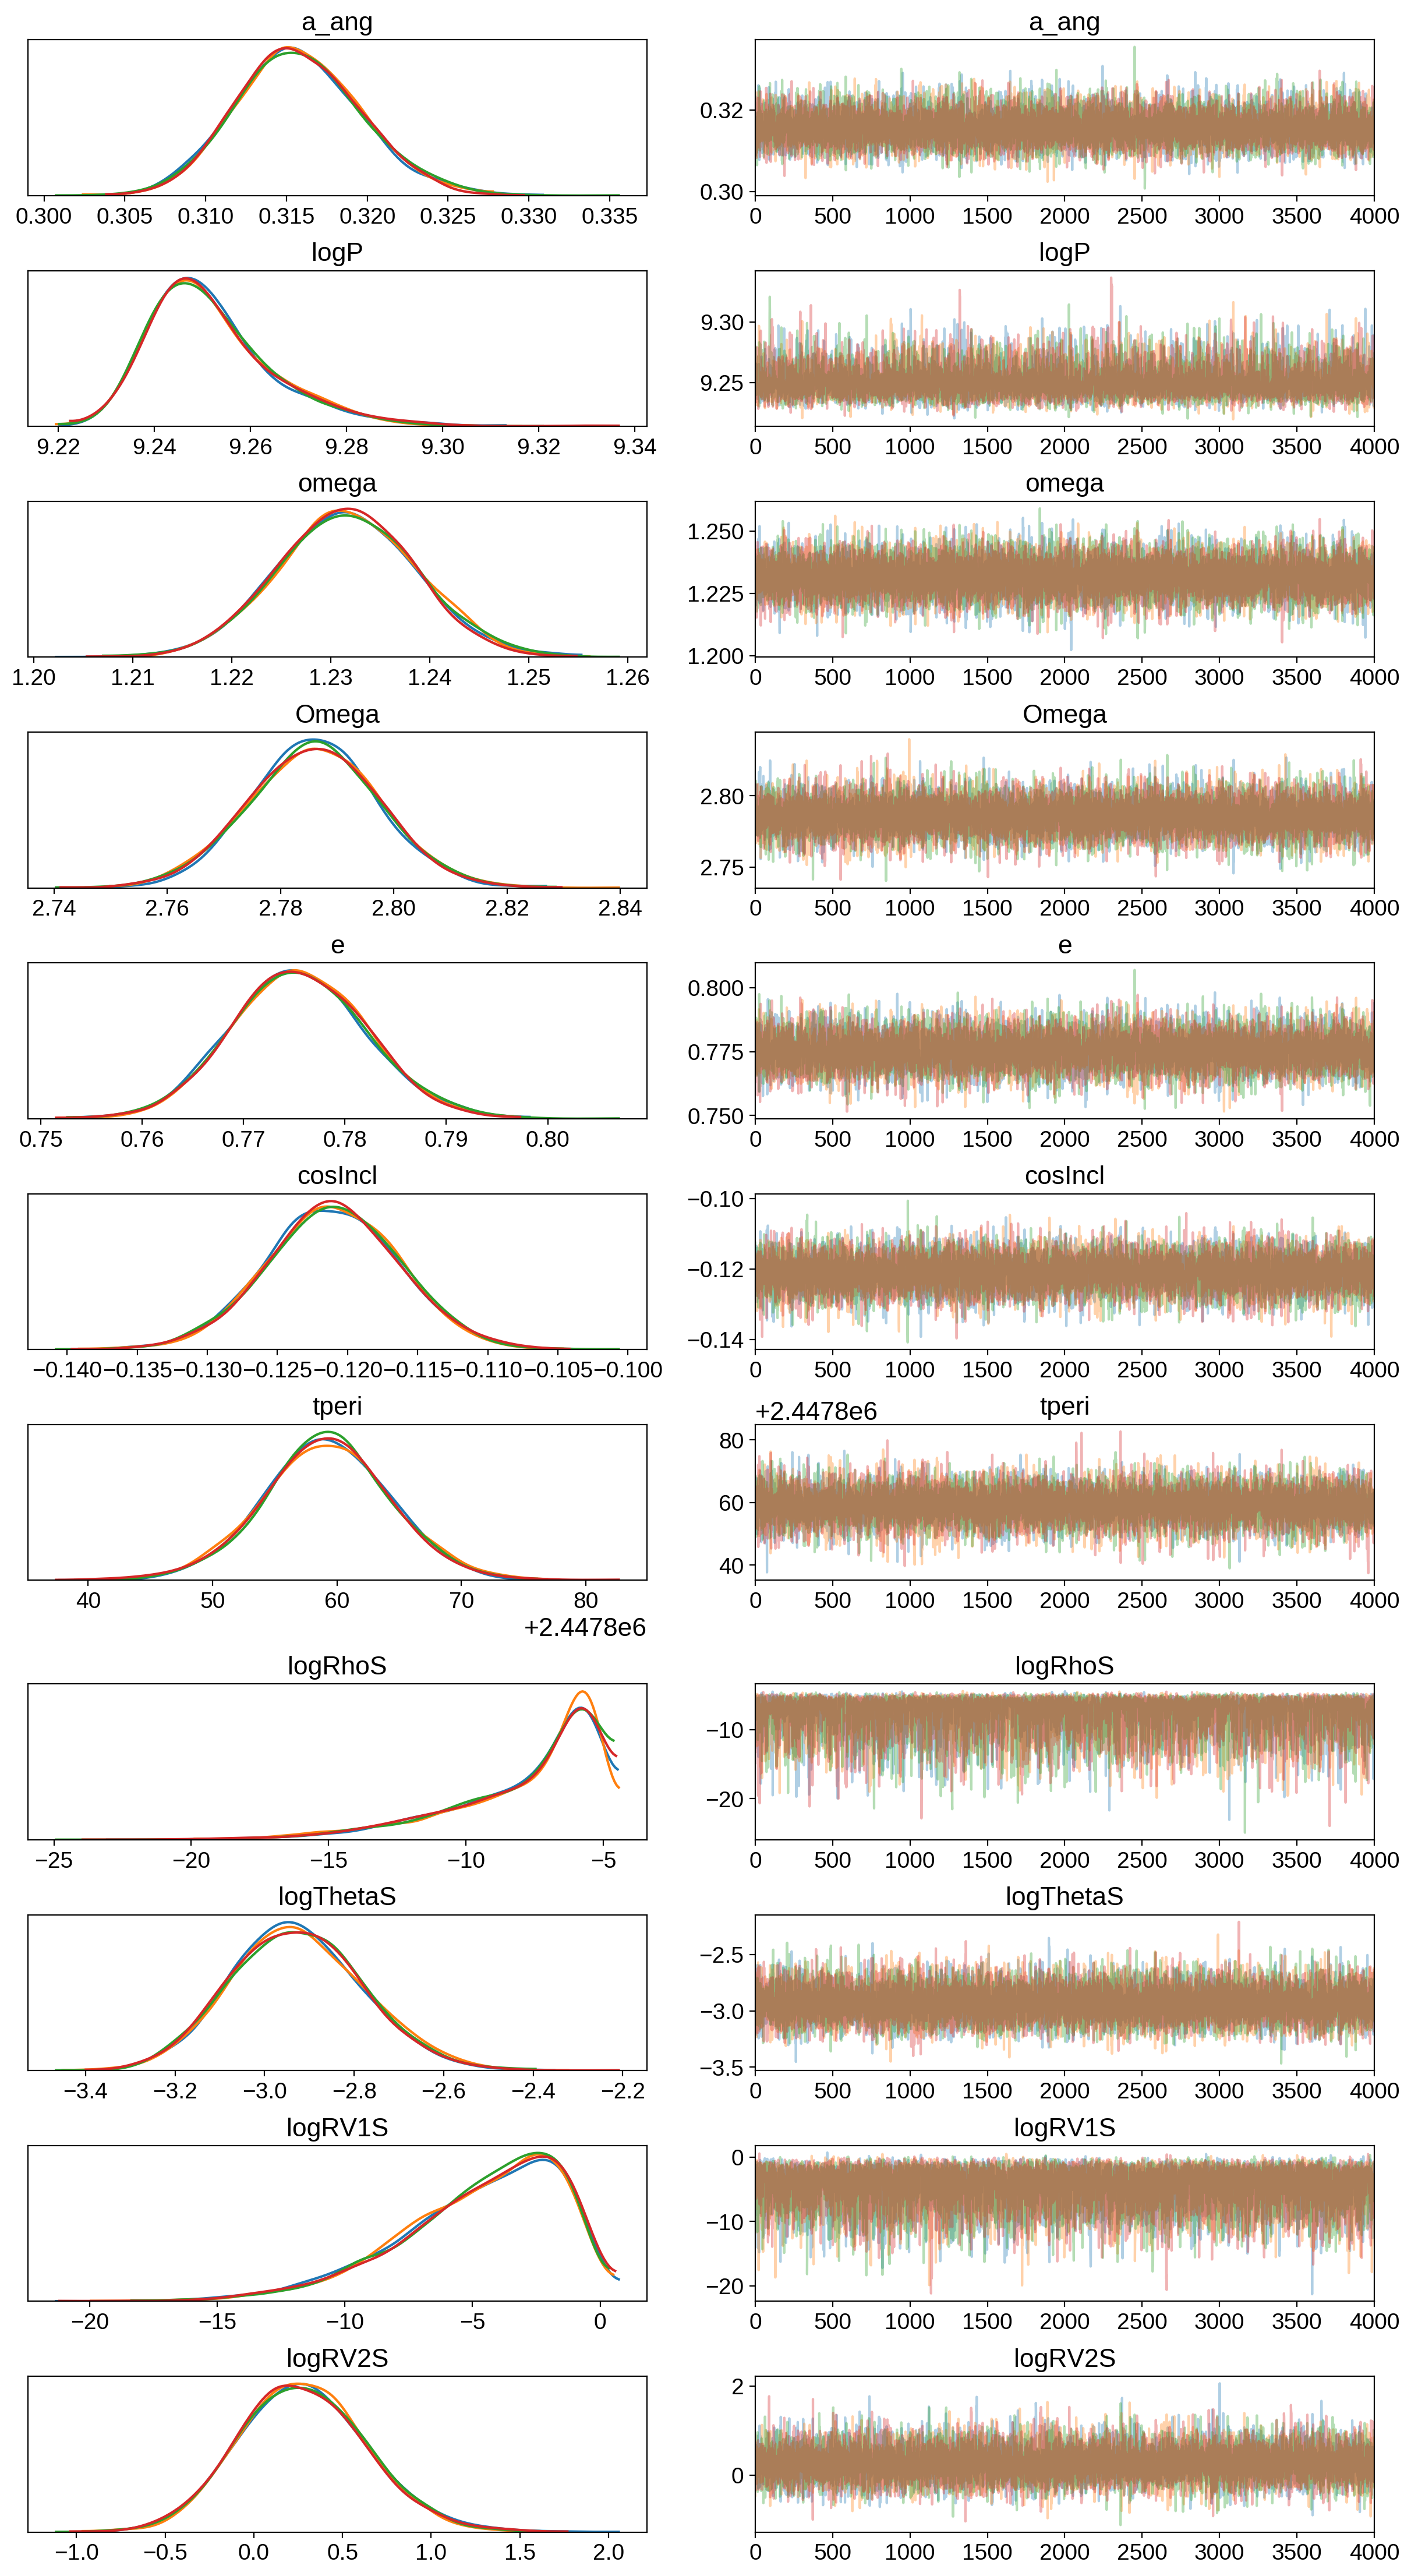

In [16]:
# let's examine the traces of the parameters we've sampled
pm.traceplot(trace, varnames=["a_ang", "logP", "omega", "Omega", "e", "cosIncl", "tperi", 
                              "logRhoS", "logThetaS", "logRV1S", "logRV2S"])

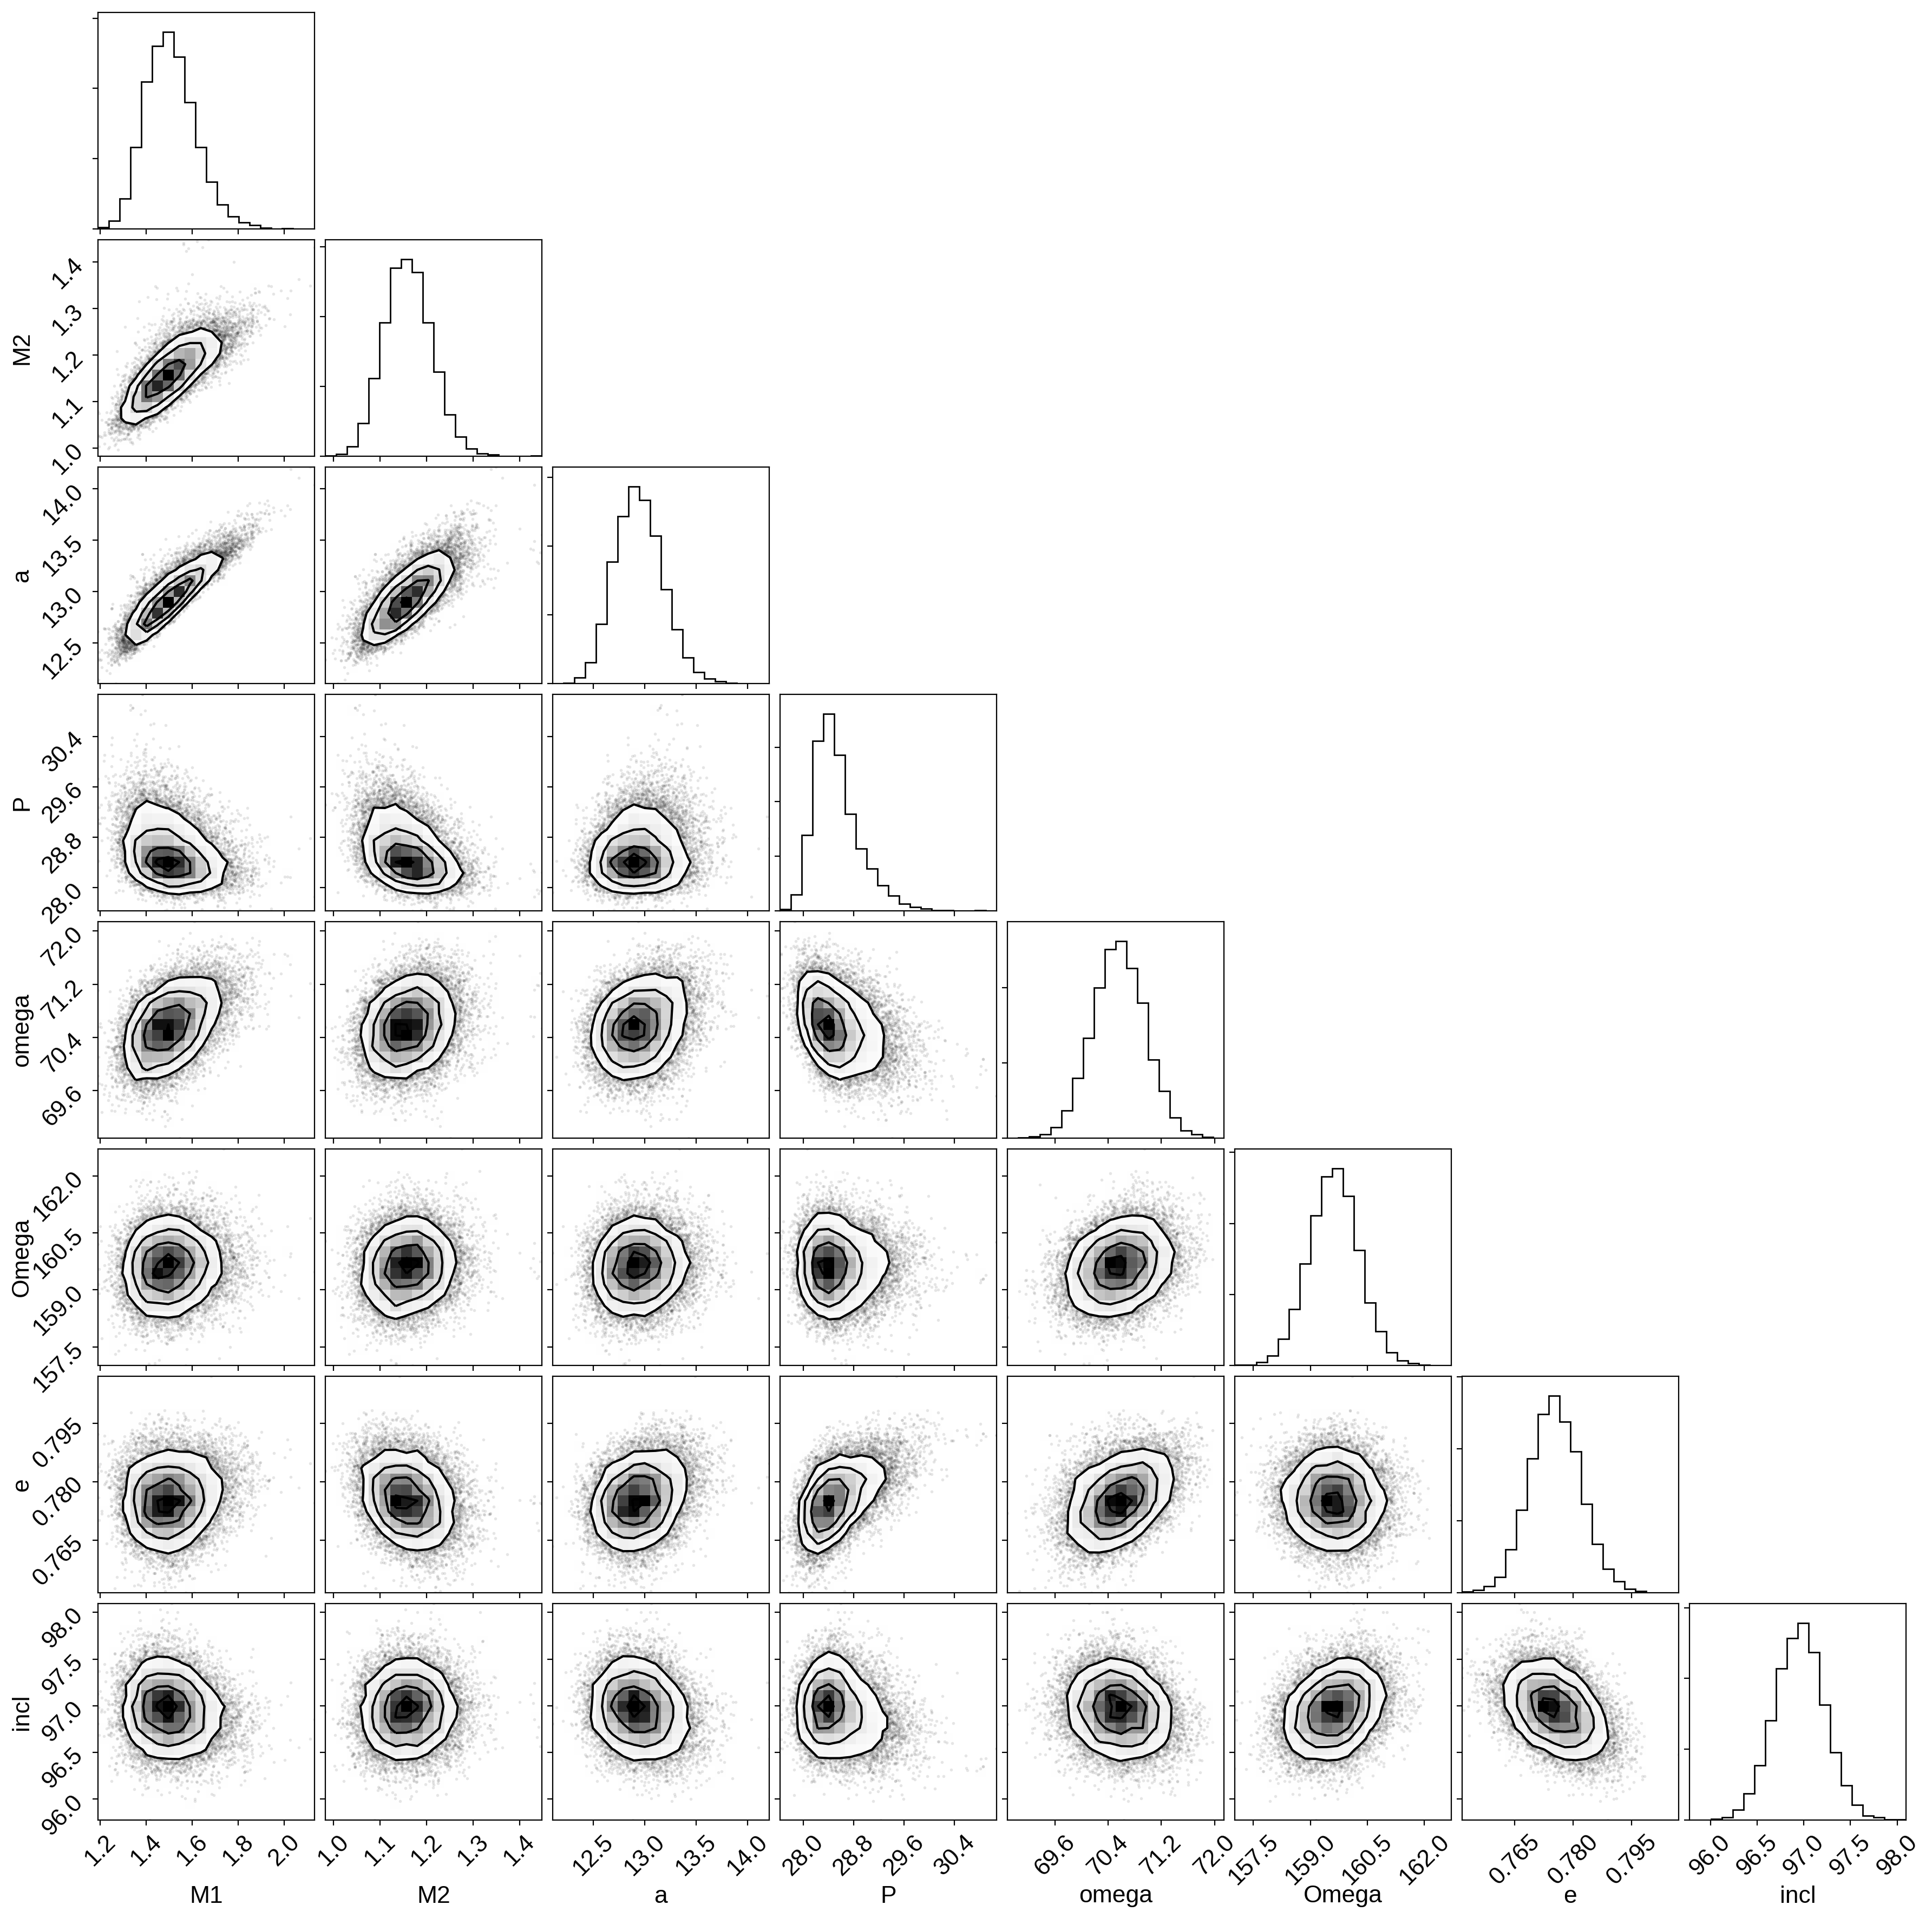

In [17]:
import corner  # https://corner.readthedocs.io

samples = pm.trace_to_dataframe(trace, varnames=["M1", "M2", "a", "P", "omega", "Omega", "e", "incl"])

samples["P"] /= yr
samples["incl"] /= deg
samples["omega"] /= deg
samples["Omega"] /= deg

corner.corner(samples);

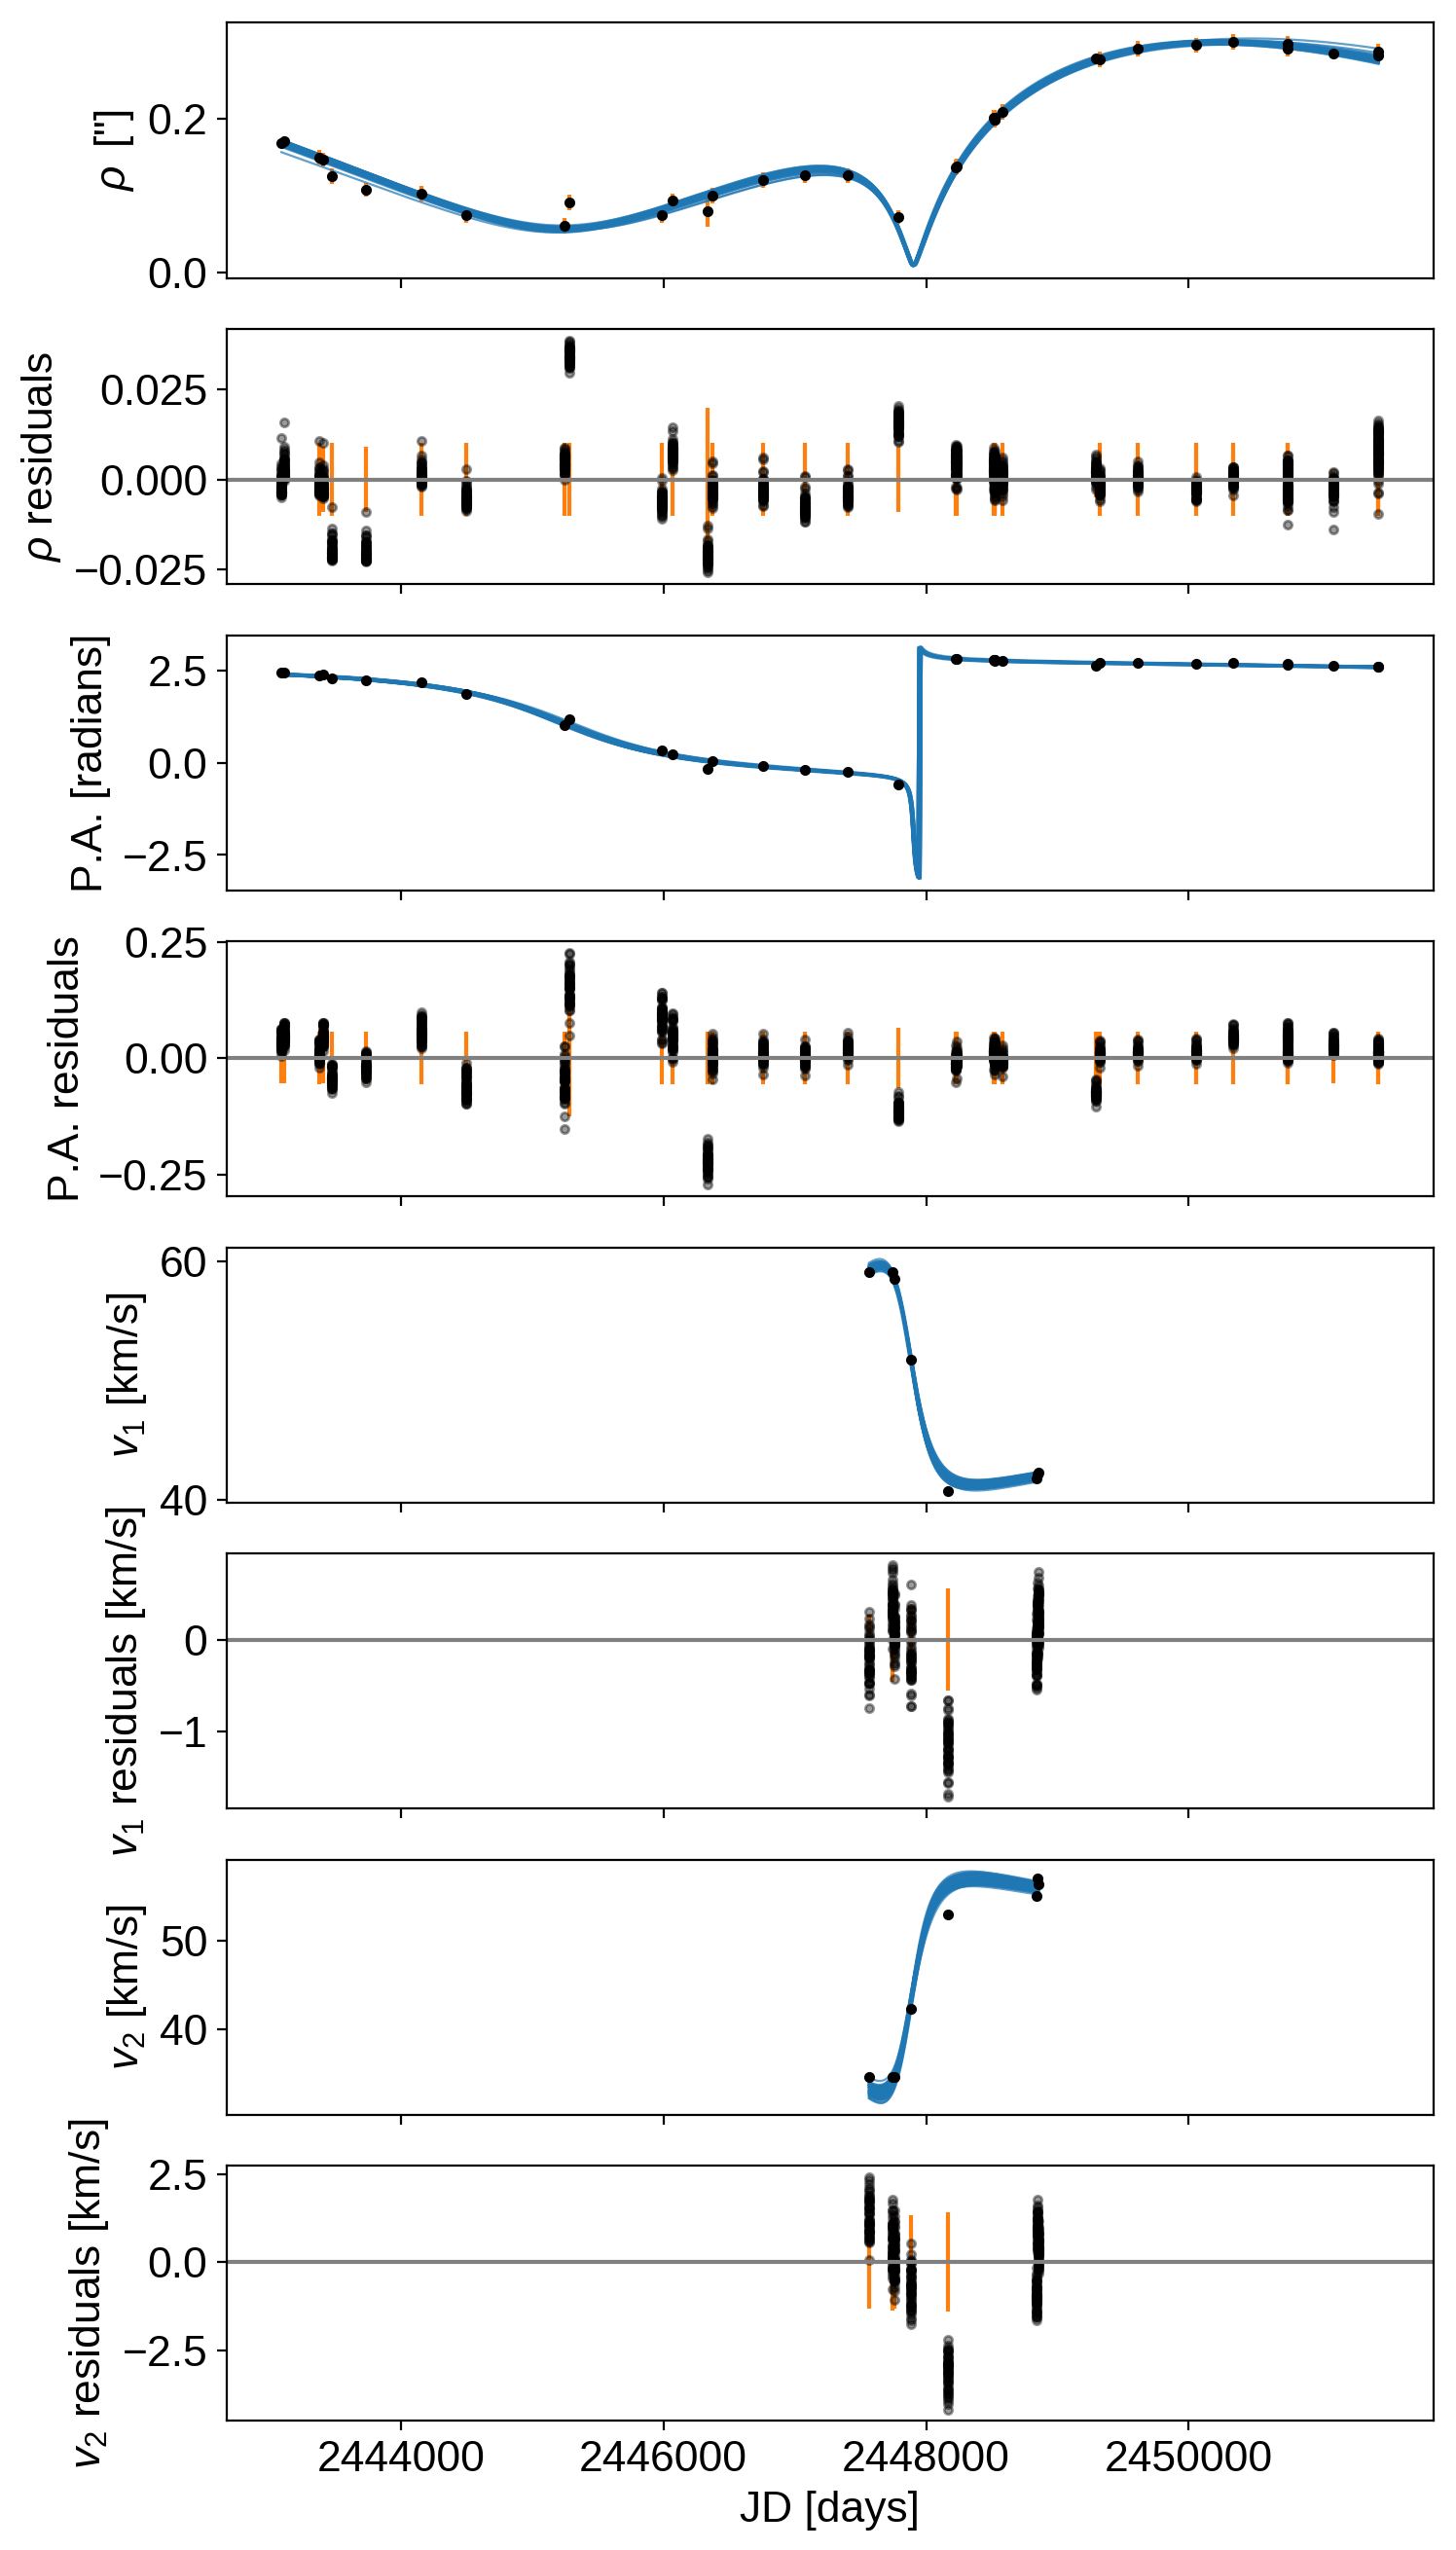

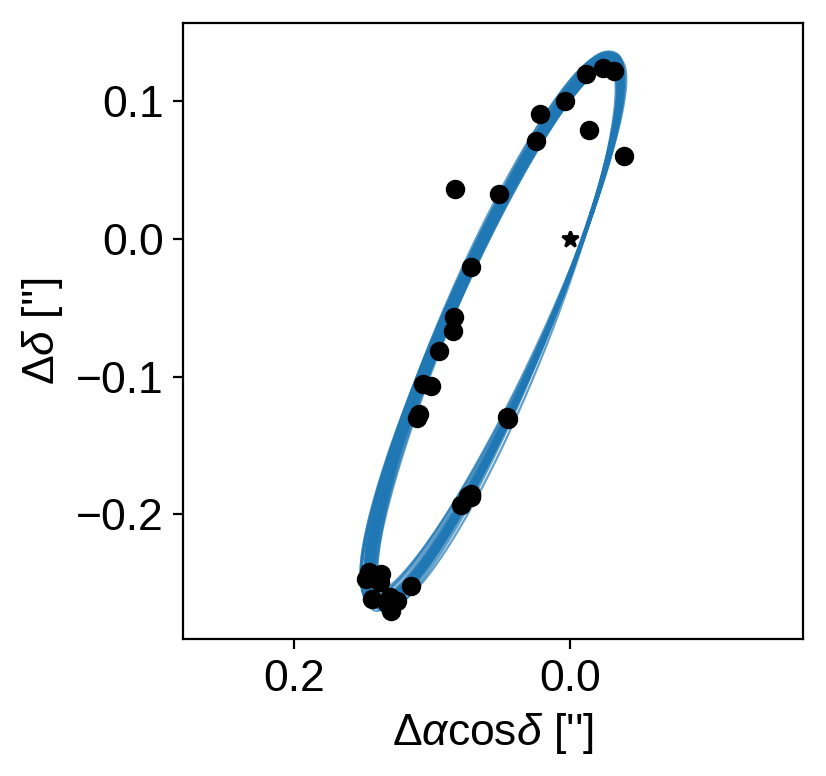

In [18]:
# plot the orbits on the figure

# we can plot the maximum posterior solution to see

pkw = {'marker':".", "color":"k", 'ls':""}
ekw = {'color':"C1", 'ls':""}

fig, ax = plt.subplots(nrows=8, sharex=True, figsize=(8,16))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'$\rho$ residuals')
ax[2].set_ylabel(r'P.A. [radians]')
ax[3].set_ylabel(r'P.A. residuals')

nsamples = 50
choices = np.random.choice(len(trace), size=nsamples)

# get map sol for tot_rho_err

tot_rho_err = np.sqrt(rho_err**2 + np.exp(2 * np.median(trace["logRhoS"])))
tot_theta_err = np.sqrt(theta_err**2 + np.exp(2 * np.median(trace["logThetaS"])))

tot_rv1_err = np.sqrt(rv1_err**2 + np.exp(2 * np.median(trace["logRV1S"])))
tot_rv2_err = np.sqrt(rv2_err**2 + np.exp(2 * np.median(trace["logRV2S"])))
    

ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'$\rho$ residuals')
ax[2].set_ylabel(r'P.A. [radians]')
ax[3].set_ylabel(r'P.A. residuals')
ax[4].set_ylabel(r'$v_1$ [km/s]')
ax[5].set_ylabel(r'$v_1$ residuals [km/s]')
ax[6].set_ylabel(r'$v_2$ [km/s]')
ax[7].set_ylabel(r'$v_2$ residuals [km/s]')
ax[7].set_xlabel("JD [days]")    


fig_sky, ax_sky = plt.subplots(nrows=1, figsize=(4,4))


with model:
    # iterate through trace object
    for i in choices:
        
        pos = trace[i] 
    
        rho_pred = pos["rhoSaveSky"]
        theta_pred = pos["thetaSaveSky"]

        x_pred = rho_pred * np.cos(theta_pred) # X north
        y_pred = rho_pred * np.sin(theta_pred) # Y east
    
        ax[0].plot(t_fine, pos["rhoSave"], color="C0", lw=0.8, alpha=0.7)
        
        ax[1].plot(astro_jds, rho_data - xo.eval_in_model(rho_model, pos), **pkw, alpha=0.4)

        ax[2].plot(t_fine, pos["thetaSave"], color="C0", lw=0.8, alpha=0.7)

        ax[3].plot(astro_jds, theta_data - xo.eval_in_model(theta_model, pos), **pkw, alpha=0.4)

        ax[4].plot(rv_times, pos["rv1Save"], color="C0", lw=0.8, alpha=0.7)
        
        ax[5].plot(rv1_jds, rv1 - xo.eval_in_model(rv1_model, pos), **pkw, alpha=0.4)
        
        ax[6].plot(rv_times, pos["rv2Save"], color="C0", lw=0.8, alpha=0.7)
        
        ax[7].plot(rv1_jds, rv2 - xo.eval_in_model(rv2_model, pos), **pkw, alpha=0.4)
        
        ax_sky.plot(y_pred, x_pred, color="C0", lw=0.8, alpha=0.7)
        
        

ax[0].plot(astro_jds, rho_data, **pkw)
ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
    
ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(astro_jds, np.zeros_like(astro_jds), yerr=tot_rho_err, **ekw)

ax[2].plot(astro_jds, theta_data, **pkw)
ax[2].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)
    
ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(astro_jds, np.zeros_like(astro_jds), yerr=tot_theta_err, **ekw) 

ax[4].plot(rv1_jds, rv1, **pkw)

ax[5].axhline(0.0, color="0.5")
ax[5].errorbar(rv1_jds, np.zeros_like(rv1_jds), yerr=tot_rv1_err, **ekw)

ax[6].plot(rv2_jds, rv2, **pkw)

ax[7].axhline(0.0, color="0.5")
ax[7].errorbar(rv2_jds, np.zeros_like(rv2_jds), yerr=tot_rv2_err, **ekw)


xs = rho_data * np.cos(theta_data) # X is north
ys = rho_data * np.sin(theta_data) # Y is east
ax_sky.plot(ys, xs, "ko")
ax_sky.set_ylabel(r"$\Delta \delta$ ['']")
ax_sky.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax_sky.invert_xaxis()
ax_sky.plot(0,0, "k*")
ax_sky.set_aspect("equal", "datalim")